In [1]:
%load_ext autoreload
%autoreload 2
import importlib

In [2]:
from typing import Tuple, Any, Dict
import os
import numpy as np
from tqdm import tqdm, tqdm_notebook
from random import shuffle
import json
import pickle
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.stats import multivariate_normal, norm
import numpy as np
import random
import math
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from sklearn.neighbors.kde import KernelDensity
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import time
from operator import itemgetter
from copy import deepcopy
import shutil
import spacy
import re
import multiprocessing
from functools import partial
from pathlib import Path
import inspect
import sling

In [474]:
from wikiutil.property import read_subgraph_file, read_subprop_file, get_is_parent, get_leaves, \
    get_is_ancestor, get_is_sibling, get_all_subtree, read_prop_occ_file_from_dir, read_nway_file, get_pid2plabel, \
    PropertyOccurrence
from wikiutil.util import read_embeddings_from_text_file, load_tsv_as_dict, load_tsv_as_list
from wikiutil.data import PointwiseDataset
from wikiutil.metric import accuracy_nway, accuracy_pointwise, rank_to_csv, get_ranks
from prop import dfs_find_quick, dfs_find
from wikiutil.textual_relation import FewRelDataset, WikipediaDataset, SlingDataset, \
    entity_idname_conversion, match_mention_entity
from wikiutil.load_sling_documents import load, get_mentions

In [188]:
def property_file_line_count(prop_occ_dir, out_filepath):
    print('load property count')
    prop_count = {}
    for root, dirs, files in os.walk(prop_occ_dir):
        for file in tqdm(files):
            if not file.endswith('.txt'):
                continue
            with open(os.path.join(root, file), 'r') as fin:
                num_lines = len(list(fin))
                prop_count[file[:-4]] = num_lines
    prop_count = sorted(prop_count.items(), key=lambda x: -x[1])
    plt.hist([i[1] for i in prop_count], bins=100)
    print('top prop: {}'.format(prop_count[:5]))
    print('tail prop: {}'.format(prop_count[-5:]))
    with open(out_filepath, 'w') as fout:
        for k, v in prop_count:
            fout.write('{}\t{}\n'.format(k, v))
def get_freq_entity_property_ids(entity_id2freq_file, out_filepath):
    print('load entity count ...')
    with open(entity_id2freq_file, 'r') as fin:
        entity_count = json.load(fin)
    entity_count = sorted(entity_count.items(), key=lambda x: -x[1])
    print('top entity: {}'.format(entity_count[:5]))
    print('tail entity: {}'.format(entity_count[-5:]))
    plt.hist([i[1] for i in entity_count], bins=100)
    with open(out_filepath, 'w') as fout:
        for k, v in entity_count:
            fout.write('{}\t{}\n'.format(k, v))
def get_entity_count_from_hiro_triple_file(triple_file, out_filepath):
    entity_count = defaultdict(lambda: 0)
    with open(triple_file, 'r') as fin:
        for l in tqdm_notebook(fin, total=270306417):
            sub, rel, obj = l.strip().split('\t')
            entity_count[sub] += 1
            entity_count[obj] += 1
    entity_count = sorted(entity_count.items(), key=lambda x: -x[1])
    print('top entity: {}'.format(entity_count[:5]))
    print('tail entity: {}'.format(entity_count[-5:]))
    with open(out_filepath, 'w') as fout:
        for k, v in entity_count:
            fout.write('{}\t{}\n'.format(k, v))

  0%|          | 0/1121 [00:00<?, ?it/s]

load property count


100%|██████████| 1121/1121 [00:24<00:00, 45.98it/s] 


top prop: [('P2860', 113715480), ('P31', 47572522), ('P1433', 18243186), ('P17', 9888100), ('P131', 6462332)]
tail prop: [('P1606', 1), ('P486', 1), ('P1194', 1), ('P5070', 1), ('P3027', 1)]


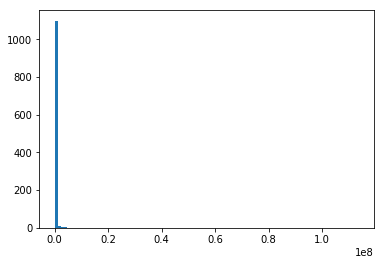

In [172]:
property_file_line_count('data/property_occurrence_all', 'data/property_count.tsv')

In [189]:
get_entity_count_from_hiro_triple_file('data/hiro_wikidata/triples.txt', 'data/entity_count_degree.tsv')

top entity: [('Q13442814', 17761376), ('Q5', 4838546), ('Q4167836', 4102977), ('Q6581097', 3195580), ('Q16521', 2463414)]
tail entity: [('Q56676316', 1), ('Q56676328', 1), ('Q56676331', 1), ('Q56676333', 1), ('Q56676353', 1)]


In [226]:
def bow_ana(filename, emb_id2ind_filename):
    with open(emb_id2ind_filename, 'rb') as fin:
        emb_id2ind = pickle.load(fin)
    emb_ind2id = dict((v, k) for k, v in emb_id2ind.items())
    with open(filename, 'r') as fin:
        for l in fin:
            bow1, bow2, label = l.strip().split('\t\t')
            pid1, word1s, _ = bow1.split('\t')
            pid2, word2s, _ = bow2.split('\t')
            print(pid1)
            print([emb_ind2id[int(w)] for w in word1s.split(',')])
            print(pid2)
            print([emb_ind2id[int(w)] for w in word2s.split(',')])
            input('continue')

In [ ]:
bow_ana('data/analogy_dataset/by_entail_622_subgraph10_ancestor5_sample100_maxoccperprop10k/train.bow.bow.prep',
       'data/analogy_dataset/by_entail_622_subgraph10_ancestor5_sample100_maxoccperprop10k/emb.txt.id2ind')

P710
['<PAD>', 'P31', 'P361', 'P276', 'P710', 'P21', 'Q6581097', 'P19', 'Q1773', 'P20', 'Q60', 'P27', 'Q30', 'Q34266', 'Q5', 'P735', 'Q15727189', 'P106', 'Q33231', 'P463', 'P734', 'P172', 'P551', 'P1412', 'Q1860', 'P1344', 'P17', 'Q40', 'P179', 'P131', 'P1346', 'Q39', 'Q36180', 'Q188', 'Q72', 'P937', 'Q220', 'P166', 'P641', 'Q7291', 'P279', 'Q13357858', 'Q29', 'P156', 'P155', 'Q1820274', 'Q13141064', 'Q145', 'Q21', 'Q82955', 'Q188094', 'Q1622272', 'Q15980158', 'P102', 'Q49768', 'Q183', 'Q1055', 'P39', 'Q1939555', 'P69', 'P108', 'Q154804', 'Q586', 'Q1718', 'Q64', 'Q2079', 'P103', 'P3602', 'Q668', 'P910', 'Q843', 'P138', 'P36', 'P47', 'Q837', 'Q902', 'Q836', 'Q148', 'Q1568', 'P150', 'Q1165', 'Q1061', 'Q1185', 'Q1186', 'Q1445', 'Q1498', 'Q1499', 'Q677037', 'Q1159', 'P6', 'P30', 'Q48', 'P1464', 'P421', 'Q6828', 'Q604055', 'P1792', 'Q38', 'Q155', 'Q159', 'Q801', 'Q408', 'Q851', 'Q212', 'Q184', 'Q423', 'Q424', 'Q403', 'Q17', 'Q884', 'Q794', 'Q41', 'Q712', 'Q258', 'Q958', 'Q881', 'Q77', 'Q878

In [438]:
emb_id2ind, emb = read_embeddings_from_text_file(
    'data/analogy_dataset/by_entail_622_subgraph10_ancestor5_sample100_maxoccperprop10k_haslongtailhasemptysplit/emb.txt', debug=False, emb_size=200, use_padding=True)


load emb from cache ...


In [514]:
emb_id2ind_small, emb_small = read_embeddings_from_text_file(
    '../pytorch_big_graph/model/wiki_split_ep50/embeddings.tsv', debug=False, 
    emb_size=200, use_padding=True, first_line=True)

The embeddings file has an unknown file extension ".tsv". We will assume the file is an (uncompressed) text file
740it [00:00, 7398.72it/s]

load emb from ../pytorch_big_graph/model/wiki_split_ep50/embeddings.tsv ...


602305it [00:55, 10924.32it/s]


cache emb ...


In [748]:
emb_id2ind_small2, emb_small2 = read_embeddings_from_text_file(
    '../pytorch_big_graph/emb/transe.txt', debug=False, 
    emb_size=200, use_padding=True, first_line=False)

load emb from cache ...


In [5]:
with open(os.path.join('data/analogy_dataset/by_entail_622_maxoccperprop10k_overlap/', 'poccs.pickle'), 'rb') as fin:
        poccs = pickle.load(fin)
        

In [101]:
with open(os.path.join('data/analogy_dataset/by_entail_622_maxoccperprop10k_nooverlap/', 'poccs.pickle'), 'rb') as fin:
        poccs2 = pickle.load(fin)
        

In [259]:
with open(os.path.join('data/analogy_dataset/by_entail_622_maxoccperprop10k_overlap_withouttest/', 'poccs.pickle'), 'rb') as fin:
        poccs3 = pickle.load(fin)
        

In [429]:
subprops = read_subprop_file('data/subprops.txt')
subtrees, _ = get_all_subtree(subprops)
pid2plabel = dict(p[0] for p in subprops)
pid2plabel_ = lambda x: pid2plabel[x.split('_', 1)[0]]
is_parent = get_is_parent(subprops)
is_ancestor = get_is_ancestor(subtrees)
is_sibling = get_is_sibling(subprops)

6092 props
107 subtree
avg depth: 2.2429906542056073
5499 isolated prop


In [426]:
subprops_split = read_subprop_file('data/property_occurrence_prop580k_split/subprops')
subtrees_split, _ = get_all_subtree(subprops_split)
is_parent_split = get_is_parent(subprops_split)
is_ancestor_split = get_is_ancestor(subtrees_split)
is_sibling_split = get_is_sibling(subprops_split)

#is_parent = is_parent_split
#is_ancestor = is_ancestor_split
#is_sibling = is_sibling_split

8713 props
107 subtree
avg depth: 2.7757009345794392
5499 isolated prop


In [332]:
def test():
    for st in subtrees_split:
        pass
        #print(st.tree[0])
    for sp in subprops_split:
        if sp[0][0] == 'P2561':
            print(sp)
        if 'P1476' in [c[0] for c in sp[1]]:
            print(sp)
test()

(('P2561', 'name'), [('P561', 'NATO reporting name P734', 'family name P735', 'given name P742', 'pseudonym P1448', 'official name P1449', 'nickname P1476', 'title P1477', 'birth name P1559', 'name in native language P1705', 'native label P1782', 'courtesy name P1813', 'short name P1814', 'name in kana P1843', 'taxon common name P2358', 'Roman praenomen P2562', 'married name P4633', 'name of the character role')])


In [696]:
def get_rel(parent, child, is_parent):
    if (parent, child) in is_parent:
        return 'parent'
    elif (parent, child) in is_ancestor:
        return 'ancestor'
    elif child.startswith(parent + '_'):
        return 'parent'
    else:
        return '*'
def get_label_dist(props, labels):
    dist = []
    for p in props:
        for l in labels:
            if (l, p) in is_parent:
                dist.append(pid2plabel_(l))
    u, c = np.unique(dist, return_counts=True)
    print(sorted(zip(u, c), key=lambda x: -x[1]))
def sim_func(child_emb, parent_emb, method='cosine', sigma=1.0, kde_c=None, kde_p=None):
    if method == 'cosine':
        return np.mean(cosine_similarity(child_emb, parent_emb))
    if method == 'expeuc':
        dist = np.expand_dims(child_emb, 1) - np.expand_dims(parent_emb, 0)
        dist = np.sum(dist * dist, -1)
        dist_min = np.min(dist, -1)
        sim = np.exp(-dist + np.expand_dims(dist_min, -1))
        sim = np.mean(np.log(np.mean(sim, -1)) - dist_min)
        return sim
    if method == 'mixgau':
        emb_dim = child_emb.shape[1]
        num_occ_child = child_emb.shape[0]
        num_occ_parent = parent_emb.shape[0]
        sigma = 1.0
        rv = multivariate_normal(np.zeros(emb_dim), np.diag(np.ones(emb_dim)) * sigma)
        dist = np.expand_dims(child_emb, 1) - np.expand_dims(parent_emb, 0)
        sim = rv.pdf(dist)
        sim = np.sum(np.log(np.sum(sim / num_occ_parent, axis=-1)))
        return sim
    if method == 'mixgau_fast':
        emb_dim = child_emb.shape[1]
        num_occ_child = child_emb.shape[0]
        num_occ_parent = parent_emb.shape[0]
        sigma = 1.0
        var = np.array([sigma] * emb_dim)
        # SHAPE: (num_occ_child, num_occ_parent, emb_dim)
        dist = np.expand_dims(child_emb, 1) - np.expand_dims(parent_emb, 0)
        dist = np.reshape(dist, (-1, emb_dim))
        denominator = -0.5 * (emb_dim * (math.log(2 * np.pi)) + np.sum(np.log(var)))
        numerator = -0.5 * np.sum(dist ** 2 / np.expand_dims(var, 0), -1)
        log_prob = np.reshape(denominator + numerator, (num_occ_child, num_occ_parent))
        log_prob_min = np.min(log_prob, -1)
        sim = np.sum(np.log(np.sum(np.exp(log_prob - np.expand_dims(log_prob_min, -1)) / num_occ_parent, axis=-1)) + log_prob_min)
        return sim
    if method == 'avg':
        child_emb = np.mean(child_emb, 0)
        parent_emb = np.mean(parent_emb, 0)
        return np.mean(cosine_similarity([child_emb], [parent_emb]))
    if method == 'kde':
        if kde_c is None:
            kde_c = KernelDensity(kernel='gaussian', bandwidth=sigma).fit(child_emb)
        if kde_p is None:
            kde_p = KernelDensity(kernel='gaussian', bandwidth=sigma).fit(parent_emb)
        child_prob = kde_c.score_samples(child_emb)
        parent_prob = kde_p.score_samples(child_emb)
        kl = np.sum(np.exp(child_prob) * (child_prob - parent_prob))
        return -kl
    raise NotImplementedError
def test_overlap(data_dir, emb, emb_id2ind, split, poccs, top=100, method='cosine', 
                 only_prop_emb=False, detect_cheat=True, use_minus=False, evaluation=is_parent,
                 use_split=False, filter_num_poccs=None, filter_pids=None,
                 **kwargs):
    emb_dim = emb.shape[1]
    print('#words in emb: {}'.format(len(emb_id2ind)))
    '''
    with open(os.path.join(data_dir, 'poccs.pickle'), 'rb') as fin:
        poccs = pickle.load(fin)
    '''
    all_ids = set()
    new_poccs = {}
    for k in poccs:
        if top:
            new_poccs[k] = random.sample(poccs[k], len(poccs[k]))[:top]
        else:
            new_poccs[k] = poccs[k]
        if len(new_poccs[k]) > 0:
            heads, tails = zip(*new_poccs[k])
            all_ids.update(heads)
            all_ids.update(tails)
    all_ids_emb = all_ids & set(emb_id2ind.keys())
    print('#entities in property occs: {}, {} have embs'.format(len(all_ids), len(all_ids_emb)))
    if type(split) is str:
        props = list(load_tsv_as_dict(os.path.join(data_dir, split)).keys())
    else:
        props = []
        for sp in split:
            props += list(load_tsv_as_dict(os.path.join(data_dir, sp)).keys())
    labels = list(load_tsv_as_dict(os.path.join(data_dir, 'label2ind.txt')).keys())
    
    # remove image-related properites
    props = [tp for tp in props if tp != 'P18' and ('P18', tp) not in is_ancestor]
    labels = [l for l in labels if l != 'P18' and ('P18', l) not in is_ancestor]
    
    print('#property: {} #label: {}'.format(len(props), len(labels)))
    get_label_dist(props, labels)
    total, correct, mrr = 0, 0, 0
    correct_li, total_set = [], set()
    rank_dict: Dict[str, List] = {}
    kde_dict: Dict[str, Any] = {}
    for tp in tqdm_notebook(props):
        if filter_pids and tp not in filter_pids:
            continue
        tps = new_poccs[tp]
        if filter_num_poccs and len(tps) <= filter_num_poccs:
            continue
        if only_prop_emb:
            tps_emb = np.array([emb[emb_id2ind[tp]]])
        else:
            tps_emb = [emb[emb_id2ind[e]] for o in tps for e in o if o[0] in emb_id2ind and o[1] in emb_id2ind]
            tps_emb = np.array(tps_emb).reshape(-1, 2 * emb_dim)
        if use_minus:
            tps_emb = tps_emb[:, :emb_dim] - tps_emb[:, emb_dim:]
        if len(tps_emb) == 0:
            continue
        ranks = []
        for l in labels:
            if tp == l:
                continue
            if l not in new_poccs or len(new_poccs[l]) <= 0:
                continue
            ls = new_poccs[l]
            if detect_cheat and (l, tp) in is_ancestor and len(set(tps) & set(ls)) > 0:
                raise Exception('parent {} child {} is cheating'.format(tp, l))
            if only_prop_emb:
                if l not in emb_id2ind:
                    continue
                ls_emb = np.array([emb[emb_id2ind[l]]])
            else:
                ls_emb = [emb[emb_id2ind[e]] for o in ls for e in o if o[0] in emb_id2ind and o[1] in emb_id2ind]
                ls_emb = np.array(ls_emb).reshape(-1, 2 * emb_dim)
            if use_minus:
                ls_emb = ls_emb[:, :emb_dim] - ls_emb[:, emb_dim:]
            if ls_emb.shape[0] <= 0:
                continue
            if method == 'kde':
                if tp not in kde_dict:
                    kde_dict[tp] = KernelDensity(kernel='gaussian', bandwidth=kwargs['sigma']).fit(tps_emb)
                if l not in kde_dict:
                    kde_dict[l] = KernelDensity(kernel='gaussian', bandwidth=kwargs['sigma']).fit(ls_emb)
                sim = sim_func(tps_emb, ls_emb, method=method, 
                               kde_c=kde_dict[tp], kde_p=kde_dict[l], **kwargs)
            else:
                sim = sim_func(tps_emb, ls_emb, method=method, **kwargs)
            ranks.append((l, sim))
        ranks = sorted(ranks, key=lambda x: -x[1])
        ranks = [(l, sim, get_rel(l, tp, evaluation)) for l, sim in ranks]
        rank_dict[tp] = ranks
        if (ranks[0][0], tp) in evaluation:
            correct += 1
            correct_li.append((tp))
        rr = 0
        for i in range(len(ranks)):
            if (ranks[i][0], tp) in evaluation:
                rr = 1 / (i + 1)
                break
        mrr += rr
        total += 1
        total_set.add(tp)
    print(correct / total, mrr / total, total)
    get_label_dist(correct_li, labels)
    print(correct_li)
    #print([(k, len(v)) for k, v in rank_dict.items()])
    class pid2plabel_wrapper():
        def __init__(self, pid2plabel):
            self.pid2plabel = pid2plabel
        def __getitem__(self, item):
            pid = item.split('_', 1)
            if len(pid) == 1:
                return self.pid2plabel[pid[0]]
            return self.pid2plabel[pid[0]] + '_' + pid[1]
    p2p = pid2plabel_wrapper(pid2plabel)
    rank_to_csv(rank_dict, 'ranks.csv', key2name=p2p)
    return total_set
    
    

In [571]:
def test_ori(data_dir, split):
    with open(os.path.join(data_dir, 'poccs.pickle'), 'rb') as fin:
        this_poccs = pickle.load(fin)
    test_overlap(data_dir, emb, emb_id2ind,
                 split, this_poccs, top=100, method='mixgau_fast', only_prop_emb=False, 
                 detect_cheat=False, use_minus=False, evaluation=is_parent, sigma=1.0, 
                 filter_num_poccs=None, filter_pids=None)
test_ori('data/analogy_dataset/by_entail_622_maxoccperprop10k_overlap_withouttest/', 'test.prop')


#words in emb: 3845288


70it [00:00, 331004.83it/s]
91it [00:00, 348886.35it/s]

#entities in property occs: 47500, 47027 have embs
#property: 69 #label: 89
[('location', 7), ('significant person', 7), ('part of', 5), ('participant', 4), ('author', 3), ('has part', 3), ('uses', 3), ('creator', 2), ('film crew member', 2), ('follows', 2), ('general classification of race participants', 2), ('manifestation of', 2), ('member of', 2), ('relative', 2), ('approved by', 1), ('chairperson', 1), ('connects with', 1), ('country', 1), ('depends on software', 1), ('designed by', 1), ('direction', 1), ('field of work', 1), ('followed by', 1), ('has facility', 1), ('has list', 1), ('has parts of the class', 1), ('heritage designation', 1), ('instance of', 1), ('languages spoken, written or signed', 1), ('located on terrain feature', 1), ('manufacturer', 1), ('next higher rank', 1), ('next lower rank', 1), ('objective of project or action', 1), ('participant of', 1), ('present in work', 1), ('professional or sports partner', 1), ("topic's main category", 1), ('use', 1)]



0.30434782608695654 0.4035051205373705 69
[('general classification of race participants', 2), ('manifestation of', 2), ('relative', 2), ('author', 1), ('chairperson', 1), ('connects with', 1), ('country', 1), ('depends on software', 1), ('designed by', 1), ('direction', 1), ('has list', 1), ('languages spoken, written or signed', 1), ('located on terrain feature', 1), ('present in work', 1), ('professional or sports partner', 1), ('significant person', 1), ("topic's main category", 1), ('uses', 1)]
['P3966', 'P35', 'P4151', 'P5130', 'P1881', 'P3092', 'P495', 'P103', 'P87', 'P84', 'P4584', 'P1414', 'P4322', 'P4321', 'P654', 'P2095', 'P3876', 'P3490', 'P40', 'P1290', 'P2702']


In [566]:
def test_ori(data_dir, split):
    with open(os.path.join(data_dir, 'poccs.pickle'), 'rb') as fin:
        this_poccs = pickle.load(fin)
        print(len(this_poccs['P3342']))
        print(len(this_poccs['P57']))
        print(len(this_poccs['P1640']))
    labels = set(load_tsv_as_dict(os.path.join(data_dir, 'label2ind.txt')).keys())
    props = set(load_tsv_as_dict(os.path.join(data_dir, split)).keys())
    joint = labels & props
    print(len(labels), len(joint))
    print(joint)
    for p in props:
        for j in joint:
            if (j, p) in is_parent:
                print(j, p)
test_ori('data/analogy_dataset/by_entail_622_maxoccperprop10k_overlap_withouttest/', 'test.prop')

91it [00:00, 368774.55it/s]
70it [00:00, 333259.11it/s]

77247
4947
213
91 6
{'P710', 'P1346', 'P1366', 'P3092', 'P828', 'P1365'}
P710 P1346
P3092 P1040
P710 P682
P710 P1591
P3092 P58
P710 P726


In [674]:
def plot_norm(mu=0, var=1):
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    plt.plot(x, norm.pdf(x, mu, sigma))
    plt.show()
def plot_log(scale):
    x = np.linspace(1, 10**5, 100)
    print([(10**i, np.sqrt(10**i) * scale) for i in range(7)])
    plt.plot(x, np.sqrt(x) * scale, label='sqrt(x) * {}'.format(scale))
    plt.plot(x, np.log(x) * scale, label='log(x) * {}'.format(scale))
    plt.plot(x, x, label='x')
    plt.legend(loc='upper left')
    plt.show()

[(1, 10.0), (10, 31.622776601683796), (100, 100.0), (1000, 316.2277660168379), (10000, 1000.0), (100000, 3162.2776601683795), (1000000, 10000.0)]


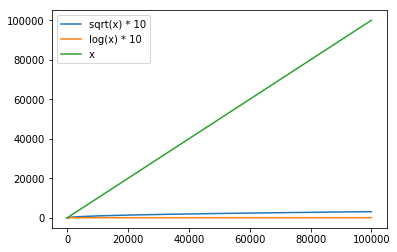

In [675]:
plot_log(scale=10)

In [151]:
def fit_norm_for_property(out_filename):
    result = defaultdict(lambda: {})
    for i, (p, occs) in tqdm_notebook(enumerate(poccs.items())):
        data = []
        for h, t in occs:
            if h not in emb_id2ind or t not in emb_id2ind:
                continue
            data.append(np.concatenate([emb[emb_id2ind[h]], emb[emb_id2ind[t]]], axis=0))
        if len(data) <= 0:
            continue
        mean = np.mean(data, axis=0)
        cov = np.cov(data, rowvar=0)
        result[p]['mean'] = mean
        result[p]['cov'] = cov
    print('dump')
    with open(out_filename, 'wb') as fout:
        pickle.dump(dict(result), fout)

In [152]:
fit_norm_for_property('data/analogy_dataset/by_entail_622_maxoccperprop10k_overlap/norm_fit.pickle')


dump


In [222]:
def test():
    with open('data/analogy_dataset/by_entail_622_maxoccperprop10k_overlap/norm_fit.pickle', 'rb') as fout:
        prop_norm = pickle.load(fout)
    mean = prop_norm['P1040']['mean']
    cov = np.diag(prop_norm['P1040']['cov']) + 1e-3
    sam = np.random.multivariate_normal(mean, np.diag(cov), 100)
    p = multivariate_normal.logpdf(sam, mean, np.diag(cov))
    print(p)
test()

In [709]:
def tsne_vis(poccs, pca_dim=50, top=100, y_map=None, filter_set=None, use_split=False):
    X, y, is_parent_or_not = [], [], []
    for pid, occs in tqdm(poccs.items()):
        c = 0
        if type(y_map) is dict:
            yid = y_map[pid] if pid in y_map else pid
        elif callable(y_map):
            yid = y_map(pid)
        else:
            yid = pid
        if filter_set:
            if use_split and yid.split('_')[0] not in filter_set:
                continue
            if not use_split and yid not in filter_set:
                continue
        for h, t in occs:
            if h in emb_id2ind and t in emb_id2ind:
                c += 1
                X.append(np.concatenate([emb[emb_id2ind[h]], emb[emb_id2ind[t]]], 0))
                if use_split:
                    is_parent_or_not.append(int(yid.find('_') == -1))
                    y.append(yid)
                else:
                    is_parent_or_not.append(0)
                    y.append(yid + ' ' + pid2plabel[yid.split('_')[0]])
                if c >= top:
                    break
    X = np.array(X)
    ny = len(np.unique(y))
    print('fittign X {} with {} labels ...'.format(X.shape, ny))
    time_start = time.time()
    if pca_dim:
        pca = PCA(n_components=pca_dim)
        X = pca.fit_transform(X)
        print('PCA done! Cumulative explained variation for {} principal components: {}'.format(
            pca_dim, np.sum(pca.explained_variance_ratio_)))
    X_embedded = TSNE(n_components=2, verbose=1, n_iter=500).fit_transform(X)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))
    df = pd.DataFrame()
    df['tsne-2d-one'] = X_embedded[:,0]
    df['tsne-2d-two'] = X_embedded[:,1]
    df['y'] = y
    df['is_parent_or_not'] = is_parent_or_not
    df['size'] = 1 - np.array(is_parent_or_not)
    plt.figure(figsize=(16,10))
    if use_split:
        sns.scatterplot(
            x='tsne-2d-one', y='tsne-2d-two',
            hue='y',
            size='size',
            style='is_parent_or_not',
            palette=sns.color_palette('hls', ny),
            data=df,
            legend='full',
            alpha=0.5
        )
    else:
        sns.scatterplot(
            x='tsne-2d-one', y='tsne-2d-two',
            hue='y',
            palette=sns.color_palette('hls', ny),
            data=df,
            legend='full',
            alpha=0.5
        )

100%|██████████| 353/353 [00:00<00:00, 2470.79it/s]


fittign X (21579, 400) with 8 labels ...
PCA done! Cumulative explained variation for 200 principal components: 0.8670324087142944
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 21579 samples in 0.178s...
[t-SNE] Computed neighbors for 21579 samples in 150.130s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21579
[t-SNE] Computed conditional probabilities for sample 2000 / 21579
[t-SNE] Computed conditional probabilities for sample 3000 / 21579
[t-SNE] Computed conditional probabilities for sample 4000 / 21579
[t-SNE] Computed conditional probabilities for sample 5000 / 21579
[t-SNE] Computed conditional probabilities for sample 6000 / 21579
[t-SNE] Computed conditional probabilities for sample 7000 / 21579
[t-SNE] Computed conditional probabilities for sample 8000 / 21579
[t-SNE] Computed conditional probabilities for sample 9000 / 21579
[t-SNE] Computed conditional probabilities for sample 10000 / 21579
[t-SNE] Computed conditional probabilities for sample

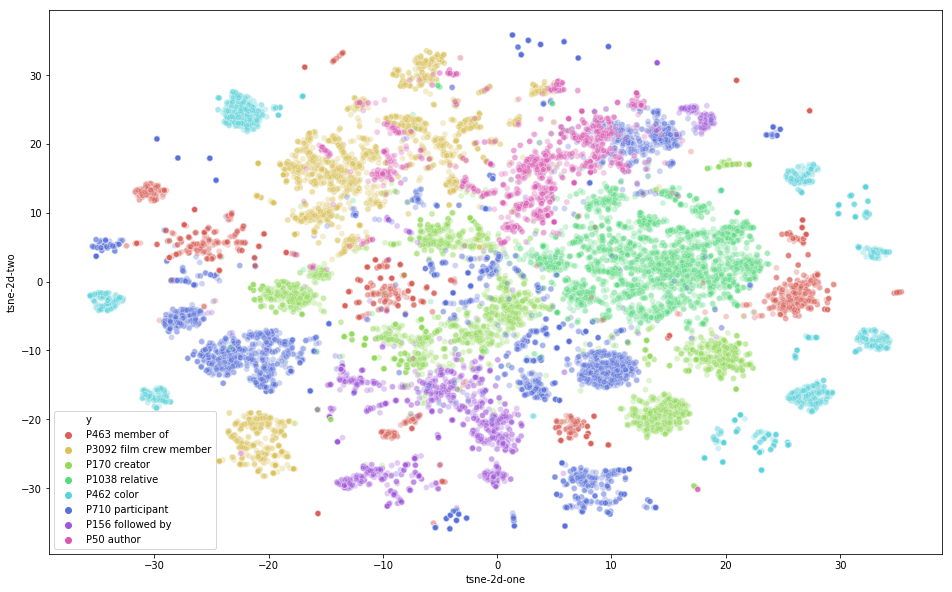

In [611]:
y_map = dict((v, k) for k, v in is_parent)
#filter_set = ['P156', 'P170', 'P50', 'P276', 'P361', 'P1344', 'P1416', 'P463', 'P462',
#             'P2354', 'P3342', 'P710', 'P1038', 'P3092']
filter_set = ['P156', 'P170', 'P50', 'P463', 'P462', 'P710', 'P1038', 'P3092']
tsne_vis(poccs2, pca_dim=200, top=500, y_map=y_map, filter_set=filter_set)

In [137]:
def read_graph_link(filename):
    parent2chids = defaultdict(lambda: [])
    child2parents = defaultdict(lambda: [])
    with open(filename, 'r') as fin:
        for i, l in tqdm(enumerate(fin)):
            subj, rel, obj = l.strip().split('\t')
            if subj == 'Q35120':  # use "entity" as one of the root
                continue
            parent2chids[obj].append(subj)
            child2parents[subj].append(obj)
    return dict(parent2chids), dict(child2parents)
def get_partial_order(p2c, c2p):
    ps = set(p2c.keys())
    cs = set(c2p.keys())
    all_nodes = ps | cs
    roots = all_nodes - cs
    went = set()
    last_layer = roots
    depth = 0
    node2dep = {}
    print('total {} nodes, with {} roots'.format(len(all_nodes), len(roots)))
    while len(last_layer) > 0:
        print('depth: {}'.format(depth))
        next_layer = set()
        went.update(last_layer)
        for n in last_layer:
            node2dep[n] = depth
            if n in p2c:
                for c in p2c[n]:
                    can = True
                    for p in c2p[c]:
                        if p not in went:
                            can = False
                            break
                    if can and c not in went:
                        next_layer.add(c)
        last_layer = next_layer
        depth += 1
    # TODO: there are cycles, so the number in node2dep is not equal to the number in all_nodes
    in_partial_order = set(node2dep.keys())
    other_node2dep = {}
    for other in tqdm_notebook(all_nodes - in_partial_order):
        dfs_find(other, c2p, destination=in_partial_order, node2dest=other_node2dep, hist=set())
    for k, (dest, dep) in other_node2dep.items():
        node2dep[k] = node2dep[dest] + dep
    return node2dep

In [138]:
def cycle_debug(start, c2p):
    went = set()
    last_layer = {start}
    while len(last_layer) > 0:
        next_layer = set()
        print(last_layer)
        went.update(last_layer)
        for n in last_layer:
            if n not in c2p:
                print('find root!')
            else:
                for p in c2p[n]:
                    if p not in went:
                        next_layer.add(p)
        last_layer = next_layer

In [139]:
p2c, c2p = read_graph_link('data/ontology/subclass_instance_triples.txt')

49581019it [02:28, 334034.19it/s]


In [140]:
node2depth = get_partial_order(p2c, c2p)

total 46789945 nodes, with 7657 roots
depth: 0
depth: 1
depth: 2
depth: 3
depth: 4
depth: 5
depth: 6
depth: 7
depth: 8
depth: 9
depth: 10
depth: 11
depth: 12


In [626]:
def save_node2depth(filename):
    with open(filename, 'w') as fout:
        for k,v in sorted(node2depth.items(), key=lambda x: x[1]):
            fout.write('{}\t{}\n'.format(k, v))

In [627]:
save_node2depth('data/ontology/node2depth.tsv')

In [475]:
entity2toplevel = load_tsv_as_dict('data/ontology/subclass_instance_triples_totop.txt')

In [536]:
def entity2toplevel_(x, use_raw=False):
    if use_raw:
        return x
    return entity2toplevel[x]

In [283]:
def property_split(pid, pocc_dir, subgraph_dict, thres=0.01, debug=False, use_major_as_ori=False):
    def newprop_format(head_type: Tuple, tail_type: Tuple):
        if len(head_type) == 0:
            head_type = ['Q']
        if len(tail_type) == 0:
            tail_type = ['Q']
        if len(head_type) > 1 or len(tail_type) > 1:
            raise NotImplemented
        return '{}_{}'.format(head_type[0], tail_type[0])
    # count types of head and tail entities
    type2count: Dict[Tuple[Tuple, Tuple], int] = defaultdict(lambda: 0)
    type2occ: Dict[Tuple[Tuple, Tuple], List[int]] = defaultdict(lambda: [])
    miss_count, no_type_count = 0, 0
    pid_occs = list(read_prop_occ_file_from_dir(pid, pocc_dir,
        filter=True, contain_name=False, max_num=None, use_order=False))
    # TODO: there are duplicate items in property occurrences
    #pid_occs = np.unique(np.array(pid_occs, dtype=str), axis=0)
    for h, t in tqdm_notebook(pid_occs, disable=not debug):
        if h not in subgraph_dict or t not in subgraph_dict:
            miss_count += 1
            continue
        head_types = []
        dep = -1
        for e1, r, e2 in subgraph_dict[h]:
            if e1 == h and r == 'P31':
                if node2depth[e2] > dep:
                    dep = node2depth[e2]
                    head_types = [e2]
        tail_types = []
        dep = -1
        for e1, r, e2 in subgraph_dict[t]:
            if e1 == t and r == 'P31':
                if node2depth[e2] > dep:
                    dep = node2depth[e2]
                    tail_types = [e2]
        if len(head_types) == 0 or len(tail_types) == 0:
            no_type_count += 1
            #print(h, t, head_types, tail_types)
            #input()
        type_key = newprop_format(tuple(head_types), tuple(tail_types))
        type2count[type_key] += 1
        type2occ[type_key].append((h, t))
    type2count = sorted(type2count.items(), key=lambda x: -x[1])
    type2count_keep = [(k, v) for k, v in type2count if v >= len(pid_occs) * thres]
    
    if debug:
        print('{} occs, miss {}, {} have no type'.format(len(pid_occs), miss_count, no_type_count))
        print('total split {}, major split {} with count {}'.format(
            len(type2count), len(type2count_keep), np.sum(list(map(itemgetter(1), type2count_keep)))))
        print(type2count[:10])
        print(type2count[-10:])
    
    # split
    pid2occ = defaultdict(lambda: [])
    if use_major_as_ori:  # use the split with the most number of instances as the orginal property
        for i, (k, v) in enumerate(type2count):
            if i == 0:
                pid2occ[pid] = type2occ[k]
            elif v >= len(pid_occs) * thres:
                pid2occ[pid + '_' + str(k)] = type2occ[k]
            else:
                pid2occ[pid + '_' + 'LONGTAIL'].extend(type2occ[k])
    else:
        for i, (k, v) in enumerate(type2count):
            # use top types as new properties (keep at least one type for the original property)
            if v >= len(pid_occs) * thres and i < len(type2count) - 1:
                pid2occ[pid + '_' + str(k)] = type2occ[k]
            else:  # merge low-frequency types as the original property
                pid2occ[pid].extend(type2occ[k])
                
    assert np.sum([len(v) for k, v in pid2occ.items()]) == len(pid_occs), 'after split, the number of occs changes'
    return pid2occ

In [442]:
test = property_split('P178', 'data/property_occurrence_all_shuf_top100k/', subgraph_dict=subgraph_dict,
                   thres=0.01, debug=True, use_major_as_ori=False)


29979 occs, miss 0, 897 have no type
total split 2883, major split 9 with count 20248
[('Q7889_Q210167', 12548), ('Q7889_Q4830453', 2715), ('Q7889_Q1137109', 2189), ('Q7397_Q4830453', 973), ('Q7889_Q5', 403), ('Q7397_Q1058914', 396), ('Q7058673_Q210167', 370), ('Q235557_Q4830453', 345), ('Q341_Q157031', 309), ('Q_Q4830453', 257)]
[('Q5375622_Q1005420', 1), ('Q5362345_Q726870', 1), ('Q28379876_Q18325436', 1), ('Q2695280_Q10689397', 1), ('Q210337_Q', 1), ('Q317623_Q1752459', 1), ('Q29168811_Q210167', 1), ('Q15804899_Q5', 1), ('Q192726_Q163740', 1), ('Q7889_Q101352', 1)]


In [427]:
def split_leafs(data_dir, pocc_dir, subgraph_dict, tr, dev, te, 
                use_major_as_ori=False, populate_test=False, min_size=100):
    assert tr + dev + te == 1.0
    
    # get all the leaves
    leaves = set()
    for subtree in subtrees:
        leaves.update(subtree.leaves)
    print('totally {} leaves'.format(len(leaves)))
    
    pid2splitcount = {}
    all_poccs, all_poccs_popu = {}, {}
    train_prop, dev_prop, test_prop = set(), set(), set()
    all_splits = [train_prop, dev_prop, test_prop]
    split_is_parent = set()
    ori_occ_count, new_occ_count = 0, 0
    
    # iterate over all the leaves
    for leaf in tqdm_notebook(leaves):
        
        this_pocccs = property_split(
            leaf, pocc_dir, subgraph_dict, thres=0.01, debug=False, use_major_as_ori=use_major_as_ori)
        if min_size:  # filter properties less than this threshold
            this_pocccs = dict((k, v) for k, v in this_pocccs.items() if len(v) >= min_size)
        if len(this_pocccs) <= 0:  # no occurrences for this property
            continue
        if leaf not in this_pocccs:  # no original property
            continue
        if len(this_pocccs) == 1:  # cannot be splitted
            continue
            
        # build parent-children relationship
        for k in this_pocccs:
            if k != leaf:
                split_is_parent.add((leaf, k))
                new_occ_count += len(this_pocccs[k])
        ori_occ_count += len(this_pocccs[leaf])
        pid2splitcount[leaf] = len(this_pocccs)
        all_poccs.update(this_pocccs)
        # must use deep copy to avoid conflict
        for k, v in this_pocccs.items():  
            all_poccs_popu[k] = deepcopy(v)
        
        # train/dev/test split
        all_new_props = [k for k in this_pocccs if k != leaf]
        shuffle(all_new_props)
        choices = np.random.choice(3, len(all_new_props), p=[tr, dev, te])
        t_train_prop, t_dev_prop, t_test_prop = set(), set(), set()
        t_all_splits = [t_train_prop, t_dev_prop, t_test_prop]
        for sp, choice in zip(all_new_props, choices):
            all_splits[choice].add(sp)
            t_all_splits[choice].add(sp)

        # populate
        for p in t_train_prop | t_dev_prop:
            befor_occ = all_poccs_popu[p]
            shuffle(befor_occ)
            all_poccs_popu[leaf].extend(befor_occ[:len(befor_occ) // 2])
            all_poccs_popu[p] = befor_occ[len(befor_occ) // 2:]
        if populate_test:
            for p in t_test_prop:
                befor_occ = all_poccs_popu[p]
                shuffle(befor_occ)
                all_poccs_popu[leaf].extend(befor_occ[:len(befor_occ) // 2])
                all_poccs_popu[p] = befor_occ[len(befor_occ) // 2:]
    
    print('totally {} parents'.format(len(pid2splitcount)))
    print('ori occ count: {}, new occ count: {}'.format(ori_occ_count, new_occ_count))
    print('pid -> split count:')
    print(sorted(pid2splitcount.items(), key=lambda x: -x[1]))
    
    # save train/dev/test
    print('train/dev/test: {} {} {}'.format(len(train_prop), len(dev_prop), len(test_prop)))
    for split in ['train_prop', 'dev_prop', 'test_prop']:
        with open(os.path.join(data_dir, '.'.join(split.split('_'))), 'w') as fout:
            for t in eval(split):
                fout.write('{}\t{}\n'.format(t, '-'))
    # save parent
    with open(os.path.join(data_dir, 'label2ind.txt'), 'w') as fout:
        for i, parent in enumerate(pid2splitcount):
            fout.write('{}\t{}\n'.format(parent, i))
    # save poccs
    with open(os.path.join(data_dir, 'poccs.pickle'), 'wb') as fout:
        pickle.dump(all_poccs, fout)
    with open(os.path.join(data_dir, 'poccs_popu.pickle'), 'wb') as fout:
        pickle.dump(all_poccs_popu, fout)
    # save annotations
    with open(os.path.join(data_dir, 'is_parent.pickle'), 'wb') as fout:
        pickle.dump(split_is_parent, fout)
    
    return all_poccs, all_poccs_popu, split_is_parent

def save_poccs(poccs, from_dir, to_dir):
    pid2child: Dict[str, List[str]] = {}
    for (pid, plabel), cs in tqdm_notebook(subprops):
        from_file = os.path.join(from_dir, '{}.txt'.format(pid))
        to_file = os.path.join(to_dir, '{}.txt'.format(pid))
        if pid not in poccs:  # no split
            #os.system('cp {} {}'.format(from_file, to_file))
            if os.path.exists(from_file):
                shutil.copy(from_file, to_file)
            pid2child[pid] = [c[0] for c in cs]
        else:
            parent = pid
            childs = [k for k in poccs if k.startswith(pid + '_')]
            for npid in [parent] + childs:
                with open(os.path.join(to_dir, '{}.txt'.format(npid)), 'w') as fout:
                    for h, t in poccs[npid]:
                        fout.write('{}\t{}\n'.format(h, t))
            pid2child[parent] = childs
            for c in childs:
                pid2child[c] = []
    with open(os.path.join(to_dir, 'subprops'), 'w') as fout:
        for k, v in pid2child.items():
            fout.write('{},{}\t{}\n'.format(
                k, pid2plabel_(k), '\t'.join(['{},{}'.format(c, pid2plabel_(c)) for c in v])))
            

In [495]:
split_poccs, split_poccs_popu, split_is_parent = split_leafs(
    'data/analogy_dataset/split_test/', 'data/property_occurrence_all_shuf_top100k/',
    subgraph_dict, tr=0.6, dev=0.2, te=0.2, 
    use_major_as_ori=False, populate_test=False, min_size=0)

totally 434 leaves



totally 246 parents
ori occ count: 946695, new occ count: 4484008
pid -> split count:
[('P1625', 45), ('P4322', 45), ('P2849', 42), ('P1620', 39), ('P4043', 33), ('P1534', 31), ('P4428', 30), ('P5053', 28), ('P2974', 27), ('P832', 25), ('P3828', 25), ('P3764', 24), ('P523', 24), ('P4675', 24), ('P3931', 23), ('P495', 23), ('P2825', 23), ('P4320', 23), ('P3438', 22), ('P2159', 22), ('P524', 21), ('P520', 21), ('P972', 21), ('P3103', 20), ('P1080', 20), ('P2541', 20), ('P533', 20), ('P1071', 20), ('P166', 20), ('P2522', 20), ('P2517', 20), ('P3876', 20), ('P1456', 19), ('P485', 19), ('P291', 18), ('P5130', 18), ('P840', 18), ('P1464', 18), ('P1072', 17), ('P740', 17), ('P823', 17), ('P618', 17), ('P4323', 17), ('P1202', 16), ('P35', 16), ('P937', 16), ('P3966', 16), ('P1398', 16), ('P1891', 16), ('P5353', 16), ('P3701', 15), ('P2152', 15), ('P1465', 15), ('P1001', 15), ('P289', 15), ('P30', 15), ('P2505', 15), ('P915', 15), ('P2184', 15), ('P2563', 15), ('P669', 15), ('P2175', 15), ('P1

In [515]:
split_poccs, split_poccs_popu, split_is_parent = split_leafs(
    'data/analogy_dataset/split_test_small/', 'data/property_occurrence_prop580k/',
    subgraph_dict_small, tr=0.6, dev=0.2, te=0.2, 
    use_major_as_ori=False, populate_test=False, min_size=0)

totally 434 leaves



totally 246 parents
ori occ count: 204989, new occ count: 1286837
pid -> split count:
[('P1625', 45), ('P2849', 42), ('P1620', 39), ('P4322', 34), ('P4043', 33), ('P5053', 31), ('P1534', 31), ('P3764', 29), ('P3931', 28), ('P832', 28), ('P2974', 27), ('P523', 24), ('P520', 23), ('P6', 23), ('P618', 23), ('P1072', 22), ('P4647', 22), ('P4428', 22), ('P2159', 22), ('P524', 21), ('P166', 21), ('P2517', 21), ('P4320', 21), ('P4675', 21), ('P840', 21), ('P3103', 20), ('P533', 20), ('P2184', 20), ('P169', 20), ('P19', 20), ('P1479', 19), ('P1071', 19), ('P658', 19), ('P740', 19), ('P3438', 19), ('P1792', 19), ('P4323', 19), ('P3828', 19), ('P1080', 18), ('P495', 18), ('P915', 18), ('P84', 18), ('P927', 18), ('P1891', 18), ('P3018', 17), ('P1465', 17), ('P2541', 17), ('P2505', 17), ('P937', 17), ('P1640', 17), ('P20', 17), ('P823', 17), ('P770', 17), ('P1398', 17), ('P749', 17), ('P2825', 17), ('P1456', 17), ('P195', 17), ('P1464', 17), ('P1427', 16), ('P355', 16), ('P1202', 16), ('P35', 16)

In [392]:
save_poccs(split_poccs, 'data/property_occurrence_prop580k/', 'data/property_occurrence_prop580k_split_test')

In [700]:
def test_split_overlap(data_dir, split, po):
    split_poccs = os.path.join(data_dir, po)
    with open(split_poccs, 'rb') as fin:
        split_poccs = pickle.load(fin)
        
    #split_is_parent = os.path.join(data_dir, 'is_parent.pickle')
    #with open(split_is_parent, 'rb') as fin:
    #    split_is_parent = pickle.load(fin)
    subprops = read_subprop_file('data/property_occurrence_prop580k_split/subprops_hard')
    split_is_parent = get_is_parent(subprops)
    
    return test_overlap(data_dir, emb_small2, emb_id2ind_small2,
                 split, split_poccs, top=101, method='mixgau_fast', only_prop_emb=False, 
                 detect_cheat=False, use_minus=False, evaluation=split_is_parent, sigma=1.0, 
                 filter_num_poccs=100, filter_pids=None)
_ = test_split_overlap('data/analogy_dataset/split_test_small_middle_replace_ttt_overlap/', 'test.prop', 'poccs.pickle')


#words in emb: 602729



0it [00:00, ?it/s]
333it [00:00, 208650.02it/s]
0it [00:00, ?it/s]
230it [00:00, 194768.81it/s]

#entities in property occs: 117068, 117068 have embs
#property: 333 #label: 229
[('location', 4), ('part of', 4), ('significant person', 3), ('author', 2), ('has list', 2), ('has part', 2), ('participant', 2), ('affiliation', 1), ('chairperson', 1), ('different from', 1), ('director/manager', 1), ('film crew member', 1), ('followed by', 1), ('general classification of race participants', 1), ('heritage designation', 1), ('instance of', 1), ('item operated', 1), ('list of works', 1), ('located in the administrative territorial entity', 1), ('located on terrain feature', 1), ('next higher rank', 1), ('owned by', 1), ('owner of', 1), ('participant of', 1), ('subclass of', 1), ('used by', 1)]


0.3582089552238806 0.4780368046916904 134
[('author', 2), ('affiliation', 1), ('film crew member', 1), ('followed by', 1), ('has list', 1), ('heritage designation', 1), ('list of works', 1), ('located in the administrative territorial entity', 1), ('located on terrain feature', 1), ('location', 1), ('next higher rank', 1), ('subclass of', 1), ('used by', 1)]
['P2522_Q476028_Q27020041', 'P30_Q194408_Q82794', 'P360_Q19692233_Q22302160', 'P3275_Q29168811_Q5', 'P1366', 'P749_Q483242_Q13582798', 'P57_Q506240_Q5', 'P4614', 'P5130_Q532_Q23442', 'P703_Q7187_Q16521', 'P814', 'P726_Q5116010_Q46342540', 'P59_Q523_Q8928', 'P17', 'P2079_Q125191_Q3249551', 'P30_Q23397_Q855697', 'P358_Q5_Q273057', 'P364_Q506240_Q34770', 'P3018_Q35666_Q52994899', 'P86', 'P4320_Q20646670_Q5', 'P81_Q55488_Q49614', 'P27_Q5_Q43702', 'P1456', 'P607_Q5_Q178561', 'P195_Q11424_Q207694', 'P3858_Q728937_Q11266439', 'P1990_Q2281788_Q16521', 'P3876_Q2581649_Q4167836', 'P1877_Q506240_Q5', 'P58', 'P105_Q16521_Q427626', 'P58_Q211912


100%|██████████| 1892/1892 [00:00<00:00, 334836.42it/s]

fittign X (250, 400) with 5 labels ...
PCA done! Cumulative explained variation for 50 principal components: 0.8984859585762024
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 250 samples in 0.001s...
[t-SNE] Computed neighbors for 250 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 250 / 250
[t-SNE] Mean sigma: 2.650232
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.034725
[t-SNE] KL divergence after 500 iterations: 0.189618
t-SNE done! Time elapsed: 0.6794784069061279 seconds


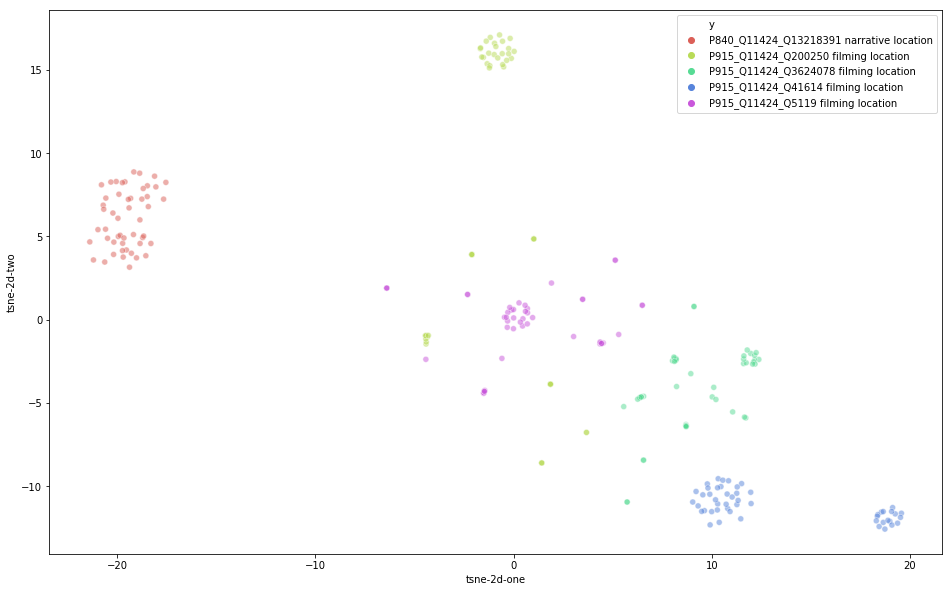

In [710]:
def tsne_vis_for_split():
    with open('data/analogy_dataset/split_middle_overlap/poccs.pickle', 'rb') as fin:
        split_poccs = pickle.load(fin)
    filter_set = ["P58", "P110", "P178", "P53", "P54", "P1884", "P682", "P823", "P1593", "P967", "P26", "P22", "P344", "P2554", "P1040"]
    filter_set = None
    #filter_set = list(load_tsv_as_dict('data/analogy_dataset/easy_sibling_split_onlysplit/label2ind.txt').keys())
    #shuffle(filter_set)
    #filter_set = filter_set[:15]
    filter_set = ['P840_Q11424_Q13218391', 'P915_Q11424_Q5119', 
                  'P915_Q11424_Q41614', 'P915_Q11424_Q3624078',
                  'P915_Q11424_Q200250']
    tsne_vis(split_poccs, pca_dim=50, top=50, y_map=None, filter_set=filter_set, use_split=False)
tsne_vis_for_split()


In [579]:
def get_easy_siblings(data_dir, emb, emb_id2ind, subprops, 
                      subtrees, is_sibling, is_parent, not_easy=False, sim='cosine',
                      only_split=False):
    # collect all pids in subtrees
    all_pids_intree = set()
    for subtree in subtrees:
        all_pids_intree.update(subtree.nodes)
    print('{} prop in trees'.format(len(all_pids_intree)))
    
    # keep pids splited (last two layers)
    all_pids = [pid for pid in all_pids_intree if pid.find('_') != -1]
    all_pids += list(set([pid.split('_', 1)[0] for pid in all_pids]))
    
    # keep pids with embeddings
    all_pids = [pid for pid in all_pids_intree if pid in emb_id2ind]
    print('{} prop considered'.format(len(all_pids)))
    
    emb_for_prop = np.array([emb[emb_id2ind[pid]] for pid in all_pids], dtype=np.float32)
    c2p = dict((c, p) for p, c in is_parent)
    p2c = dict((p[0], c) for p, c in subprops)
    
    # calculate similarity
    if sim == 'euc':
        psim = -euclidean_distances(emb_for_prop, emb_for_prop)
    elif sim == 'cosine':
        psim = cosine_similarity(emb_for_prop, emb_for_prop)
    else:
        raise NotImplemented
    for i in range(len(all_pids)):
        psim[i, i] = -1000
    psim_max = np.argmax(psim, axis=1)
    
    if not_easy:
        # select properties whose nearest neighbors are not siblings
        hard_siblings = []
        for i in range(len(all_pids)):
            this_pid = all_pids[i]
            if this_pid not in c2p:  # skip root properties
                continue
            if len(p2c[c2p[this_pid]]) <= 1:  # skip singletons
                continue
            hard = True
            for j in np.argsort(-psim[i])[:10]:
                if (this_pid, all_pids[j]) in is_sibling:
                    hard = False
            if hard:
                hard_siblings.append(this_pid)
        
        # get test
        train_prop, test_prop = set(), set()
        for this_pid in hard_siblings:
            print(pid2plabel_(this_pid))
            test_prop.add(this_pid)
    else:
        # get nearest siblings
        easy_siblings = []
        for i in range(len(all_pids)):
            this_pid = all_pids[i]
            if only_split and this_pid.find('_') == -1:
                continue
            nearest_pid = all_pids[psim_max[i]]
            psim_between = psim[i, psim_max[i]]
            if (this_pid, nearest_pid) in is_sibling:
                easy_siblings.append((this_pid, nearest_pid, psim_between))

        # split train/test
        train_prop, test_prop = set(), set()
        easy_siblings = sorted(easy_siblings, key=lambda x: -x[-1])
        for this_pid, nearest_pid, psim_between in easy_siblings:
            if this_pid not in train_prop and nearest_pid not in test_prop:
                print((pid2plabel_(this_pid), pid2plabel_(nearest_pid)))
                test_prop.add(this_pid)
                train_prop.add(nearest_pid)

    # enlarge the train set by siblings in the test set
    for pid in test_prop:
        for other_pid in all_pids:
            if other_pid in test_prop or (other_pid, pid) not in is_sibling:
                continue
            train_prop.add(other_pid)
    train_prop = list(train_prop)
    
    # split test into dev and test for learning-based methods
    test_prop = list(test_prop)
    shuffle(test_prop)
    dev_prop = test_prop[:len(test_prop) // 2]
    test_prop = test_prop[len(test_prop) // 2:]
    
    # save
    for split in ['train', 'dev', 'test']:
        print('#{}: {}'.format(split, len(eval(split + '_prop'))))
        with open(os.path.join(data_dir, '{}.prop'.format(split)), 'w') as fout:
            for p in eval(split + '_prop'):
                fout.write('{}\t{}\n'.format(p, pid2plabel_(p)))
    parents = set([c2p[p] for p in train_prop + dev_prop + test_prop])
    print('#parents: {}'.format(len(parents)))
    with open(os.path.join(data_dir, 'label2ind.txt'), 'w') as fout:
        for i, p in enumerate(parents):
            fout.write('{}\t{}\n'.format(p, i))

In [580]:
get_easy_siblings('data/analogy_dataset/easy_sibling_split_test', emb_small, emb_id2ind_small,
                  subprops_split, subtrees_split, is_sibling_split, is_parent_split,
                  not_easy=False, sim='euc', only_split=True)

3214 prop in trees
2975 prop considered
('plaintiff', 'plaintiff')
('plaintiff', 'plaintiff')
('plaintiff', 'plaintiff')
('solves', 'solves')
('solves', 'solves')
('produced by', 'produced by')
('target', 'target')
('plaintiff', 'plaintiff')
('Deutsche Bahn station category', 'Deutsche Bahn station category')
('undercarriage', 'undercarriage')
('emulates', 'emulates')
('disjoint union of', 'disjoint union of')
('plaintiff', 'plaintiff')
('plaintiff', 'plaintiff')
('plaintiff', 'plaintiff')
('solves', 'solves')
('source of energy', 'source of energy')
('school district', 'school district')
('cause of destruction', 'cause of destruction')
('island of location  (DEPRECATED)', 'island of location  (DEPRECATED)')
('copyright holder', 'copyright holder')
('produced by', 'produced by')
('plaintiff', 'plaintiff')
('incarnation of', 'incarnation of')
('end cause', 'end cause')
('solves', 'solves')
('copyright holder', 'copyright holder')
('end cause', 'end cause')
('plaintiff', 'plaintiff')
('i

#train: 1532
#dev: 362
#test: 363
#parents: 183


In [439]:
get_easy_siblings('data/analogy_dataset/easy_sibling_test', 
                  subprops, subtrees, is_sibling, is_parent, 
                  not_easy=False, sim='euc')

593 prop in trees
350 prop considered
('substrate of', 'medical condition treated')
('anatomical branch of', 'has anatomical branch')
('MediaWiki hooks used', 'binding of software library')
('manner of', 'circle of')
('this zoological name is coordinate with', 'stereoisomer of')
('workshop of', 'circle of')
('combination classification', 'stage classification')
('start point', 'destination point')
('list of characters', 'list of episodes')
('fabrication method', 'item operated')
('category for people who died here', 'category of associated people')
('best sprinter classification', 'stage classification')
('has grammatical case', 'has tense')
('film crew member', 'musical conductor')
('general classification of race participants', 'stage classification')
('fastest lap', 'pole position')
('excavation director', 'circle of')
('partner', 'professional or sports partner')
('has grammatical mood', 'has tense')
('has effect', 'immediate cause of')
('published in', 'found in taxon')
('film edi

In [584]:
def test_split_easy_sibling(data_dir, split, po):
    split_poccs = os.path.join(data_dir, po)
    with open(split_poccs, 'rb') as fin:
        split_poccs = pickle.load(fin)
    test_overlap(data_dir,  emb_small, emb_id2ind_small,
                 split, split_poccs, top=100, method='avg', only_prop_emb=False, 
                 detect_cheat=False, use_minus=False, evaluation=is_parent_split, sigma=1.0,
                 filter_num_poccs=None, filter_pids=None)
test_split_easy_sibling('data/analogy_dataset/easy_sibling_split_overlap_onlysplit/', 
                        ['test.prop'], 'poccs.pickle')


#words in emb: 602306


363it [00:00, 417132.15it/s]
183it [00:00, 456879.54it/s]

#entities in property occs: 95680, 95680 have embs
#property: 363 #label: 183
[]



0.7493112947658402 0.8317848766181091 363
[]
['P84_Q1339195_Q5', 'P1620_Q2334719_Q327333', 'P3781_Q28885102_Q679692', 'P6_Q702842_Q5', 'P1464_Q35657_Q4167836', 'P30_Q749622_Q82794', 'P408_Q7889_Q62505', 'P2596_Q579418_Q28171280', 'P618_Q39715_Q1293220', 'P1419_Q3305213_Q', 'P4345_Q23413_Q5', 'P618_Q10519294_Q1293220', 'P725_Q17517379_Q5', 'P1885_Q3146899_Q120560', 'P4324_Q33937_Q5', 'P2505_Q12042110_Q561431', 'P2184_Q1852859_Q17524420', 'P658_Q1242743_Q7366', 'P404_Q7889_Q1971694', 'P452_Q210167_Q268592', 'P3300_Q47467768_Q5', 'P4552_Q46831_Q1437459', 'P2517_Q2003221_Q4167836', 'P832_Q3624078_Q375011', 'P3966_Q28922885_Q188267', 'P1885_Q18917976_Q2977', 'P3876_Q15936437_Q4167836', 'P3931_Q30017383_Q1107679', 'P3161_Q5774287_Q184932', 'P1158_Q14927600_Q3624078', 'P178_Q7889_Q210167', 'P5053_Q9233_Q5', 'P4043_Q341_Q17444171', 'P3858_Q15079663_Q11753321', 'P2596_Q1747829_Q28171280', 'P3764_Q7994_Q5', 'P4614_Q355304_Q166620', 'P35_Q171441_Q5', 'P149_Q108325_Q32880', 'P4675_Q15711870_Q1652

In [49]:
def plot_comp(gold, pred):
    vg, vp, lg = [], [], []
    pred = dict(pred)
    for k, v in gold:
        vg.append(v)
        lg.append(k)
        vp.append(pred[k] if k in pred else 0)
    p1 = plt.bar(range(len(vg)), vg)
    p2 = plt.bar(range(len(vp)), vp)
    plt.xlabel('classes')
    plt.ylabel('#test relation for each class')
    plt.xticks(range(len(vg)), lg, rotation=90)
    plt.legend((p1[0], p2[0]), ('total', 'correct'))
    plt.show()

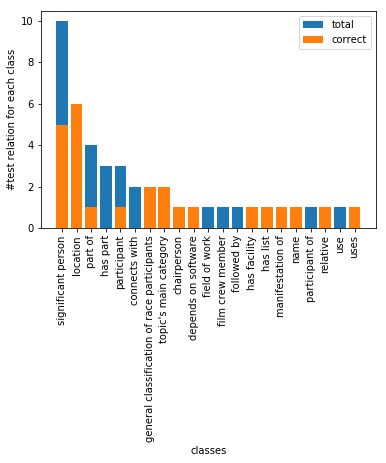

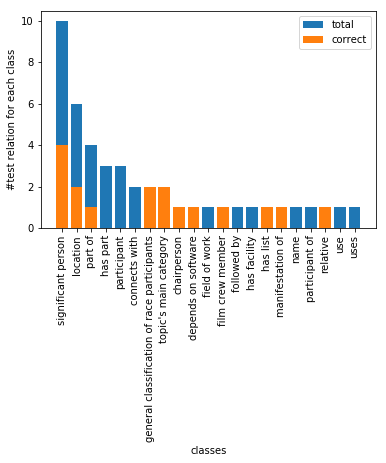

In [61]:
def run():
    gold = [('significant person', 10), ('location', 6), ('part of', 4), 
     ('has part', 3), ('participant', 3), ('connects with', 2), 
     ('general classification of race participants', 2), ("topic's main category", 2), 
     ('chairperson', 1), ('depends on software', 1), ('field of work', 1), 
     ('film crew member', 1), ('followed by', 1), ('has facility', 1), 
     ('has list', 1), ('manifestation of', 1), ('name', 1), ('participant of', 1),
     ('relative', 1), ('use', 1), ('uses', 1)]
    pred1 = [('location', 6), ('significant person', 5), 
             ('general classification of race participants', 2), ("topic's main category", 2), 
             ('chairperson', 1), ('depends on software', 1), ('has facility', 1), 
             ('has list', 1), ('manifestation of', 1), ('name', 1), ('part of', 1), 
             ('participant', 1), ('relative', 1), ('uses', 1)]
    pred2 = [('significant person', 4), ('general classification of race participants', 2), 
             ('location', 2), ("topic's main category", 2), ('chairperson', 1), 
             ('depends on software', 1), ('film crew member', 1), ('has list', 1),
             ('manifestation of', 1), ('part of', 1), ('relative', 1)]
    plot_comp(gold, pred1)
    plot_comp(gold, pred2)
run()

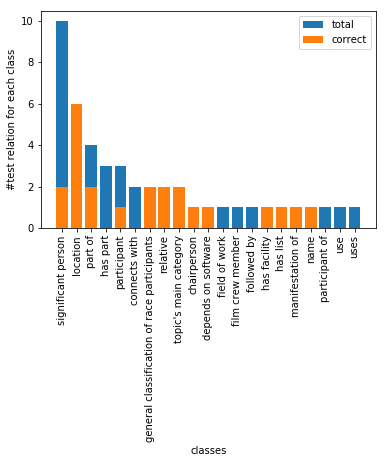

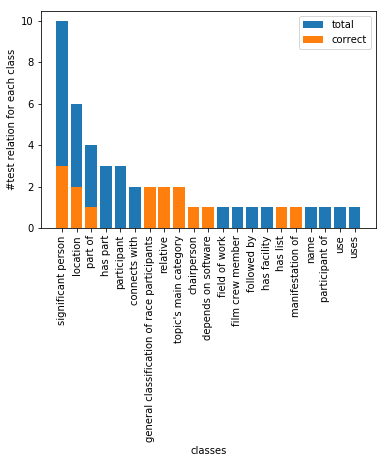

In [56]:
def run():
    gold = [('significant person', 10), ('location', 6), ('part of', 4), ('has part', 3), 
('participant', 3), ('connects with', 2), ('general classification of race participants', 2),
 ('relative', 2), ("topic's main category", 2), ('chairperson', 1), ('depends on software', 1),
  ('field of work', 1), ('film crew member', 1), ('followed by', 1), ('has facility', 1),
   ('has list', 1), ('manifestation of', 1), ('name', 1), ('participant of', 1),
    ('use', 1), ('uses', 1)]
    pred1 = [('location', 6), ('general classification of race participants', 2),
             ('part of', 2), ('relative', 2), ('significant person', 2), 
             ("topic's main category", 2), ('chairperson', 1), ('depends on software', 1),
             ('has facility', 1), ('has list', 1), ('manifestation of', 1), ('name', 1),
             ('participant', 1)]
    pred2 = [('significant person', 3), 
             ('general classification of race participants', 2), 
             ('location', 2), ('relative', 2), ("topic's main category", 2), 
             ('chairperson', 1), ('depends on software', 1), ('has list', 1), 
             ('manifestation of', 1), ('part of', 1)]
    plot_comp(gold, pred1)
    plot_comp(gold, pred2)
run()

In [663]:
def make_hard_split(method='min'):
    p2c: Dict[str, List] = defaultdict(set)
    for (pid, plable), c in subprops_split:
        if pid.find('_') != -1:
            p2c[pid.split('_')[0]].add(pid)
    
    long_tail_ol_count, head_ol_count = 0, 0
    p2hardest: Dict[str, str] = {}
    for parent, childs in p2c.items():
        this_group = [parent] + list(childs)
        emb_for_this_group = np.array([emb_small[emb_id2ind_small[pid]] for pid in this_group], dtype=np.float32)
        sim = cosine_similarity(emb_for_this_group, emb_for_this_group)
        sim = np.mean(sim, axis=1)
        if method == 'min':
            outlier = this_group[np.argmin(sim)]
        elif method == 'middle':
            outlier = this_group[np.argsort(sim)[len(sim)//2]]
        elif method.startswith('top_'):
            top_m = min(int(method.split('_', 1)[1]), len(sim))
            outlier = this_group[np.argsort(sim)[top_m]]
        else:
            raise NotImplemented
        p2hardest[parent] = outlier
        if outlier == parent:
            long_tail_ol_count += 1
        else:
            head_ol_count += 1
        #print('{} outlier is {}'.format(parent, outlier))

    print('longtail outlier {}, head outlier {}'.format(long_tail_ol_count, head_ol_count))
    return p2hardest

def replace_data_dir_by_hard_split(data_dir, out_dir, method):
    p2hardest = make_hard_split(method)
    train_p = set(load_tsv_as_dict(os.path.join(data_dir, 'train.prop')).keys())
    dev_p = set(load_tsv_as_dict(os.path.join(data_dir, 'dev.prop')).keys())
    test_p = set(load_tsv_as_dict(os.path.join(data_dir, 'test.prop')).keys())
    labels = set(load_tsv_as_dict(os.path.join(data_dir, 'label2ind.txt')).keys())
    all_p2split: Dict[str, set] = {}
    for split in [train_p, dev_p, test_p]:
        for p in split:
            all_p2split[p] = split
    
    rep_count = 0
    for p, h in p2hardest.items():
        if p not in labels or h not in all_p2split:
            continue
        labels.remove(p)
        labels.add(h)
        all_p2split[h].remove(h)
        all_p2split[h].add(p)
        rep_count += 1
    print('replace count: {}'.format(rep_count))
    
    # build is parent
    is_parent = set()
    for l in labels:
        for p in train_p | dev_p | test_p:
            if l.split('_')[0] == p.split('_')[0]:
                is_parent.add((l, p))
    with open(os.path.join(out_dir, 'is_parent.pickle'), 'wb') as fout: 
        pickle.dump(is_parent, fout)
        
    # save subprop
    subprop: Dict[str, List] = defaultdict(list)
    for p, c in is_parent:
        subprop[p].append(c)
    parents = set(subprop.keys())
    for _, c in is_parent:
        if c not in subprop:
            subprop[c] = []
    
    #os.makedirs(out_dir)
    with open(os.path.join(out_dir, 'train.prop'), 'w') as fout:
        for i, p in enumerate(train_p):
            fout.write('{}\t{}\n'.format(p, i))
    with open(os.path.join(out_dir, 'dev.prop'), 'w') as fout:
        for i, p in enumerate(dev_p):
            fout.write('{}\t{}\n'.format(p, i))
    with open(os.path.join(out_dir, 'test.prop'), 'w') as fout:
        for i, p in enumerate(test_p):
            fout.write('{}\t{}\n'.format(p, i))
    with open(os.path.join(out_dir, 'label2ind.txt'), 'w') as fout:
        for i, p in enumerate(labels):
            fout.write('{}\t{}\n'.format(p, i))
    with open(os.path.join(out_dir, 'subprops'), 'w') as fout:
        for k, v in subprop.items():
            fout.write('{},{}\t{}\n'.format(
                k, pid2plabel_(k), '\t'.join(['{},{}'.format(c, pid2plabel_(c)) for c in v])))

In [664]:
replace_data_dir_by_hard_split('data/analogy_dataset/split_test_small/', 
                               'data/analogy_dataset/split_test_small_middle_replace/',
                              method='middle')



0it [00:00, ?it/s]
1581it [00:00, 296379.49it/s]
0it [00:00, ?it/s]
520it [00:00, 220529.63it/s]
0it [00:00, ?it/s]
520it [00:00, 204657.79it/s]
0it [00:00, ?it/s]
246it [00:00, 200934.52it/s]

longtail outlier 22, head outlier 224
replace count: 224


In [34]:
def read_tbow_file(filename):
    result: List[List[Tuple[int, int]]] = []
    with open(filename, 'r') as fin:
        for l in fin:
            l = l.strip()
            if l == '':
                result.append([])
            else:
                result.append(list(map(lambda x: tuple(map(int, x.split(' '))), l.split('\t'))))
    return result

In [743]:
class EmbModel(nn.Module):
    def __init__(self, emb, num_class, num_anc_class=0,
                 input_size=400, hidden_size=128, padding_idx=None, dropout=0.0, 
                 only_prop=False, use_label=False, vocab_size=None, tbow_emb_size=None, 
                 word_emb=None, only_tbow=False):
        super(EmbModel, self).__init__()
        self.padding_idx = padding_idx
        self.hidden_size = hidden_size
        self.emb = nn.Embedding.from_pretrained(
            torch.tensor(emb).float(), freeze=True, padding_idx=padding_idx)
        self.only_prop = only_prop
        self.only_tbow = only_tbow
        self.num_anc_class = num_anc_class
        if only_prop:
            input_size //= 2
        self.use_label = use_label
        if use_label:
            self.ff = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                #nn.Dropout(p=dropout),
                #nn.Linear(hidden_size, hidden_size),
                #nn.ReLU()
            )
            self.label_ff = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                #nn.Dropout(p=dropout),
                #nn.Linear(hidden_size, hidden_size),
                #nn.ReLU()
            )
        else:
            self.ff = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(p=dropout)
            )
            self.pred_ff = nn.Linear(hidden_size, num_class)
            if num_anc_class:
                self.anc_pref_ff = nn.Linear(hidden_size, num_anc_class)
        if vocab_size:
            if word_emb is not None:
                self.tbow_emb = nn.Embedding.from_pretrained(
                    torch.tensor(word_emb).float(), freeze=True, padding_idx=padding_idx)
            else:
                self.tbow_emb = nn.Embedding(vocab_size, tbow_emb_size, padding_idx=padding_idx)
            #self.tbow_emb_gate = nn.Embedding(vocab_size, 1, padding_idx=padding_idx)
            self.tbow_key_ff = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(input_size - tbow_emb_size, 128),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.Linear(128, 64),
                nn.BatchNorm1d(64)
            )
            self.tbow_value_ff = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(tbow_emb_size, 128),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.Linear(128, 64),
                nn.BatchNorm1d(64)
            )
    
    def avg_emb(self, ind):
        # SHAPE: (batch_size, num_occs)
        ind_mask = ind.ne(self.padding_idx)
        ind_emb = self.emb(ind).sum(1) / ind_mask.sum(1).unsqueeze(-1).float()
        return ind_emb
    
    def combine_tbow_emb(self, tbow_ind, tbow_count, key_emb):
        # SHAPE: (batch_size, num_words)
        tbow_mask = tbow_ind.ne(self.padding_idx)
        tbow_count = tbow_count.float()
        tbow_count = tbow_count / (tbow_count.sum(-1, keepdim=True) + 1e-10)
        tbow_emb = self.tbow_emb(tbow_ind)
        
        '''
        #tbow_emb = tbow_emb * nn.Sigmoid()(self.tbow_emb_gate(tbow_ind))
        bs, nw = tbow_emb.size()[:2]
        # SHAPE: (batch_size, emb_dim)
        key_emb =  self.tbow_key_ff(key_emb)
        # SHAPE: (batch_size, num_words, emb_dim)
        value_emb = self.tbow_value_ff(tbow_emb.view(bs * nw, -1)).view(bs, nw, -1)
        gate = nn.Sigmoid()((value_emb * key_emb.unsqueeze(1)).sum(-1))
        tbow_emb = tbow_emb * gate.unsqueeze(-1)
        '''
        
        #tbow_emb = (tbow_emb * tbow_count.float().unsqueeze(-1)).sum(1)
        tbow_emb = tbow_emb.sum(1)
        return tbow_emb
        
    def forward(self, head, tail, labels, 
                label_head=None, label_tail=None, tbow_ind=None, tbow_count=None, anc_labels=None):
        # SHAPE: (batch_size, emb_dim)
        head_emb, tail_emb = self.avg_emb(head), self.avg_emb(tail)
        if self.use_label:
            # SHAPE: (num_class, emb_dim)
            label_head_emb, label_tail_emb = self.avg_emb(label_head), self.avg_emb(label_tail)
            
        if self.only_prop:
            emb = head_emb
            if self.use_label:
                label_emb = label_head_emb
        else:
            emb = torch.cat([head_emb, tail_emb], -1)
            if self.use_label:
                label_emb = torch.cat([label_head_emb, label_tail_emb], -1)
            
        if tbow_ind is not None and tbow_count is not None:
            tbow_emb = self.combine_tbow_emb(tbow_ind, tbow_count, emb)
            if self.only_tbow:
                emb = tbow_emb
            else:
                emb = torch.cat([emb, tbow_emb], -1)
        
        pred_repr = self.ff(emb)
        
        if self.use_label:
            #U, S, V = torch.svd(label_emb)
            #label_emb = U[:, :self.hidden_size]
            # SHAPE: (num_class, hidden_size)
            label_emb = self.label_ff(label_emb)
            # SHAPE: (batch_size, num_class)
            logits = torch.mm(pred_repr, label_emb.t())
            '''
            logits = torch.mm(emb, label_emb.t())
            logits /= emb.norm(dim=1, keepdim=True)
            logits /= label_emb.norm(dim=1).unsqueeze(0)
            '''
        else:
            logits = self.pred_ff(pred_repr)
            if self.num_anc_class:
                anc_logits = self.anc_pref_ff(pred_repr)
        
        loss = nn.CrossEntropyLoss()(logits, labels)
        if self.num_anc_class:
            anc_loss = nn.CrossEntropyLoss()(anc_logits, anc_labels)
            loss = loss + anc_loss
        return logits, loss

In [744]:
def get_prop_emb_ind(batch, emb_id2ind):
    return torch.tensor([[emb_id2ind[b[0][0]]] for b in batch]).long()
def get_occ_emb_ind(batch, emb_id2ind, num_occs, pos=0, batch_filter=None):
    batch2filter: Dict[int, set] = defaultdict(set)
    if batch_filter:
        for b in range(len(batch_filter)):
            for h, t in batch_filter[b][0][1]:
                batch2filter[b].add((h, t))
    return torch.tensor([[emb_id2ind[b[0][1][i][pos]] 
                          if (i < len(b[0][1]) and tuple(b[0][1][i]) not in batch2filter[bid]) else 0
                          for i in range(num_occs)] for bid, b in enumerate(batch)]).long()
def get_tbow_ind(batch, max_num=0):
    word_ind_tensor = torch.tensor([[b[i][0] if i < len(b) else 0 for i in range(max_num)] for b in batch])
    word_count_tensor = torch.tensor([[b[i][1] if i < len(b) else 0 for i in range(max_num)] for b in batch])
    return word_ind_tensor, word_count_tensor
        
def data2tensor(batch, emb_id2ind, only_prop=False, num_occs=10, device=None, 
                label_samples=None, use_tbow=0, use_anc=False, num_occs_label=10):
    if use_tbow:
        batch, tbow_batch = zip(*batch)
    
    label_head = label_tail = None
    if only_prop:
        head = get_prop_emb_ind(batch, emb_id2ind).to(device)
        tail = head
        if label_samples is not None:
            label_head = get_prop_emb_ind(label_samples, emb_id2ind).to(device)
            label_tail = label_head
    else:
        head = get_occ_emb_ind(batch, emb_id2ind, num_occs, pos=0).to(device)
        tail = get_occ_emb_ind(batch, emb_id2ind, num_occs, pos=1).to(device)
        if label_samples is not None:
            label_head = get_occ_emb_ind(
                label_samples, emb_id2ind, num_occs_label, pos=0, batch_filter=batch).to(device)
            label_tail = get_occ_emb_ind(
                label_samples, emb_id2ind, num_occs_label, pos=1, batch_filter=batch).to(device)
    
    if use_anc:
        labels = torch.tensor([b[1][0] for b in batch]).long().to(device)
        anc_labels = torch.tensor([b[1][1] for b in batch]).long().to(device)
    else:
        labels = torch.tensor([b[1] for b in batch]).long().to(device)
        anc_labels = None
    
    tbow_ind = tbow_count = None
    if use_tbow:
        tbow_ind, tbow_count = get_tbow_ind(tbow_batch, max_num=use_tbow)
        tbow_ind = tbow_ind.to(device)
        tbow_count = tbow_count.to(device)
    
    return head, tail, labels, label_head, label_tail, tbow_ind, tbow_count, anc_labels

def one_epoch(model, optimizer, samples, batch_size, emb_id2ind, 
              num_occs, device, only_prop, is_train, label_samples=None, 
              use_tbow=0, use_anc=False, num_occs_label=0):
    if is_train:
        model.train()
        shuffle(samples)
    else:
        model.eval()
    
    loss_li = []
    pred_li = []
    pred_label_li = []
    for batch in range(0, len(samples), batch_size):
        batch = samples[batch:batch + batch_size]
        head, tail, labels, label_head, label_tail, tbow_ind, tbow_count, anc_labels = data2tensor(
            batch, emb_id2ind, only_prop=only_prop, num_occs=num_occs, device=device, 
            label_samples=label_samples, use_tbow=use_tbow, use_anc=use_anc, num_occs_label=num_occs_label)
        logits, loss = model(head, tail, labels, label_head, label_tail, tbow_ind, tbow_count, anc_labels)
        if is_train and loss.requires_grad:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        loss_li.append(loss.item())
        if use_tbow:
            pred_li.extend([(b[0][0][0], logits[i].detach().cpu().numpy(), labels[i].item())
                            for i, b in enumerate(batch)])
        else:
            pred_li.extend([(b[0][0], logits[i].detach().cpu().numpy(), labels[i].item())
                            for i, b in enumerate(batch)])
        pred_label_li.extend([np.argmax(logits[i].detach().cpu().numpy()) for i, b in enumerate(batch)])
    
    return loss_li, pred_li, pred_label_li
    
def run_emb_train(data_dir, emb_file, subprop_file, use_label=False, filter_leaves=False, only_test_on=None,
                  epoch=10, input_size=400, batch_size=128, use_cuda=False, early_stop=None,
                  num_occs=10, num_occs_label=10, hidden_size=128, dropout=0.0, lr=0.001, only_prop=False, 
                  use_tbow=0, tbow_emb_size=50, word_emb_file=None, only_tbow=False, 
                  renew_word_emb=False, output_pred=False, use_ancestor=False, filter_labels=False, 
                  acc_topk=1):
    subprops = read_subprop_file(subprop_file)
    pid2plabel = get_pid2plabel(subprops)
    subtrees, _ = get_all_subtree(subprops)
    is_parent = get_is_parent(subprops)
    is_ancestor = get_is_ancestor(subtrees)
    leaves = get_leaves(subtrees)
    pid2parent = dict([(c, p) for p, c in is_parent])
    
    emb_id2ind, emb = read_embeddings_from_text_file(
        emb_file, debug=False, emb_size=200, use_padding=True, first_line=False)
    
    train_samples = read_nway_file(os.path.join(data_dir, 'train.nway'))
    dev_samples = read_nway_file(os.path.join(data_dir, 'dev.nway'))
    test_samples = read_nway_file(os.path.join(data_dir, 'test.nway'))
    print('#train, #dev, #test {}, {}, {}'.format(len(train_samples), len(dev_samples), len(test_samples)))
    
    label2ind = load_tsv_as_dict(os.path.join(data_dir, 'label2ind.txt'), valuefunc=int)
    ind2label = dict((v, k) for k, v in label2ind.items())
    
    train_labels = set(s[1] for s in train_samples)
    test_labels = set(s[1] for s in test_samples)
    join_labels = train_labels & test_labels
    print('#labels in train & test {}'.format(len(join_labels)))
    
    anc2ind: Dict[str, int] = defaultdict(lambda: len(anc2ind))
    if use_ancestor: 
        def get_anc_label(parent_label):
            parent_label = ind2label[parent_label]
            if parent_label in pid2parent:
                return anc2ind[pid2parent[parent_label]]
            else:
                return anc2ind['NO_ANC']

        train_samples = [((pid, poccs), (plabel, get_anc_label(plabel))) for (pid, poccs), plabel in train_samples]
        dev_samples = [((pid, poccs), (plabel, get_anc_label(plabel))) for (pid, poccs), plabel in dev_samples]
        test_samples = [((pid, poccs), (plabel, get_anc_label(plabel))) for (pid, poccs), plabel in test_samples] 
    print('#ancestor {}'.format(len(anc2ind)))
    
    train_samples_tbow = dev_samples_tbow = test_samples_tbow = None
    vocab_size = None
    word_emb = None
    if use_tbow:
        train_samples_tbow = read_tbow_file(os.path.join(data_dir, 'train.tbow.sling_filter'))
        assert len(train_samples_tbow) == len(train_samples)
        train_samples = list(zip(train_samples, train_samples_tbow))
        
        dev_samples_tbow = read_tbow_file(os.path.join(data_dir, 'dev.tbow.sling_filter'))
        assert len(dev_samples_tbow) == len(dev_samples)
        dev_samples = list(zip(dev_samples, dev_samples_tbow))
        
        test_samples_tbow = read_tbow_file(os.path.join(data_dir, 'test.tbow.sling_filter'))
        assert len(test_samples_tbow) == len(test_samples)
        test_samples = list(zip(test_samples, test_samples_tbow))
        
        if word_emb_file:
            word_emb_id2ind, word_emb = read_embeddings_from_text_file(
                word_emb_file, debug=False, emb_size=50, first_line=False, use_padding=True, split_char=' ')
            vocab_size = len(word_emb_id2ind)
            if renew_word_emb:
                word_emb = None
        else:
            vocab_size = len(load_tsv_as_dict(os.path.join(data_dir, 'tbow.vocab')))
        print('vocab size {}'.format(vocab_size))
    
    if filter_leaves:
        print('filter leaves')
        filter_pids = set(leaves)
        if use_tbow:
            train_samples = [s for s in train_samples if s[0][0][0] not in filter_pids]
            dev_samples = [s for s in dev_samples if s[0][0][0] not in filter_pids]
            test_samples = [s for s in test_samples if s[0][0][0] not in filter_pids]
        else:
            train_samples = [s for s in train_samples if s[0][0] not in filter_pids]
            dev_samples = [s for s in dev_samples if s[0][0] not in filter_pids]
            test_samples = [s for s in test_samples if s[0][0] not in filter_pids]
    
    if filter_labels:
        print('filter labels')
        if use_tbow:
            train_samples = [s for s in train_samples if s[0][1] in join_labels]
            dev_samples = [s for s in dev_samples if s[0][1] in join_labels]
            test_samples = [s for s in test_samples if s[0][1] in join_labels]
        else:
            train_samples = [s for s in train_samples if s[1] in join_labels]
            dev_samples = [s for s in dev_samples if s[1] in join_labels]
            test_samples = [s for s in test_samples if s[1] in join_labels]
            
    
    if only_test_on:
        if use_tbow:
            test_samples = [s for s in test_samples if s[0][0][0] in only_test_on]
        else:
            test_samples = [s for s in test_samples if s[0][0] in only_test_on]
    
    if use_label:
        label_samples = read_nway_file(os.path.join(data_dir, 'label2occs.nway'))
        label_samples_dict: Dict[int, List] = defaultdict(list)
        for (pid, occs), l in label_samples:
            label_samples_dict[l].extend(occs)
        label_samples = [((ind2label[l], label_samples_dict[l]), l) for l in sorted(label_samples_dict.keys())]
    else:
        label_samples = None
    
    if use_cuda:
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    
    emb_model = EmbModel(emb, len(label2ind), len(anc2ind), input_size=input_size, 
                         hidden_size=hidden_size, padding_idx=0, 
                         dropout=dropout, only_prop=only_prop, 
                         use_label=use_label, 
                         vocab_size=vocab_size, tbow_emb_size=tbow_emb_size, 
                         word_emb=word_emb, only_tbow=only_tbow)
    emb_model.to(device)
    optimizer = torch.optim.Adam(emb_model.parameters(), lr=lr)
    
    last_metric, last_count = None, 0
    for e in range(epoch):
        # train
        train_loss, train_pred, _ = one_epoch(
            emb_model, optimizer, train_samples, batch_size, 
            emb_id2ind, num_occs, device, only_prop, is_train=True,
            label_samples=label_samples, use_tbow=use_tbow, use_anc=use_ancestor, 
            num_occs_label=num_occs_label)
        # dev
        dev_loss, dev_pred, _ = one_epoch(
            emb_model, optimizer, dev_samples, batch_size, 
            emb_id2ind, num_occs, device, only_prop, is_train=False, 
            label_samples=label_samples, use_tbow=use_tbow, use_anc=use_ancestor, 
            num_occs_label=num_occs_label)
        # test
        test_loss, test_pred, _ = one_epoch(
            emb_model, optimizer, test_samples, batch_size, 
            emb_id2ind, num_occs, device, only_prop, is_train=False, 
            label_samples=label_samples, use_tbow=use_tbow, use_anc=use_ancestor, 
            num_occs_label=num_occs_label)
        
        train_metric, train_ranks, train_pred_label, _ = accuracy_nway(train_pred, ind2label=ind2label, topk=acc_topk)
        dev_metric, dev_ranks, dev_pred_label, _ = accuracy_nway(dev_pred, ind2label=ind2label, topk=acc_topk)
        test_metric, test_ranks, test_pred_label, _ = accuracy_nway(test_pred, ind2label=ind2label, topk=acc_topk)
        
        print('train: {:>.3f}, {:>.3f} dev: {:>.3f}, {:>.3f} test: {:>.3f}, {:>.3f}'.format(
            np.mean(train_loss), train_metric, 
            np.mean(dev_loss), dev_metric, 
            np.mean(test_loss), test_metric))
        
        if early_stop and last_metric and last_metric > dev_metric:
            last_count += 1
            if last_count >= early_stop:
                print('early stop')
                break
        last_metric = dev_metric
    
    test_ranks = get_ranks(test_ranks, is_parent=is_parent, is_ancestor=is_ancestor)
    dev_ranks = get_ranks(dev_ranks, is_parent=is_parent, is_ancestor=is_ancestor)
    train_ranks = get_ranks(train_ranks, is_parent=is_parent, is_ancestor=is_ancestor)
    rank_to_csv(test_ranks, 'ranks.csv', key2name=pid2plabel)
    if output_pred:
        for fn in ['train', 'dev', 'test']:
            with open(os.path.join(data_dir, fn + '.pred'), 'w') as fout:
                for pl in eval('{}_pred_label'.format(fn)):
                    fout.write('{}\n'.format(pl))
    return test_ranks, dev_ranks, train_ranks

def analyze_tbow(data_dir, subprop_file, word_emb_file, ranks, use_dev=False, filter=False):
    train_samples = read_nway_file(os.path.join(data_dir, 'train.nway'))
    dev_samples = read_nway_file(os.path.join(data_dir, 'dev.nway'))
    test_samples = read_nway_file(os.path.join(data_dir, 'test.nway'))
    
    train_samples_tbow = read_tbow_file(os.path.join(data_dir, 'train.tbow'))
    assert len(train_samples_tbow) == len(train_samples)
    train_samples = list(zip(train_samples, train_samples_tbow))
    dev_samples_tbow = read_tbow_file(os.path.join(data_dir, 'dev.tbow'))
    assert len(dev_samples_tbow) == len(dev_samples)
    dev_samples = list(zip(dev_samples, dev_samples_tbow))
    test_samples_tbow = read_tbow_file(os.path.join(data_dir, 'test.tbow'))
    assert len(test_samples_tbow) == len(test_samples)
    test_samples = list(zip(test_samples, test_samples_tbow))
    
    label2ind = load_tsv_as_dict(os.path.join(data_dir, 'label2ind.txt'), valuefunc=int)
    ind2label = dict((v, k) for k, v in label2ind.items())
    
    subprops = read_subprop_file(subprop_file)
    pid2plabel = get_pid2plabel(subprops)
    
    if word_emb_file:
        word_emb_id2ind, word_emb = read_embeddings_from_text_file(
            word_emb_file, debug=False, emb_size=50, first_line=False, use_padding=True, split_char=' ')
    else:
        word_emb_id2ind = load_tsv_as_dict(os.path.join(data_dir, 'tbow.vocab'))
    word_emb_ind2id = dict((v, k) for k, v in word_emb_id2ind.items())
    
    similar_lables = set()
    for q, rank in ranks.items():
        predict_parent = rank[0][0]
        real_parent = None
        for d in rank:
            if d[2] == 'parent':
                real_parent = d[0]
                break
        if predict_parent != real_parent:
           similar_lables.add((predict_parent, real_parent)) 
    
    flat_similar_labels = set()
    for p1, p2 in similar_lables:
        flat_similar_labels.add(p1)
        flat_similar_labels.add(p2)
    
    train_pid2tbow: Dict[str, Dict[int, int]] = defaultdict(lambda: defaultdict(lambda: 0))
    test_pid2tbow: Dict[str, Dict[int, int]] = defaultdict(lambda: defaultdict(lambda: 0))
    for sam, sam_tbow in train_samples:
        (pid, poccs), plabel = sam
        plabel = ind2label[plabel]
        if plabel in flat_similar_labels:
            for word, count in sam_tbow:
                train_pid2tbow[plabel][word] += count
    for sam, sam_tbow in dev_samples if use_dev else test_samples:
        (pid, poccs), plabel = sam
        plabel = ind2label[plabel]
        if plabel in flat_similar_labels:
            for word, count in sam_tbow:
                test_pid2tbow[plabel][word] += count
    
    top_feature = set()
    print('totally {} similar label pairs'.format(len(similar_lables)))
    has_dist_feat = 0
    train_pid2distfeat: Dict[str, set] = defaultdict(set)
    test_pid2distfeat: Dict[str, set] = defaultdict(set)
    for p1, p2 in similar_lables:
        train_dist_feat: Dict[int, int] = {}
        test_dist_feat: Dict[int, int] = {}
        
        for w, c in list(train_pid2tbow[p1].items()) + list(train_pid2tbow[p2].items()):
            #if train_pid2tbow[p1][w] == 0 or train_pid2tbow[p2][w] == 0:
            train_dist_feat[w] = abs(train_pid2tbow[p1][w] - train_pid2tbow[p2][w])
        for w, c in list(test_pid2tbow[p1].items()) + list(test_pid2tbow[p2].items()):
            #if test_pid2tbow[p1][w] == 0 or test_pid2tbow[p2][w] == 0:
            test_dist_feat[w] = abs(test_pid2tbow[p1][w] - test_pid2tbow[p2][w])
        
        train_dist_feat = sorted(train_dist_feat.items(), key=lambda x: -x[1])[:10]
        test_dist_feat = sorted(test_dist_feat.items(), key=lambda x: -x[1])[:10]
        join = set(map(itemgetter(0), train_dist_feat)) & set(map(itemgetter(0), test_dist_feat))
        
        top_feature.update([f[0] for f in test_dist_feat][:1])
            
        train_pid2distfeat[p1].update([w for w in join if train_pid2tbow[p1][w] > train_pid2tbow[p2][w]])
        train_pid2distfeat[p2].update([w for w in join if train_pid2tbow[p2][w] > train_pid2tbow[p1][w]])
        test_pid2distfeat[p1].update([w for w in join if train_pid2tbow[p1][w] > train_pid2tbow[p2][w]])
        test_pid2distfeat[p2].update([w for w in join if train_pid2tbow[p2][w] > train_pid2tbow[p1][w]])
        
        if len(join) > 0:
            has_dist_feat += 1
            print(pid2plabel[p1] + '\t' + pid2plabel[p2])
            print(list(map(lambda x: (word_emb_ind2id[x[0]], x[1]), train_dist_feat)))
            print(list(map(lambda x: (word_emb_ind2id[x[0]], x[1]), test_dist_feat)))
            print(list(map(lambda x: word_emb_ind2id[x], join)))
            print()
    print('totally {} similar label pairs have distinguish features'.format(has_dist_feat))
    
    if filter:
        print('filter features')
        for fn in ['train.tbow', 'dev.tbow', 'test.tbow']:

            if fn == 'train.tbow':
                pid2distfeat = train_pid2distfeat
                samples = train_samples
            elif fn == 'dev.tbow':
                pid2distfeat = train_pid2distfeat
                samples = dev_samples
            elif fn == 'test.tbow':
                pid2distfeat = test_pid2distfeat
                samples = test_samples

            with open(os.path.join(data_dir, fn + '.sling_filter'), 'w') as fout:
                for ((pid, poccs), plabel), feats in samples:
                    plabel = ind2label[plabel]
                    first = True
                    for w, c in feats:
                        #if plabel not in pid2distfeat or w not in pid2distfeat[plabel]:
                        #    continue
                        if w not in top_feature:
                            continue
                        if not first:
                            fout.write('\t')
                        fout.write('{} {}'.format(w, c))
                        first = False
                    fout.write('\n')

def analyze_kg_tbow(data_dir, subprop_file, emb_file, subgraph_file, ranks, 
                    filter=False, use_dev=False, use_pred_file=False):
    train_samples = read_nway_file(os.path.join(data_dir, 'train.nway'))
    dev_samples = read_nway_file(os.path.join(data_dir, 'dev.nway'))
    test_samples = read_nway_file(os.path.join(data_dir, 'test.nway'))
    
    label2ind = load_tsv_as_dict(os.path.join(data_dir, 'label2ind.txt'), valuefunc=int)
    ind2label = dict((v, k) for k, v in label2ind.items())
    
    with open('data/split_merge_triples/property_occurrence_prop580k_split_entityid2name.pkl', 'rb') as fin:
        entityid2name = pickle.load(fin)
    
    subprops = read_subprop_file(subprop_file)
    pid2plabel = get_pid2plabel(subprops)
    
    subgraph_dict = read_subgraph_file(subgraph_file)
    
    if emb_file:
        emb_id2ind, emb = read_embeddings_from_text_file(
            emb_file, debug=False, emb_size=200, use_padding=True)
    else:
        emb_id2ind = load_tsv_as_dict(os.path.join(data_dir, 'tbow.vocab'))
    emb_ind2id = dict((v, k) for k, v in emb_id2ind.items())
    
    #pid2pids = pid_pairs(emb_file, subprop_file, topk=50)
    
    print('#ranks {}'.format(len(ranks)))
    similar_lables = set()
    pred2real: Dict[str, set] = defaultdict(set)
    real2pred: Dict[str, set] = defaultdict(set)
    for q, rank in ranks.items():
        predict_parent = rank[0][0]
        real_parent = None
        for d in rank:
            if d[2] == 'parent':
                real_parent = d[0]
                break
        if predict_parent != real_parent:
            similar_lables.add((predict_parent, real_parent))
            pred2real[predict_parent].add(real_parent)
            real2pred[real_parent].add(predict_parent)
    
    flat_similar_labels = set()
    for p1, p2 in similar_lables:
        flat_similar_labels.add(p1)
        flat_similar_labels.add(p2)
    
    train_pid2tbow: Dict[str, Dict[int, int]] = defaultdict(lambda: defaultdict(lambda: 0))
    test_pid2tbow: Dict[str, Dict[int, int]] = defaultdict(lambda: defaultdict(lambda: 0))
    for pid2tbow, samples in [(train_pid2tbow, train_samples), 
                              (test_pid2tbow, dev_samples if use_dev else test_samples)]:
        for (pid, poccs), plabel in samples:
            plabel = ind2label[plabel]
            if plabel not in flat_similar_labels:
                continue
            for hid, tid in poccs:
                for e1, r, e2 in subgraph_dict[hid]:
                    is_same_prop = r == pid or r.split('_')[0] == pid.split('_')[0]
                    if is_same_prop:
                        continue
                    if e2 == tid and is_same_prop:
                        continue
                    pid2tbow[plabel][r] += 1
                    pid2tbow[plabel][e2] += 1
                for e1, r, e2 in subgraph_dict[tid]:
                    is_same_prop = r == pid or r.split('_')[0] == pid.split('_')[0]
                    if is_same_prop:
                        continue
                    pid2tbow[plabel][r] += 1
                    pid2tbow[plabel][e2] += 1
    
    print('totally {} similar label pairs'.format(len(similar_lables)))
    has_dist_feat = 0
    train_pid2distfeat: Dict[str, set] = defaultdict(set)
    test_pid2distfeat: Dict[str, set] = defaultdict(set)
    for p1, p2 in similar_lables:
        train_dist_feat: Dict[int, int] = {}
        test_dist_feat: Dict[int, int] = {}
        
        for w, c in list(train_pid2tbow[p1].items()) + list(train_pid2tbow[p2].items()):
            #if train_pid2tbow[p1][w] == 0 or train_pid2tbow[p2][w] == 0:
            train_dist_feat[w] = abs(train_pid2tbow[p1][w] - train_pid2tbow[p2][w])
        for w, c in list(test_pid2tbow[p1].items()) + list(test_pid2tbow[p2].items()):
            #if test_pid2tbow[p1][w] == 0 or test_pid2tbow[p2][w] == 0:
            test_dist_feat[w] = abs(test_pid2tbow[p1][w] - test_pid2tbow[p2][w])
        
        train_dist_feat = sorted(train_dist_feat.items(), key=lambda x: -x[1])[:10]
        test_dist_feat = sorted(test_dist_feat.items(), key=lambda x: -x[1])[:10]
        #join = set(map(itemgetter(0), train_dist_feat)) & set(map(itemgetter(0), test_dist_feat))
        join = [w for w in set(map(itemgetter(0), train_dist_feat)) if w.startswith('P')]
        
        '''
        train_pid2distfeat[p1].update([w for w in join if train_pid2tbow[p1][w] > 0])
        train_pid2distfeat[p2].update([w for w in join if train_pid2tbow[p2][w] > 0])
        test_pid2distfeat[p1].update([w for w in join if test_pid2tbow[p1][w] > 0])
        test_pid2distfeat[p2].update([w for w in join if test_pid2tbow[p2][w] > 0])
        '''
        
        train_pid2distfeat[p1].update(join)
        train_pid2distfeat[p2].update(join)
        test_pid2distfeat[p1].update(join)
        test_pid2distfeat[p2].update(join)
        
        if len(join) > 0:
            has_dist_feat += 1
            print(pid2plabel[p1] + '\t' + pid2plabel[p2])
            print(train_dist_feat)
            print(test_dist_feat)
            print('---')
            print([pid2plabel[w] for w in join if w.startswith('P')])
            print([entityid2name[w] for w in join if w.startswith('Q')])
            print()
    print('totally {} similar label pairs have distinguish features'.format(has_dist_feat))
    
    if filter:
        print('filter features')
        for fn in ['train.kg_tbow', 'dev.kg_tbow', 'test.kg_tbow']:
            
            samples_pred = None
            if fn == 'train.kg_tbow':
                pid2distfeat = train_pid2distfeat
                samples = train_samples
                samples_tbow = read_tbow_file(os.path.join(data_dir, 'train.kg_tbow'))
            elif fn == 'dev.kg_tbow':
                pid2distfeat = train_pid2distfeat
                samples = dev_samples
                samples_tbow = read_tbow_file(os.path.join(data_dir, 'dev.kg_tbow'))
            elif fn == 'test.kg_tbow':
                pid2distfeat = test_pid2distfeat
                samples = test_samples
                samples_tbow = read_tbow_file(os.path.join(data_dir, 'test.kg_tbow'))
            if use_pred_file:
                samples_pred = [int(l) for l in load_tsv_as_list(
                    os.path.join(data_dir, fn.split('.', 1)[0] + '.pred'), split=False)]
                assert len(samples_pred) == len(samples)
            
            assert len(samples) == len(samples_tbow)
            print('#pids affected: {}'.format(len(pid2distfeat)))
            
            with open(os.path.join(data_dir, fn + '.filter'), 'w') as fout:
                for i, ((pid, poccs), plabel) in enumerate(samples):
                    plabel = ind2label[plabel]
                    plabels = [plabel]
                    if samples_pred:
                        pred_plabel = ind2label[samples_pred[i]]
                        if pred_plabel in pred2real:
                            #print('{} -> {}, {}'.format(
                            #    pid2plabel[pred_plabel], pid2plabel[plabel], [pid2plabel[p] for p in pred2real[pred_plabel]]))
                            plabels = list(pred2real[pred_plabel])
                    '''
                    if plabel not in pid2distfeat:
                        fout.write('\n')
                        continue
                    first = True
                    for w in pid2distfeat[plabel]:
                        w = emb_id2ind[w]
                        if not first:
                            fout.write('\t')
                        fout.write('{} {}'.format(w, 1))
                        first = False
                    fout.write('\n')
                    '''
                    feats = samples_tbow[i]
                    first = True
                    for j, (w, c) in enumerate(feats):
                        #if not emb_ind2id[w].startswith('P1444') and not emb_ind2id[w].startswith('P1427'):
                        #    continue
                        skip = True
                        for plabel in plabels:
                            if plabel in pid2distfeat and emb_ind2id[w] in pid2distfeat[plabel]:
                                skip = False
                                break
                        if skip:
                            continue
                        if not first:
                            fout.write('\t')
                        fout.write('{} {}'.format(w, 1))
                        first = False
                    fout.write('\n')
                    

In [746]:
only_test_on = {'P450_Q5_Q2133344Q5_Q18201623', 'P171', 'P451_Q22988604_Q842697Q15632617_Q15632617', 'P1346', 'P40_Q20643955_Q20643955Q20643955_Q20643955', 'P823_Q2895132_Q5Q554211_Q5', 'P3931_Q11424_Q5', 'P87_Q25379_Q5Q2743_Q5', 'P58_Q24862_Q5Q29168811_Q5', 'P2989_Q33742_Q3661855Q34770_Q128234', 'P3018_Q5926864_Q27995042Q628179_Q34918903', 'P607_Q5_Q1006311Q5_Q178561', 'P610_Q33837_Q8502Q46831_Q8502', 'P17', 'P22_Q726_Q10855242Q5_Q5', 'P57_Q7777570_Q5Q20667187_Q5', 'P840_Q7889_Q200250Q11424_Q3336843', 'P58_Q24862_Q5', 'P915_Q11424_Q41614Q11424_Q5119', 'P495_Q3305213_Q3624078Q11424_Q7270', 'P1366', 'P53_Q5_Q101352Q5_Q417175', 'P1885_Q18917976_Q56242250Q18917976_Q2977', 'P150_Q36784_Q6465Q7270_Q3539870', 'P54_Q5_Q847017Q5_Q13393265', 'P58_Q24862_Q5Q21191270_Q5', 'P4908', 'P27_Q5_Q28171280Q5_Q28171280', 'P450_Q5_Q2133344', 'P20_Q5_Q62049Q5_Q1549591', 'P26Q15632617_Q15632617', 'P3275_Q11424_Q5Q29168811_Q5', 'P1376_Q484170_Q184188Q5119_Q3624078', 'P57_Q7777570_Q5', 'P1811_Q11086742_Q13406463Q5398426_Q13406463', 'P161_Q229390_Q5Q11424_Q5', 'P157_Q20643955_Q20643955Q22988604_Q23015925', 'P54_Q5_Q847017Q5_Q13027888', 'P3275_Q11424_Q5Q202866_Q5', 'P20_Q5_Q62049', 'P157_Q20643955_Q20643955Q15632617_Q15632617', 'P1891_Q131569_Q1520223Q252550_Q3624078', 'P823_Q2895132_Q5Q1185865_Q5', 'P161_Q229390_Q5Q5398426_Q5', 'P57_Q7777570_Q5Q506240_Q5', 'P1376_Q484170_Q184188Q21518270_Q35657', 'P611_Q5_Q5135744Q160742_Q3355750', 'P20_Q5_Q62049Q5_Q515', 'P1923_Q27020041_Q6979593', 'P749_Q3550864_Q7315155Q4830453_Q4830453', 'P915_Q11424_Q41614Q11424_Q200250', 'P137', 'P166_Q5_Q17057554Q5_Q20006438', 'P463', 'P4552_Q8502_Q1061151Q23397_Q46831', 'P937_Q5_Q1520223Q5_Q21518270', 'P19_Q5_Q2264924Q5_Q3624078', 'P451_Q22988604_Q842697Q22989102_Q22988604', 'P3931_Q11424_Q5Q9135_Q4830453'}
_, _, _ = run_emb_train('data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ/', 
              '../pytorch_big_graph/emb/transe.txt', 
              'data/property_occurrence_prop580k_split/subprops_hard',
              use_label=False, filter_labels=True, filter_leaves=False, only_test_on=None,
              epoch=50, input_size=450, batch_size=128, use_cuda=False, early_stop=100,
              num_occs=10, num_occs_label=200, hidden_size=128, lr=0.001, dropout=0.5, only_prop=False, 
              use_tbow=5, tbow_emb_size=50, only_tbow=False, renew_word_emb=False, 
              output_pred=False, use_ancestor=False, acc_topk=1,
              #word_emb_file=None)
              word_emb_file='data/emb/glove.6B.50d.txt')
              #word_emb_file='../pytorch_big_graph/emb/transe.txt')


8709 props
107 subtree
avg depth: 2.7663551401869158
5499 isolated prop
load emb from cache ...


230it [00:00, 510148.03it/s]

#train, #dev, #test 4141, 1350, 1399
#labels in train & test 152
#ancestor 0
load emb from cache ...
vocab size 400001
filter labels


train: 5.261, 0.048 dev: 5.019, 0.169 test: 5.064, 0.158
train: 4.618, 0.176 dev: 4.410, 0.250 test: 4.516, 0.226
train: 3.936, 0.256 dev: 3.837, 0.317 test: 3.978, 0.257
train: 3.350, 0.323 dev: 3.315, 0.375 test: 3.512, 0.302
train: 2.853, 0.378 dev: 2.887, 0.437 test: 3.111, 0.354
train: 2.471, 0.450 dev: 2.548, 0.487 test: 2.793, 0.416
train: 2.156, 0.507 dev: 2.288, 0.544 test: 2.535, 0.473
train: 1.916, 0.554 dev: 2.092, 0.578 test: 2.348, 0.516
train: 1.721, 0.598 dev: 1.938, 0.586 test: 2.197, 0.534
train: 1.567, 0.621 dev: 1.823, 0.603 test: 2.073, 0.550
train: 1.424, 0.651 dev: 1.729, 0.605 test: 1.973, 0.570
train: 1.312, 0.657 dev: 1.649, 0.624 test: 1.899, 0.565
train: 1.229, 0.679 dev: 1.592, 0.631 test: 1.831, 0.586
train: 1.143, 0.700 dev: 1.543, 0.647 test: 1.778, 0.585
train: 1.061, 0.708 dev: 1.506, 0.644 test: 1.729, 0.599
train: 1.011, 0.724 dev: 1.477, 0.658 test: 1.701, 0.604
train: 0.950, 0.746 dev: 1.442, 0.644 test: 1.672, 0.614
train: 0.911, 0.763 dev: 1.420,

In [745]:
analyze_tbow('data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ/', 
             'data/property_occurrence_prop580k_split/subprops_hard',
             'data/emb/glove.6B.50d.txt', 
             dev_ranks, use_dev=True, filter=True)

230it [00:00, 564146.15it/s]


load emb from cache ...
totally 121 similar label pairs
developer_Q235557_Q1058914	software engine_Q7889_Q7397
[('microsoft', 6225), ('announced', 4630), ('office', 2995), ('nintendo', 2480), ('adobe', 2290), ('support', 1945), ('wii', 1905), ('2007', 1760), ('2010', 1660), ('2', 1520)]
[('announced', 1230), ('capcom', 850), ('games', 650), ('2', 610), ('2009', 575), ('1997', 525), ('ea', 495), ('xbox', 495), ('2005', 485), ('playing', 475)]
['2', 'announced']

connecting line_Q4663385_Q728937	station category
[('station', 2920), ('jr', 1255), ('line', 860), ('extended', 625), ('served', 620), ('tokyo', 475), ('london', 430), ('layout', 425), ('railway', 410), ('district', 390)]
[('station', 895), ('line', 765), ('london', 725), ('jr', 465), ('railway', 380), ('opened', 245), ('runs', 175), ('running', 170), ('extended', 150), ('stratford', 140)]
['station', 'london', 'extended', 'railway', 'line', 'jr']

stepparent	spouse_Q15632617_Q15632617
[('consort', 1330), ('marry', 510), ('son',

doctoral advisor_Q187685_Q5	student
[('student', 940), ('studied', 355), ('phd', 235), ('advisor', 205), ('john', 205), ('included', 170), ('ex', 170), ('worked', 160), ('career', 155), ('nobel', 150)]
[('student', 440), ('students', 225), ('university', 185), ('studied', 170), ('john', 130), ('phd', 120), ('advisor', 110), ('robert', 100), ('doctoral', 100), ('assistant', 90)]
['student', 'advisor', 'studied', 'phd', 'john']

part of the series_Q7889_Q7058673	published in_Q13442814_Q5633421
[('episode', 4365), ('linux', 1105), ('3', 950), ('2', 895), ('genesis', 805), ('serials', 800), ('iphone', 795), ('1', 745), ('2000', 615), ('4', 600)]
[('episode', 275), ('special', 75), ('film', 50), ('episodes', 50)]
['episode']

presenter_Q27308988_Q5	cast member_Q11424_Q5
[('starred', 1040), ('alongside', 865), ('film', 845), ('played', 765), ('appeared', 760), ('tv', 585), ('actor', 560), ('opposite', 545), ('portrayed', 455), ('disney', 455)]
[('doctor', 150), ('christmas', 65), ('role', 50

part of	industry
[('world', 3105), ('team', 2955), ('1', 2815), ('series', 2795), ('2', 2785), ('wiki', 2315), ('0', 2195), ('war', 2080), ('including', 1890), ('italy', 1875)]
[('italian', 20030), ('1', 15925), ('2', 13630), ('school', 12010), ('3', 10930), ('river', 9110), ('hauts', 8750), ('province', 8150), ('4', 7760), ('5', 7215)]
['2', '1']

native language_Q5_Q34770	language used
[('writer', 1675), ('speak', 1040), ('drama', 895), ('english', 855), ('starring', 810), ('playwright', 750), ('author', 745), ('french', 695), ('singer', 680), ('born', 670)]
[('english', 1084), ('french', 776), ('footballer', 496), ('player', 388), ('published', 324), ('france', 316), ('quebec', 312), ('belgium', 296), ('performed', 296), ('politician', 260)]
['english', 'french']

country of citizenship_Q5_Q1520223	work location_Q5_Q14770218
[('singer', 12645), ('born', 8825), ('minister', 8355), ('prime', 6355), ('2', 5395), ('british', 4850), ('1', 4685), ('australia', 4285), ('3', 3885), ('presid

In [735]:
analyze_kg_tbow('data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ/', 
             'data/property_occurrence_prop580k_split/subprops_hard',
             '../pytorch_big_graph/emb/transe.txt', 'data/subgraph/property_occurrence_prop580k_split.subgraph',
             dev_ranks, filter=True, use_dev=True, use_pred_file=True)

230it [00:00, 545947.89it/s]
22193it [00:00, 97507.95it/s]

load subgraphs ...


583654it [00:04, 119113.63it/s]


load emb from cache ...
#ranks 319
totally 121 similar label pairs
developer_Q235557_Q1058914	software engine_Q7889_Q7397
[('P355', 2562), ('P1056', 795), ('P800', 505), ('P17', 267), ('P127', 262), ('P277', 244), ('Q7397', 239), ('P414', 230), ('P159', 205), ('Q941594', 203)]
[('Q1406', 58), ('P400', 56), ('Q62505', 50), ('P178', 50), ('P306', 47), ('Q2660350', 40), ('P437', 38), ('P178_Q7889_Q210167', 38), ('Q210167', 33), ('P404_Q7889_Q1971694', 32)]
---
['subsidiary', 'product or material produced', 'country', 'notable work', 'headquarters location', 'programming language', 'stock exchange', 'owned by']
[]

connecting line_Q4663385_Q728937	station category
[('P2789', 1733), ('P197', 620), ('P131', 526), ('P31', 454), ('P17', 368), ('P137', 231), ('P559', 190), ('P930', 163), ('P1064', 134), ('Q1999572', 134)]
[('P2789', 191), ('P31', 147), ('P197', 106), ('P131', 101), ('P17', 84), ('P1192', 51), ('P559', 44), ('P1064', 44), ('Q1999572', 44), ('Q183', 41)]
---
['adjacent station', 

significant person	speaker_Q7979513_Q5
[('P40', 5677), ('P530', 1712), ('P3092', 1150), ('P106', 923), ('P463', 915), ('P31', 861), ('P1343', 555), ('P21', 532), ('Q30', 455), ('P150', 450)]
[('P106', 594), ('P185_Q5_Q5', 482), ('P463', 366), ('P161_Q7777570_Q5', 343), ('P180', 287), ('P31', 275), ('P21', 138), ('Q5', 138), ('P1412', 131), ('P1343', 131)]
---
['occupation', 'member of', 'described by source', 'film crew member', 'sex or gender', 'child', 'instance of', 'diplomatic relation', 'contains administrative territorial entity']
[]

narrative location_Q11424_Q13218391	filming location_Q11424_Q5119
[('P150', 5044), ('P190', 3892), ('P530', 2959), ('P47', 2707), ('P161_Q5398426_Q5', 2440), ('P2936', 1314), ('P463', 1255), ('P1441', 1234), ('P421', 999), ('P161_Q21191270_Q5', 991)]
[('P1445', 47550), ('P530', 3281), ('P463', 2261), ('P161_Q11424_Q5', 1524), ('P190', 1453), ('P47', 1370), ('P161_Q5398426_Q5', 967), ('P1343', 752), ('P206', 702), ('P150', 388)]
---
['member of', 'pr

award received_Q5_Q18328097	member of political party_Q5_Q23702035
[('P1346', 1182), ('P31', 1145), ('P106', 726), ('P355', 714), ('P1142', 568), ('P1411', 493), ('P17', 481), ('P161_Q11424_Q5', 462), ('Q15180', 432), ('Q5', 405)]
[('P1346', 9588), ('P106', 311), ('P31', 251), ('P463', 222), ('P1411', 155), ('P1142', 138), ('P69', 104), ('Q5', 101), ('P21', 100), ('Q142', 80)]
---
['subsidiary', 'occupation', 'winner', 'cast member_Q11424_Q5', 'country', 'instance of', 'nominated for', 'political ideology']
[]

highest point_Q6465_Q8502	mountain range_Q8502_Q46831
[('P530', 2493), ('P463', 1789), ('P150', 1581), ('P47', 953), ('P421', 339), ('Q51', 329), ('P17', 273), ('P31', 269), ('Q30', 229), ('P2852', 226)]
[('Q51', 257), ('P31', 219), ('P463', 184), ('P131', 176), ('P17', 170), ('P47', 142), ('Q46831', 134), ('P150', 127), ('Q21590062', 120), ('P530', 106)]
---
['member of', 'country', 'emergency phone number', 'located in time zone', 'shares border with', 'instance of', 'diplomat

place of birth_Q5_Q14784328	place of death_Q5_Q1187811
[('P530', 4667), ('P47', 1374), ('P190', 1354), ('P421', 826), ('P206', 494), ('P150', 337), ('P31', 269), ('P1376', 254), ('P1344', 248), ('P54_Q5_Q476028', 225)]
[('P530', 9050), ('P150', 2181), ('P463', 1988), ('P421', 741), ('P47', 639), ('P190', 533), ('P206', 409), ('P150_Q5119_Q123705', 297), ('Q30', 295), ('P2959', 225)]
---
['participant of', 'located in or next to body of water', 'located in time zone', 'twinned administrative body', 'shares border with', 'instance of', 'capital of', 'diplomatic relation', 'contains administrative territorial entity', 'member of sports team_Q5_Q476028']
[]

founded by_Q210167_Q5	has part
[('P190', 3281), ('P106', 946), ('P793', 735), ('P47', 364), ('Q5', 266), ('P21', 265), ('P206', 248), ('P463', 247), ('Q6581097', 243), ('P735_Q5_Q12308941', 241)]
[('P106', 277), ('P1552', 276), ('P2354', 196), ('P1343', 106), ('P31', 99), ('P21', 94), ('Q5', 94), ('Q6581097', 91), ('P1411', 89), ('P355

location	destination point_Q960739_Q5119
[('P530', 11631), ('P974', 7699), ('P463', 4621), ('P150', 4066), ('P47', 2812), ('P31', 2024), ('P190', 1889), ('P1343', 1281), ('P78', 770), ('P206', 666)]
[('P974', 3349), ('P190', 1276), ('P150', 607), ('P161_Q11424_Q5', 502), ('P463', 213), ('P106', 212), ('P1343', 185), ('Q739', 184), ('P166', 138), ('P150_Q5852411_Q55557858', 137)]
---
['member of', 'located in or next to body of water', 'tributary', 'described by source', 'twinned administrative body', 'shares border with', 'instance of', 'diplomatic relation', 'top-level Internet domain', 'contains administrative territorial entity']
[]

rector_Q875538_Q5	significant person
[('P40', 5677), ('P530', 1712), ('P106', 1177), ('P3092', 1150), ('P463', 989), ('P31', 972), ('P1343', 597), ('P21', 587), ('Q30', 489), ('P800', 470)]
[('P106', 545), ('P185_Q5_Q5', 481), ('P161_Q7777570_Q5', 343), ('P463', 274), ('P31', 189), ('P1412', 130), ('Q188', 107), ('P21', 100), ('Q5', 100), ('Q150', 98)]


screenwriter_Q29168811_Q5	director_Q20667187_Q5
[('P161_Q5398426_Q5', 1695), ('P106', 418), ('P800', 371), ('P161_Q229390_Q5', 346), ('P161_Q21191270_Q5', 327), ('P136', 318), ('P31', 255), ('P161_Q20667187_Q5', 232), ('P1411', 218), ('P57_Q5398426_Q5', 204)]
[('P161_Q5398426_Q5', 2547), ('P674', 214), ('P725_Q5398426_Q5', 132), ('P1411', 102), ('P106', 94), ('P58_Q5398426_Q5', 75), ('P161', 52), ('P449', 51), ('Q24862', 50), ('Q5398426', 50)]
---
['cast member_Q229390_Q5', 'occupation', 'notable work', 'director_Q5398426_Q5', 'cast member_Q5398426_Q5', 'cast member_Q20667187_Q5', 'instance of', 'genre', 'nominated for', 'cast member_Q21191270_Q5']
[]

child_Q15632617_Q15632617	father_Q20643955_Q20643955
[('P40', 15337), ('P451_Q1916821_Q22988604', 1968), ('P451', 1350), ('P451_Q22989102_Q22988604', 680), ('P1343', 300), ('P26', 215), ('P3373', 198), ('P2925', 151), ('P22', 107), ('P21', 103)]
[('P40', 1868), ('P40_Q22988604_Q22988604', 1685), ('P3373_Q5_Q5', 275), ('P31', 233), ('P134

ValueError: invalid literal for int() with base 10: 'P361'

In [7]:
def get_checkword():
    nlp = spacy.load('en_core_web_sm')
    stopwords = nlp.Defaults.stop_words
    word_pattern = re.compile('^[A-Za-z0-9]+$')
    def check_words(word):
        word = word.lower()
        if word in stopwords:
            return None
        if not word_pattern.match(word):
            return None
        return word
    #return check_words
    def filter_bow(words: Dict[str, int]):
        new_words: Dict[str, int] = {}
        for w, c in words.items():
            w = check_words(w)
            if w is not None:
                new_words[w] = c
        return new_words
    return filter_bow
filter_bow = get_checkword()

In [5]:
fewrel = FewRelDataset(datadir='data/fewrel/')

In [6]:
def prepare_bow_from_fewrel():
    pid2context = fewrel.build_pid2context(dist_thres=10, context_method='dep', max_num_sent=None)
    print('{} properties have context'.format(len(pid2context)))
    for pid, wd in pid2context.items():
        wd = filter_bow(wd)
        wd = sorted(wd.items(), key=lambda x: -x[1])
        print(pid, wd[:5], len(wd))
    return pid2context

In [ ]:
prepare_bow_from_fewrel()

0it [00:00, ?it/s]

Merpati flight 106 departed Jakarta ( CGK ) on a domestic flight to Tanjung Pandan ( TJQ ) .
TJQ
Tanjung Pandan
['appos_']

The name was at one point changed to Nottingham East Midlands Airport so as to include the name of the city that is supposedly most internationally recognisable , mainly due to the Robin Hood legend .
East Midlands Airport
Nottingham
['compound']

It is a four - level stack interchange near Fort Lauderdale - Hollywood International Airport in Fort Lauderdale , Florida .
Fort Lauderdale - Hollywood International Airport
Fort Lauderdale , Florida
['prep', 'in', 'pobj']

It is the main alternate of Jinnah International Airport in Karachi with a distance of about 350   km/220 miles ; well under an hour 's flight time in turboprop aircraft .
Jinnah International Airport
Karachi
['prep', 'in', 'pobj']

Nearby airports include Akwa Ibom Airport at Okobo and Margaret Ekpo International Airport in Calabar .
Margaret Ekpo International Airport
Calabar
['conj_', 'Okobo', 'po

In [150]:
pid2context_fewrel = prepare_bow_from_fewrel()

80it [05:18,  4.16s/it]

2074 out of 56000 sents have multi-span entities
80 properties have context
P931 [('pobj', 300), ('prep', 296), ('airport', 73), ('attr', 65), ('acl', 50)] 166
P4552 [('pobj', 423), ('prep', 420), ('attr', 84), ('appos', 41), ('compound', 29)] 172
P140 [('prep', 196), ('pobj', 196), ('amod', 171), ('attr', 129), ('compound', 98)] 402
P1923 [('pobj', 202), ('prep', 198), ('dobj', 100), ('nsubj', 59), ('played', 36)] 252
P150 [('pobj', 109), ('prep', 107), ('conj', 51), ('compound', 42), ('nsubj', 21)] 181
P6 [('nsubj', 103), ('pobj', 73), ('appos', 71), ('mayor', 60), ('prep', 47)] 189
P27 [('amod', 241), ('attr', 219), ('prep', 180), ('pobj', 180), ('compound', 109)] 401
P449 [('pobj', 241), ('prep', 219), ('compound', 174), ('poss', 113), ('nmod', 71)] 222
P1435 [('pobj', 516), ('prep', 513), ('attr', 59), ('added', 58), ('conj', 38)] 138
P175 [('pobj', 232), ('prep', 176), ('poss', 150), ('album', 145), ('nsubj', 104)] 227
P1344 [('prep', 364), ('pobj', 361), ('relcl', 149), ('compet

In [151]:
def prepare_bow_from_fewrel_todata(data_dir, subprop_file, pid2context, emb_file=None):
    # build context
    #pid2context = fewrel.build_pid2context(dist_thres=5, context_method='middle')
    print('{} properties have context'.format(len(pid2context)))
    for pid in pid2context:
        wd = pid2context[pid]
        wd = filter_bow(wd)
        wd = sorted(wd.items(), key=lambda x: -x[1])
        pid2context[pid] = wd
    
    if emb_file:
        emb_id2ind, emb = read_embeddings_from_text_file(
            emb_file, debug=False, emb_size=50, first_line=False, use_padding=True, split_char=' ')
    else:
        emb_id2ind = defaultdict(lambda: len(emb_id2ind))
        _ = emb_id2ind['<PAD>']
    
    # save to files
    train_samples = read_nway_file(os.path.join(data_dir, 'train.nway'))
    dev_samples = read_nway_file(os.path.join(data_dir, 'dev.nway'))
    test_samples = read_nway_file(os.path.join(data_dir, 'test.nway'))
    
    # get subprop
    subprops = read_subprop_file(subprop_file)
    pid2plabel = get_pid2plabel(subprops)
    subtrees, _ = get_all_subtree(subprops)
    is_parent = get_is_parent(subprops)
    is_ancestor = get_is_ancestor(subtrees)
    leaves = get_leaves(subtrees)
    #filter_pids = set(leaves)
    filter_pids = set()
    
    found_pid = set()
    fount_test_pid = set()
    found_words = set()
    all_words = set()
    for split in ['train', 'dev', 'test']:
        samples = eval(split + '_samples')
        bow_file = os.path.join(data_dir, split + '.tbow')
        with open(bow_file, 'w') as fout:
            for i, ((pid, poccs), plabel) in tqdm(enumerate(samples)):
                if pid in filter_pids:
                    continue
                npid = pid.split('_', 1)[0]
                if npid in pid2context:
                    found_pid.add(pid)
                    if split == 'test':
                        fount_test_pid.add(pid)
                    context = pid2context[npid]
                else:
                    context = []
                
                # write to file (use unk)
                # TODO: add unk in train
                first = True
                unk_count = 0
                for w, c in context:
                    all_words.add(w)
                    if split == 'train' and not emb_file:
                        _ = emb_id2ind[w]
                    if w in emb_id2ind:
                        found_words.add(w)
                        if not first:
                            fout.write('\t')
                        fout.write('{} {}'.format(emb_id2ind[w], c))
                        first = False
                    else:
                        unk_count += c
                if unk_count > 0:
                    if not first:
                        fout.write('\t')
                    fout.write('{} {}'.format(0, unk_count))  # use padding
                fout.write('\n')
    
    print('found {} pids {}, test {}'.format(len(found_pid), found_pid, fount_test_pid))
    print('found {} out of {}'.format(len(found_words), len(all_words)))
    if emb_file is None:
        with open(os.path.join(data_dir, 'tbow.vocab'), 'w') as fout:
            for w, i in emb_id2ind.items():
                fout.write('{}\t{}\n'.format(w, i))

In [152]:
prepare_bow_from_fewrel_todata(
    'data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ',
    'data/property_occurrence_prop580k_split/subprops_hard', pid2context_fewrel, 
    emb_file=None)

80 properties have context
8709 props
107 subtree
avg depth: 2.7663551401869158
5499 isolated prop


4141it [00:00, 12556.71it/s]
1350it [00:00, 14580.81it/s]
1399it [00:00, 11869.21it/s]

found 298 pids {'P355_Q18127_Q18127', 'P355_Q3918_Q3918', 'P105_Q16521_Q4389865', 'P178_Q209163_Q210167', 'P1923_Q16466010_Q847017', 'P178_Q235557_Q1058914', 'P6_Q262166_Q5', 'P27', 'P740_Q215380_Q1093829', 'P991_Q15283424_Q5', 'P4552_Q54050_Q46831', 'P1001_Q_Q43702', 'P6_Q257978_Q5', 'P86_Q207628_Q5', 'P1001_Q28525375_Q3624078', 'P937_Q5_Q2039348', 'P206', 'P102_Q5_Q233591', 'P937_Q5_Q200250', 'P27_Q5_Q43702', 'P6_Q7270_Q5', 'P59_Q327757_Q8928', 'P58_Q21191270_Q5', 'P355_Q15936437_Q4671277', 'P495_Q11424_Q3624078', 'P1001_Q4164871_Q3624078', 'P241_Q5_Q', 'P22_Q5_Q5', 'P1001_Q_Q3624078', 'P150_Q5852411_Q55558200', 'P991', 'P241_Q5_Q15142889', 'P57_Q21191270_Q5', 'P118', 'P1001_Q_Q1520223', 'P84_Q575759_Q5', 'P40_Q15632617_Q15632617', 'P25_Q22988604_Q22988604', 'P1923', 'P58_Q24862_Q5', 'P6_Q50337_Q5', 'P364', 'P4552_Q194408_Q46831', 'P937_Q5_Q1852859', 'P364_Q11424_Q661936', 'P495_Q20667187_Q1520223', 'P710', 'P4552_Q8072_Q1437459', 'P58_Q5398426_Q5', 'P241_Q5_Q4508', 'P84_Q1076486_Q43

In [8]:
wp_dataset = WikipediaDataset.from_entity2sent('data/textual/wikipedia_multi/')

load from data/textual/wikipedia_multi/ ...


In [26]:
def load_wikidata_name(filename, triple_file, out_file):
    id2name: Dict[str, List[str]] = {}
    entities = set()
    with open(triple_file, 'r') as fin:
        for l in tqdm_notebook(fin):
            s, r, o = l.strip().split('\t')
            entities.add(s)
            entities.add(o)
    with open(filename, 'r') as fin:
        for lc, line in tqdm_notebook(enumerate(fin), total=37899556):
            k, value = line[:-1].split('\t', 1)
            if k not in entities:
                continue
            value = value.split('\t')
            if len(value) == 2:
                name, aka = value
            else:
                name, aka, _ = value
            id2name[k] = [name] + aka.split('||')
    with open(out_file, 'wb') as fout:
        pickle.dump(dict(id2name), fout)

In [27]:
load_wikidata_name('data/hiro_wikidata/items.txt', 
                   'data/split_merge_triples/property_occurrence_prop580k_split.tsv', 
                   'data/split_merge_triples/property_occurrence_prop580k_split_entityid2name.pkl')


In [84]:
_ = wp_dataset.extend_entity2sent({'a': ['a', 'b']}, show_progress=True)


0it [00:00, ?it/s]
1it [00:16, 16.63s/it]
322it [00:16, 11.64s/it]
708it [00:16,  8.15s/it]
1001it [00:37,  5.73s/it]
1347it [00:37,  4.01s/it]
1657it [00:38,  2.81s/it]
2001it [00:54,  1.98s/it]
2360it [00:54,  1.39s/it]
2894it [00:54,  1.03it/s]
3130it [01:14,  1.42it/s]
3502it [01:14,  2.03it/s]
3857it [01:14,  2.90it/s]
4041it [01:35,  3.62it/s]
4417it [01:35,  5.17it/s]
4651it [01:35,  7.39it/s]
4967it [01:35, 10.54it/s]
5166it [01:58,  9.89it/s]
5461it [01:58, 14.11it/s]
5837it [01:58, 20.13it/s]
6011it [02:16, 15.33it/s]
6385it [02:16, 21.86it/s]
6720it [02:16, 31.15it/s]
7001it [02:33, 25.09it/s]
7370it [02:33, 35.74it/s]
7895it [02:33, 50.90it/s]
8131it [02:54, 24.31it/s]
8424it [02:54, 34.60it/s]
8724it [02:55, 49.18it/s]
9001it [03:16, 26.85it/s]
9321it [03:16, 38.21it/s]
9787it [03:16, 54.40it/s]
10001it [03:32, 28.29it/s]
10472it [03:32, 40.31it/s]
10910it [03:32, 57.36it/s]
11141it [03:52, 26.41it/s]
11493it [03:52, 37.60it/s]
11919it [03:52, 53.51it/s]
12116it [04:16, 2

KeyboardInterrupt: 

In [9]:
def get_context_for_one_prop(inp):
    pid2context = defaultdict(lambda: defaultdict(lambda: 0))
    pid, occs = inp
    shuffle(occs)
    occs = occs[:10]  # TODO debug
    hids, tids = zip(*occs)
    context = wp_dataset.get_coocc(hids, tids, context_method='dep', dist_thres=10, max_num_sent=10)
    #context = filter_bow(context)  # TODO debug
    context = sorted(context.items(), key=lambda x: -x[1])
    for w, c in context:
        pid2context[pid][w] += c

def property_level_bow(prop_occ_dir, data_dir, emb_file, subprop_file, num_workers=1, entityid2name_file=None):
    # collect all pids
    all_pids = set()
    all_pids |= set(load_tsv_as_dict(os.path.join(data_dir, 'train.prop')).keys())
    all_pids |= set(load_tsv_as_dict(os.path.join(data_dir, 'dev.prop')).keys())
    all_pids |= set(load_tsv_as_dict(os.path.join(data_dir, 'test.prop')).keys())
    print('totally {} pids'.format(len(all_pids)))
    
    # load entityid2name
    if entityid2name_file:
        with open(entityid2name_file, 'rb') as fin:
            entityid2name = pickle.load(fin)
    else:
        entityid2name = None
    
    #all_pids = set(list(all_pids)[:200])  # TODO debug
    
    # load property occurrences
    poccs = PropertyOccurrence.build(sorted(all_pids), prop_occ_dir)
    print('totally {} pids with occs'.format(len(poccs.pid2occs)))
    
    # find context
    start_time = time.time()
    pid2context: Dict[str, Dict[str, int]] = defaultdict(lambda: defaultdict(lambda: 0))
    
    '''
    with multiprocessing.Pool(num_workers) as pool:
        _ = pool.map(partial(get_context_for_one_prop), poccs.pid2occs.items())
    '''
    
    for pid, occs in tqdm_notebook(poccs.pid2occs.items()):
        shuffle(occs)
        occs = occs[:500]  # TODO debug
        hids, tids = zip(*occs)
        #entityname2id = entity_idname_conversion(
        #    dict((k, v) for k, v in entityid2name.items() if k in hids or k in tids))
        context = wp_dataset.get_coocc(hids, tids, context_method='middle', 
                                       dist_thres=10, max_num_sent=None, entityname2id=None, tokenize=False)  # TODO debug
        context = filter_bow(context)
        context = sorted(context.items(), key=lambda x: -x[1])
        for w, c in context:
            pid2context[pid][w] += c
    
    print('time_cost: {}'.format(time.time() - start_time))
    
    # remove low-frequence words
    pid2context = dict((pid, dict((w, c) for w, c in wd.items() if c >= 1)) for pid, wd in pid2context.items())
    pid2context = dict((pid, wd) for pid, wd in pid2context.items() if len(wd) > 0)
    
    subprops = read_subprop_file(subprop_file)
    pid2plabel = get_pid2plabel(subprops)
    
    # output
    print('{} out of {} properties have context'.format(len(set(pid2context)), len(set(poccs.pid2occs))))
    print('have: {}'.format(list(pid2context.keys())[:10]))
    print('not have: {}'.format(list(all_pids - set(pid2context.keys()))[:10]))
    for pid, wd in pid2context.items():
        print(pid2plabel[pid], sorted(wd.items(), key=lambda x: -x[1])[:5], len(wd))
    
    return pid2context
    
    
def property_level_bow_todata(pid2context, data_dir, subprop_file, emb_file=None, min_count=1):
    # remove low-frequency words
    pid2context = dict((pid, dict((w, c) for w, c in wd.items() if c >= min_count)) for pid, wd in pid2context.items())
    pid2context = dict((pid, wd) for pid, wd in pid2context.items() if len(wd) > 0)
    
    # sort words
    pid2context = dict((pid, sorted(wd.items(), key=lambda x: -x[1])) for pid, wd in pid2context.items())
    
    print('#pid with context {}'.format(len(pid2context)))
    
    if emb_file:
        # load embedding
        emb_id2ind, emb = read_embeddings_from_text_file(
            emb_file, debug=False, emb_size=50, first_line=False, use_padding=True, split_char=' ')
    else:
        emb_id2ind = defaultdict(lambda: len(emb_id2ind))
        _ = emb_id2ind['<PAD>']
    
    # save to files
    train_samples = read_nway_file(os.path.join(data_dir, 'train.nway'))
    dev_samples = read_nway_file(os.path.join(data_dir, 'dev.nway'))
    test_samples = read_nway_file(os.path.join(data_dir, 'test.nway'))
    
    subprops = read_subprop_file(subprop_file)
    pid2plabel = get_pid2plabel(subprops)
    
    # output pids in test set that have context
    print('pids in test set that have context')
    print(list(map(lambda x: pid2plabel[x], set(pid2context.keys()) & set(s[0][0] for s in test_samples))))
    
    found_words = set()
    all_words = set()
    for split in ['train', 'dev', 'test']:
        samples = eval(split + '_samples')
        bow_file = os.path.join(data_dir, split + '.tbow')
        with open(bow_file, 'w') as fout:
            for i, ((pid, poccs), plabel) in tqdm(enumerate(samples)):
                if pid in pid2context:
                    context = pid2context[pid]
                else:
                    context = []
                
                # write to file (use unk)
                # TODO: add unk in train
                first = True
                unk_count = 0
                for w, c in context:
                    all_words.add(w)
                    # add to vocab
                    if split == 'train' and emb_file is None:
                        _ = emb_id2ind[w]
                    # convert word to ind
                    if w in emb_id2ind:
                        found_words.add(w)
                        if not first:
                            fout.write('\t')
                        fout.write('{} {}'.format(emb_id2ind[w], c))
                        first = False
                    else:
                        unk_count += c
                # don't use padding
                '''
                if unk_count > 0:
                    if not first:
                        fout.write('\t')
                    fout.write('{} {}'.format(0, unk_count))  # use padding
                '''
                fout.write('\n')
    
    print('found {} out of {}'.format(len(found_words), len(all_words)))
    if emb_file is None:
        with open(os.path.join(data_dir, 'tbow.vocab'), 'w') as fout:
            for w, i in emb_id2ind.items():
                fout.write('{}\t{}\n'.format(w, i))


In [55]:
with open('data/split_merge_triples/property_occurrence_prop580k_split_entityid2name.pkl', 'rb') as fin:
    entityid2name = pickle.load(fin)
    entityname2id = entity_idname_conversion(entityid2name)

In [10]:
pid2context_word = property_level_bow(
    'data/property_occurrence_prop580k_split/', 
    'data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ/', 
    'data/emb/glove.6B.50d.txt', 
    'data/property_occurrence_prop580k_split/subprops_hard', num_workers=1, 
    entityid2name_file='data/split_merge_triples/property_occurrence_prop580k_split_entityid2name.pkl')

966it [00:00, 438400.53it/s]
319it [00:00, 452479.87it/s]
333it [00:00, 403554.82it/s]


totally 1618 pids


  2%|▏         | 25/1618 [00:00<00:06, 245.23it/s]

load property occurrences ...


100%|██████████| 1618/1618 [00:05<00:00, 280.92it/s]


totally 1618 pids with occs



time_cost: 197.1942319869995
848 out of 1618 properties have context
have: ['P1001', 'P1001_Q186516_Q3624078', 'P1001_Q294414_Q3624078', 'P1001_Q294414_Q5852411', 'P1001_Q37002670_Q3624078', 'P1001_Q4164871_Q202686', 'P1001_Q4164871_Q35657', 'P1001_Q4164871_Q3624078', 'P1001_Q476068_Q1520223', 'P1001_Q_Q3624078']
not have: ['P658_Q1997853_Q55850593', 'P1533_Q202444_Q1093580', 'P814', 'P1427_Q33951_Q515', 'P2522_Q53534649_Q20646670', 'P1072_Q7397_Q26085352', 'P5330_Q55488_Q', 'P4321_Q18415492_Q5', 'P1990_Q1509615_Q16521', 'P520_Q15056995_Q12800']
applies to jurisdiction [('n', 10), ('member', 8), ('served', 6), ('established', 4), ('elected', 4)] 155
applies to jurisdiction_Q186516_Q3624078 [('sisters', 1), ('include', 1), ('image', 1), ('found', 1), ('appeared', 1)] 11
applies to jurisdiction_Q294414_Q3624078 [('politician', 11), ('served', 10), ('n', 5), ('led', 3), ('ian', 2)] 101
applies to jurisdiction_Q294414_Q5852411 [('n', 1), ('politician', 1)] 2
applies to jurisdiction_Q37002

connecting line_Q55488_Q728937 [('kilometres', 19), ('services', 16), ('fremantle', 15), ('22', 4), ('south', 4)] 31
connecting line_Q928830_Q15079663 [('metro', 11), ('stations', 7), ('bidezabal', 7), ('station', 6), ('line', 6)] 71
connecting line_Q928830_Q728937 [('located', 9), ('rail', 7), ('kilometers', 7), ('line', 3), ('stations', 3)] 49
speaker [('labeled', 1), ('north', 1), ('korea', 1), ('mentioned', 1), ('gaius', 1)] 10
speaker_Q1185865_Q5 [('clinton', 3), ('senator', 2), ('officially', 2), ('nominated', 2), ('bill', 1)] 23
speaker_Q554211_Q5 [('president', 1)] 1
speaker_Q861911_Q5 [('speech', 11), ('delivered', 11), ('famous', 8), ('gave', 7), ('1956', 5)] 58
has cause [('causes', 28), ('caused', 28), ('s', 18), ('cause', 18), ('agent', 14)] 350
architect [('architect', 32), ('built', 8), ('dome', 7), ('designs', 6), ('designer', 6)] 186
narrative location [('described', 1), ('young', 1), ('member', 1), ('set', 1), ('n', 1)] 10
narrative location_Q11424_Q1093829 [('filmed'

In [48]:
pid2context = property_level_bow('data/property_occurrence_prop580k_split/', 
                   'data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ/', 
                   'data/emb/glove.6B.50d.txt', 
                   'data/property_occurrence_prop580k_split/subprops_hard', num_workers=1)

966it [00:00, 304181.51it/s]
319it [00:00, 302164.18it/s]
333it [00:00, 311903.36it/s]
  1%|▏         | 21/1618 [00:00<00:11, 134.32it/s]

totally 1618 pids
load property occurrences ...


  0%|          | 0/1618 [00:00<?, ?it/s]

totally 1618 pids with occs


100%|██████████| 1618/1618 [09:50<00:00,  2.74it/s] 


time_cost: 590.2480399608612
583 out of 1618 properties have context
have: ['P1001_Q186516_Q3624078', 'P1001_Q294414_Q3624078', 'P1001_Q37002670_Q3624078', 'P1001_Q4164871_Q35657', 'P1001_Q4164871_Q3624078', 'P1001_Q_Q3624078', 'P102_Q5_Q15811108', 'P102_Q5_Q233591', 'P102_Q5_Q23702035', 'P102_Q5_Q7278']
not have: ['P2632_Q5_Q3624078', 'P1072_Q860676_Q235557', 'P358', 'P1427_Q20646667_Q1549591', 'P1923_Q16466010_Q847017', 'P6_Q262166_Q5', 'P2596_Q_Q28171280', 'P2563_Q30147469_Q1047698', 'P1072_Q28050159_Q4167410', 'P5105_Q27996466_Q550637']
applies to jurisdiction_Q186516_Q3624078 [('prep', 2), ('pobj', 2), ('acl', 1), ('used', 1), ('in', 1)] 6
applies to jurisdiction_Q294414_Q3624078 [('prep', 20), ('pobj', 20), ('of', 19), ('Alfonsín', 1), ('conj', 1)] 11
applies to jurisdiction_Q37002670_Q3624078 [('prep', 10), ('pobj', 10), ('of', 9), ('in', 2), ('pobj_', 1)] 9
applies to jurisdiction_Q4164871_Q35657 [('prep', 6), ('pobj', 6), ('of', 5), ('state', 2), ('for', 1)] 5
applies to juris

director_Q7889_Q5 [('appos_', 10), ('prep_', 8), ('pobj_', 7), ('of', 6), ('director', 6)] 22
screenwriter [('appos_', 5), ('relcl_', 3), ('pobj_', 3), ('prep_', 3), ('by', 2)] 32
screenwriter_Q11424_Q5 [('pobj', 13), ('prep', 8), ('by', 7), ('appos_', 6), ('prep_', 6)] 40
screenwriter_Q20667187_Q5 [('relcl', 1), ('directed', 1), ('agent', 1), ('by', 1), ('pobj', 1)] 5
screenwriter_Q229390_Q5 [('pobj', 6), ('pobj_', 4), ('prep_', 4), ('by', 3), ('prep', 3)] 31
screenwriter_Q29168811_Q5 [('appos_', 12), ('prep_', 5), ('of', 4), ('conj_', 4), ('pobj_', 4)] 35
screenwriter_Q506240_Q5 [('pobj', 4), ('by', 3), ('agent', 2), ('prep', 2), ('appos_', 1)] 15
screenwriter_Q5398426_Q5 [('pobj_', 11), ('prep_', 11), ('pobj', 11), ('by', 8), ('nmod_', 7)] 49
constellation [('prep', 10), ('pobj', 10), ('in', 7), ('appos', 6), ('of', 3)] 13
constellation_Q523_Q8928 [('in', 8), ('prep', 6), ('pobj', 6), ('pobj_', 4), ('prep_', 4)] 26
head of government [('of', 9), ('pobj_', 8), ('prep_', 8), ('compoun

In [56]:
property_level_bow_todata(pid2context_word, 
                          'data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ/', 
                          'data/property_occurrence_prop580k_split/subprops_hard',
                          #None)
                          'data/emb/glove.6B.50d.txt', 
                          min_count=5)

#pid with context 353
load emb from cache ...


4141it [00:00, 247740.81it/s]
1350it [00:00, 237712.44it/s]
1399it [00:00, 215816.37it/s]

pids in test set that have context
['participating team', 'composer_Q9734_Q5', 'copyright holder_Q9135_Q4830453', 'list of episodes_Q5398426_Q13406463', 'killed by_Q22988604_Q23015925', 'home venue_Q476028_Q1076486', 'religious order_Q5_Q28653', 'architect_Q11303_Q5', 'parent organization_Q4830453_Q4830453', 'illustrator_Q571_Q5', 'constellation_Q523_Q8928', 'subsidiary', 'industry_Q17412622_Q268592', 'replaced by', 'medical condition treated_Q35456_Q18123741', 'member of', 'presenter_Q276_Q5', 'presenter_Q5398426_Q5', 'screenwriter_Q29168811_Q5', 'head of government_Q515_Q5', 'composer_Q5398426_Q5', 'highway system', 'cast member_Q5398426_Q5', 'operator', 'librettist_Q2743_Q5', 'place of birth', 'league_Q476028_Q15991303', 'composer', 'highest point_Q46831_Q8502', 'director_Q506240_Q5', 'member of sports team_Q5_Q13393265', 'killed by_Q15632617_Q15632617', 'conflict_Q5_Q178561', 'musical conductor_Q42998_Q5', 'after a work by_Q11424_Q5', 'spouse_Q15632617_Q15632617', 'parent taxon', '

In [34]:
def prepare_bow(data_dir, textual_dir):
    print('#sent {}, #entity {}\n'.format(len(wp_dataset.sid2sent), len(wp_dataset.entity2sid)))
    
    train_samples = read_nway_file(os.path.join(data_dir, 'train.nway'))
    dev_samples = read_nway_file(os.path.join(data_dir, 'dev.nway'))
    test_samples = read_nway_file(os.path.join(data_dir, 'test.nway'))
    #samples = train_samples + dev_samples + test_samples
    
    has_context, all_pids = [], []
    pid2context: Dict[str, Dict[str, int]] = defaultdict(lambda: defaultdict(lambda: 0))
    vocab: Dict[str, int] = defaultdict(lambda: len(vocab))
    _ = vocab['<PAD>']  # 0 is padding
    for split in ['train', 'dev', 'test']:
        samples = eval(split + '_samples')
        bow_file = os.path.join(data_dir, split + '.tbow')
        with open(bow_file, 'w') as fout:
            for i, ((pid, poccs), plabel) in tqdm(enumerate(samples)):
                hids, tids = zip(*poccs)
                context = wp_dataset.get_coocc(hids, tids, dist_thres=20)
                context = dict((k, v) for k, v in context.items() if v >= 3)
                context = filter_bow(context)
                context = sorted(context.items(), key=lambda x: -x[1])
                for w, c in context:
                    pid2context[pid][w] += c
                if len(context) > 0:
                    has_context.append(pid)
                all_pids.append(pid)
                
                # add to vocab
                if split == 'train':
                    for w, c in context:
                        _ = vocab[w]
                # write to file (use unk)
                # TODO: add unk in train
                first = True
                unk_count = 0
                for w, c in context:
                    if w in vocab:
                        if not first:
                            fout.write('\t')
                        fout.write('{} {}'.format(vocab[w], c))
                        first = False
                    else:
                        unk_count += c
                if unk_count > 0:
                    if not first:
                        fout.write('\t')
                    fout.write('{} {}'.format(vocab['<UNK>'], unk_count))
                fout.write('\n')
    
    print('vocab size {}'.format(len(vocab)))
    with open(os.path.join(data_dir, 'tbow.vocab'), 'w') as fout:
        for w, i in vocab.items():
            fout.write('{}\t{}\n'.format(w, i))
    
    print('{} samples have context out of {}'.format(
        len(has_context), len(train_samples) + len(dev_samples) + len(test_samples)))
    print('{} out of {} properties have context'.format(len(set(has_context)), len(set(all_pids))))
    print(np.unique(has_context, return_counts=True))
    
    for pid, wd in pid2context.items():
        print(pid, sorted(wd.items(), key=lambda x: -x[1])[:5], len(wd))
prepare_bow('data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ/', 
            'data/textual/wikipedia/')

23it [00:00, 226.44it/s]

#sent 3730505, #entity 217946



4141it [00:21, 193.27it/s]
1350it [00:06, 217.20it/s]
1399it [00:08, 171.27it/s]


vocab size 1489
863 samples have context out of 6890
368 out of 1618 properties have context
(array(['P1001', 'P1001_Q294414_Q3624078', 'P1001_Q37002670_Q3624078',
       'P1001_Q4164871_Q3624078', 'P102', 'P102_Q5_Q1030814',
       'P102_Q5_Q23702035', 'P102_Q5_Q766570', 'P103', 'P1040',
       'P1040_Q20667187_Q5', 'P1040_Q24862_Q5', 'P1056', 'P1066',
       'P1072_Q183197_Q235557', 'P1080', 'P1080_Q1094617_Q559618',
       'P1080_Q14514600_Q559618', 'P1080_Q14831768_Q559618',
       'P1080_Q15711870_Q559618', 'P1080_Q188784_Q559618',
       'P1080_Q6439708_Q559618', 'P1080_Q6498903_Q559618',
       'P108_Q5_Q4830453', 'P110', 'P110_Q571_Q5', 'P110_Q7725634_Q5',
       'P112', 'P112_Q15936437_Q5', 'P112_Q1762059_Q5', 'P112_Q18127_Q5',
       'P112_Q210167_Q5', 'P112_Q3918_Q5', 'P112_Q414147_Q5',
       'P112_Q43229_Q5', 'P112_Q48204_Q5', 'P112_Q4830453_Q5',
       'P112_Q7278_Q5', 'P114_Q46970_Q465909', 'P115',
       'P115_Q13393265_Q641226', 'P115_Q17156793_Q483110',
       'P115_Q

In [706]:
def get_parallel_prop(data_dir, subgraph_file, emb_file=None):
    subgraph_dict = read_subgraph_file(subgraph_file)
    
    train_samples = read_nway_file(os.path.join(data_dir, 'train.nway'))
    dev_samples = read_nway_file(os.path.join(data_dir, 'dev.nway'))
    test_samples = read_nway_file(os.path.join(data_dir, 'test.nway'))
    
    if emb_file:
        emb_id2ind, emb = read_embeddings_from_text_file(
            emb_file, debug=False, emb_size=200, use_padding=True)
    else:
        emb_id2ind = defaultdict(lambda: len(emb_id2ind))
        _ = emb_id2ind['<PAD>']
        
    for split in ['train', 'dev', 'test']:
        samples = eval(split + '_samples')
        bow_file = os.path.join(data_dir, split + '.kg_tbow')
        with open(bow_file, 'w') as fout:
            for i, ((pid, poccs), plabel) in tqdm(enumerate(samples)):
                para_props: Dict[str, int] = defaultdict(lambda: 0)
                for hid, tid in poccs:
                    '''
                    if hid in subgraph_dict:
                        for e1, r, e2 in subgraph_dict[hid]:
                            if e1 == hid and e2 == tid and r != pid:
                                para_props[emb_id2ind[r]] += 1
                                #para_props[r] += 1
                    '''
                    if tid in subgraph_dict:
                        for e1, r, e2 in subgraph_dict[tid]:
                            if e1 == tid and e2 == hid and r != pid:
                                #para_props[emb_id2ind[r]] += 1
                                para_props[r] += 1
                    
                para_props = sorted(para_props.items(), key=lambda x: -x[1])
                
                para_props = [(k, v) for k, v in para_props if v >= 3]
                
                fout.write('{}\n'.format('\t'.join(map(lambda x: '{} {}'.format(x[0], x[1]), para_props))))
    
    if not emb_file:
        print('vocab size {}'.format(len(vocab)))
        with open(os.path.join(data_dir, 'tbow.vocab'), 'w') as fout:
            for w, i in vocab.items():
                fout.write('{}\t{}\n'.format(w, i))    

In [707]:
get_parallel_prop('data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ/', 
                  'data/subgraph/property_occurrence_prop580k_split.subgraph', 
                  emb_file='../pytorch_big_graph/emb/transe.txt')

9552it [00:00, 95519.41it/s]

load subgraphs ...


583654it [00:04, 120292.60it/s]


load emb from cache ...


4141it [00:00, 26234.47it/s]
1350it [00:00, 26458.28it/s]
1399it [00:00, 25160.28it/s]


In [441]:
def get_neibour_in_kg(data_dir, subgraph_file, emb_file=None):
    subgraph_dict = read_subgraph_file(subgraph_file)
    
    train_samples = read_nway_file(os.path.join(data_dir, 'train.nway'))
    dev_samples = read_nway_file(os.path.join(data_dir, 'dev.nway'))
    test_samples = read_nway_file(os.path.join(data_dir, 'test.nway'))
    
    TOP_ENTITY_IDS = set(load_tsv_as_dict('data/entity_count_5000.tsv').keys())
    TOP_PROP_IDS = set(load_tsv_as_dict('data/property_count_200.tsv').keys())
    
    if emb_file:
        emb_id2ind, emb = read_embeddings_from_text_file(
            emb_file, debug=False, emb_size=200, use_padding=True)
    else:
        emb_id2ind = defaultdict(lambda: len(emb_id2ind))
        _ = emb_id2ind['<PAD>']
    
    for split in ['train', 'dev', 'test']:
        samples = eval(split + '_samples')
        bow_file = os.path.join(data_dir, split + '.kg_tbow' + ('' if emb_file else '.no_pretrain'))
        with open(bow_file, 'w') as fout:
            for i, ((pid, poccs), plabel) in tqdm(enumerate(samples)):
                nei: Dict[int, int] = defaultdict(lambda: 0)
                for hid, tid in poccs:
                    if hid in subgraph_dict:
                        for e1, r, e2 in subgraph_dict[hid]:
                            is_same_prop = r == pid or r.split('_')[0] == pid.split('_')[0]
                            if is_same_prop:
                                continue
                            #if e2 in TOP_ENTITY_IDS:
                                #nei[emb_id2ind[e2]] += 1
                                #nei[e2] += 1
                            #if r in TOP_PROP_IDS:
                            nei[emb_id2ind[r]] += 1
                            #nei[r] += 1
                    if tid in subgraph_dict:
                        for e1, r, e2 in subgraph_dict[tid]:
                            is_same_prop = r == pid or r.split('_')[0] == pid.split('_')[0]
                            if is_same_prop:
                                continue
                            #if e2 in TOP_ENTITY_IDS:
                                #nei[emb_id2ind[e2]] += 1
                                #nei[e2] += 1
                            #if r in TOP_PROP_IDS:
                            nei[emb_id2ind[r]] += 1
                            #nei[r] += 1
                nei = sorted(nei.items(), key=lambda x: -x[1])
                                
                fout.write('{}\n'.format('\t'.join(map(lambda x: '{} {}'.format(x[0], x[1]), nei))))
    
    if not emb_file:
        print('vocab size {}'.format(len(emb_id2ind)))
        with open(os.path.join(data_dir, 'tbow.vocab'), 'w') as fout:
            for w, i in emb_id2ind.items():
                fout.write('{}\t{}\n'.format(w, i))

In [442]:
get_neibour_in_kg('data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ/', 
                  'data/subgraph/property_occurrence_prop580k_split.subgraph', 
                  #emb_file='../pytorch_big_graph/emb/transe.txt')
                  emb_file=None)

21884it [00:00, 79709.39it/s]

load subgraphs ...


583654it [00:04, 143799.10it/s]
5000it [00:00, 859488.52it/s]
200it [00:00, 605238.67it/s]
4141it [00:01, 2383.74it/s]
1350it [00:00, 2389.63it/s]
1399it [00:00, 2178.15it/s]


vocab size 2779


In [40]:
pickle_dir = 'data/textual/wikipedia_multi'
entityid2name_file = 'data/split_merge_triples/property_occurrence_prop580k_split_entityid2name.pkl'

print('load data')
# load
with open(os.path.join(pickle_dir, 'entity2sid.pkl'), 'rb') as fin:
    entity2sid = pickle.load(fin)

with open(entityid2name_file, 'rb') as fin:
        entityid2name = pickle.load(fin)
entityname2id = entity_idname_conversion(entityid2name)

print('load ner')
lines = []
with open(os.path.join(pickle_dir, 'sent_ner.txt'), 'r') as fin:
    for l in fin:
        try:
            _ = int(l.strip().split('\t', 1)[0])
            lines.append(l)
        except:
            lines[-1] = lines[-1].rstrip('\n') + ' ' + l
print('total {} lines'.format(len(lines)))

load data
load ner
total 245557 lines


In [53]:
def test():
    '''
    pickle_dir = 'data/textual/wikipedia_multi'
    entityid2name_file = 'data/split_merge_triples/property_occurrence_prop580k_split_entityid2name.pkl'
    
    print('load data')
    # load
    with open(os.path.join(pickle_dir, 'entity2sid.pkl'), 'rb') as fin:
        entity2sid = pickle.load(fin)

    with open(entityid2name_file, 'rb') as fin:
            entityid2name = pickle.load(fin)
    entityname2id = entity_idname_conversion(entityid2name)
    
    print('load ner')
    lines = []
    with open(os.path.join(pickle_dir, 'sent_ner.txt'), 'r') as fin:
        for l in fin:
            try:
                _ = int(l.strip().split('\t', 1)[0])
                lines.append(l)
            except:
                lines[-1] = lines[-1].rstrip('\n') + ' ' + l
    print('total {} lines'.format(len(lines)))
    '''
    
    print('find more mentions')
    found_num = 0
    with open(os.path.join(pickle_dir, 'entity2sid.pkl'), 'rb') as fin:
        new_entity2sid = pickle.load(fin)
    print('deepcopy over')
    for l in lines:
        ls = l.strip().split('\t')
        if len(ls) != 1 and ((len(ls) - 1) % 4) != 0:
            continue
        sid = int(ls[0])
        for en in range((len(ls) - 1) // 4):
            ent_st, ent_ed, ent_label, ent_str = ls[en * 4 + 1:en * 4 + 4 + 1]
            ent_st, ent_ed = int(ent_st), int(ent_ed)
            eids = match_mention_entity(ent_str, entityname2id)
            for eid in eids:
                if eid in new_entity2sid and sid in new_entity2sid[eid] and (ent_st, ent_ed) in new_entity2sid[eid][sid]:
                    continue
                if eid not in new_entity2sid:
                    new_entity2sid[eid] = dict()
                if len(new_entity2sid[eid]) >= 10000:
                    continue
                if sid not in new_entity2sid[eid]:
                    new_entity2sid[eid][sid] = set()
                if type(new_entity2sid[eid][sid]) == list:
                    new_entity2sid[eid][sid] = set(new_entity2sid[eid][sid])
                new_entity2sid[eid][sid].add((ent_st, ent_ed))
                found_num += 1
    print('found {} mentions'.format(found_num))
    
    with open(os.path.join(pickle_dir, 'entity2sid_more.pkl'), 'wb') as fout:
        pickle.dump(dict(new_entity2sid), fout)
test()

find more mentions
deepcopy over
found 28386492 mentions


In [111]:
def fb15k_danqi_dataset(wikifbmap_file, danqi_file, triple_file, data_dir, prop_occ_dir):
    print('load wikidata -> fb mapping')
    wiki2fb = load_tsv_as_dict(wikifbmap_file)
    
    print('load text relation')
    fb_entities = set()
    fb_entity_pairs = {}
    with open(danqi_file, 'r') as fin:
        for l in fin:
            s, r, o, c = l.strip().split('\t')
            fb_entities.add(s)
            fb_entities.add(o)
            c = int(c)
            fb_entity_pairs[(s, o)] = c
    
    print('load wikidata')
    wikidata_ids = set()
    with open(triple_file, 'r') as fin:
        for l in fin:
            h, r, t = l.strip().split('\t')
            wikidata_ids.add(h)
            wikidata_ids.add(t)
    
    wikidata_ids_with_text = set(wid for wid in wikidata_ids if wid in wiki2fb and wiki2fb[wid] in fb_entities)
    print('all entities: {}, with textual dep: {}'.format(len(wikidata_ids), len(wikidata_ids_with_text)))
    
    # collect all pids
    all_pids = set()
    all_pids |= set(load_tsv_as_dict(os.path.join(data_dir, 'train.prop')).keys())
    all_pids |= set(load_tsv_as_dict(os.path.join(data_dir, 'dev.prop')).keys())
    all_pids |= set(load_tsv_as_dict(os.path.join(data_dir, 'test.prop')).keys())
    print('totally {} pids'.format(len(all_pids)))
    
    # load property occurrences
    poccs = PropertyOccurrence.build(sorted(all_pids), prop_occ_dir)
    print('totally {} pids with occs'.format(len(poccs.pid2occs)))
    
    pid2count = defaultdict(lambda: 0)
    for pid, occs in tqdm_notebook(poccs.pid2occs.items()):
        for hid, tid in occs:
            if hid in wiki2fb and tid in wiki2fb:
                fbp = (wiki2fb[hid], wiki2fb[tid])
                if fbp in fb_entity_pairs:
                    pid2count[pid] += fb_entity_pairs[fbp]
    print(len(pid2count)) 
    print(sorted(pid2count.items(), key=lambda x: -x[1]))
        
    

In [112]:
fb15k_danqi_dataset('data/mapping/wikidata2freebase.tsv', 
                    'data/fb15k_237/Release/text_emnlp.txt', 
                    'data/split_merge_triples/property_occurrence_prop580k_split_shuf.tsv', 
                    'data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ/', 
                    'data/property_occurrence_prop580k_split/')

57298it [00:00, 572976.45it/s]

load wikidata -> fb mapping


1260239it [00:01, 706751.20it/s]


load text relation
load wikidata


966it [00:00, 676410.29it/s]
319it [00:00, 348887.35it/s]
333it [00:00, 426604.53it/s]
  1%|          | 19/1618 [00:00<00:08, 184.13it/s]

all entities: 594227, with textual dep: 10430
totally 1618 pids
load property occurrences ...


100%|██████████| 1618/1618 [00:06<00:00, 251.54it/s]


totally 1618 pids with occs



326
[('P17', 4582), ('P161_Q11424_Q5', 4209), ('P27_Q5_Q1520223', 2101), ('P131', 1820), ('P463', 899), ('P150', 892), ('P495_Q11424_Q1520223', 888), ('P159', 770), ('P551', 712), ('P57_Q11424_Q5', 665), ('P166', 661), ('P58_Q11424_Q5', 624), ('P161_Q5398426_Q5', 522), ('P27_Q5_Q202686', 498), ('P495', 495), ('P19_Q5_Q1093829', 455), ('P27_Q5_Q3624078', 368), ('P86_Q11424_Q5', 361), ('P19', 359), ('P166_Q11424_Q19020', 346), ('P1376', 335), ('P30', 325), ('P26_Q5_Q5', 314), ('P19_Q5_Q200250', 313), ('P495_Q11424_Q202686', 268), ('P1346', 248), ('P840', 209), ('P206', 204), ('P840_Q11424_Q200250', 202), ('P749', 194), ('P740', 191), ('P725_Q29168811_Q5', 182), ('P102_Q5_Q7278', 174), ('P495_Q11424_Q3624078', 170), ('P915', 160), ('P495_Q5398426_Q1520223', 157), ('P37', 155), ('P54_Q5_Q476028', 154), ('P161_Q229390_Q5', 142), ('P915_Q11424_Q200250', 142), ('P27_Q5_Q7270', 132), ('P451_Q5_Q5', 131), ('P3373_Q5_Q5', 129), ('P19_Q5_Q5119', 128), ('P20_Q5_Q200250', 125), ('P161', 122), ('P1

In [270]:
def sling_mentions():
    ANNOTATED_DIR = Path('data/sling_rec')
    record_files = ANNOTATED_DIR.glob('*.rec')
    for rec_file in record_files:
        rec_file = str(rec_file)
        print('loading {} ...'.format(rec_file))
        for doc, meta in load(rec_file):
            print(meta)
            print(list(map(lambda x: x.word, doc.tokens)))
            mentions = get_mentions(doc)
            print(mentions)
            input()
            
            
            

In [271]:
sling_mentions()

0it [00:00, ?it/s]

loading data/sling_rec/documents-00003-of-00010.rec ...
(332, 'Animalia (book)', Q4765006)
['Animalia', 'is', 'an', 'illustrated', 'children', "'s", 'book', 'by', 'Graeme', 'Base', '.', 'It', 'was', 'originally', 'published', 'in', '1986', ',', 'followed', 'by', 'a', 'tenth', 'anniversary', 'edition', 'in', '1996', ',', 'and', 'a', '25th', 'anniversary', 'edition', 'in', '2012', '.', 'Over', 'four', 'million', 'copies', 'have', 'been', 'sold', 'worldwide', '.', 'A', 'special', 'numbered', 'and', 'signed', 'anniversary', 'edition', 'was', 'also', 'published', 'in', '1996', ',', 'with', 'an', 'embossed', 'gold', 'jacket', '.', 'Synopsis', 'Animalia', 'is', 'an', 'alliterative', 'alphabet', 'book', 'and', 'contains', 'twenty', '-', 'six', 'illustrations', ',', 'one', 'for', 'each', 'letter', 'of', 'the', 'alphabet', '.', 'Each', 'illustration', 'features', 'an', 'animal', 'from', 'the', 'animal', 'kingdom', '(', 'A', 'is', 'for', 'alligator', ',', 'B', 'is', 'for', 'butterfly', ',', 'etc.

1it [00:08,  8.74s/it]

(680, 'Aardvark', Q46212)
['The', 'aardvark', '(', ';', 'Orycteropus', 'afer', ')', 'is', 'a', 'medium', '-', 'sized', ',', 'burrowing', ',', 'nocturnal', 'mammal', 'native', 'to', 'Africa', '.', 'It', 'is', 'the', 'only', 'living', 'species', 'of', 'the', 'order', 'Tubulidentata', ',', 'although', 'other', 'prehistoric', 'species', 'and', 'genera', 'of', 'Tubulidentata', 'are', 'known', '.', 'Unlike', 'other', 'insectivores', ',', 'it', 'has', 'a', 'long', 'pig', '-', 'like', 'snout', ',', 'which', 'is', 'used', 'to', 'sniff', 'out', 'food', '.', 'It', 'roams', 'over', 'most', 'of', 'the', 'southern', 'two', '-', 'thirds', 'of', 'the', 'African', 'continent', ',', 'avoiding', 'areas', 'that', 'are', 'mainly', 'rocky', '.', 'A', 'nocturnal', 'feeder', ',', 'it', 'subsists', 'on', 'ants', 'and', 'termites', ',', 'which', 'it', 'will', 'dig', 'out', 'of', 'their', 'hills', 'using', 'its', 'sharp', 'claws', 'and', 'powerful', 'legs', '.', 'It', 'also', 'digs', 'to', 'create', 'burrows', '

2it [00:14,  7.98s/it]

(316, 'Academy Award for Best Production Design', Q277751)
['The', 'Academy', 'Award', 'for', 'Best', 'Production', 'Design', 'recognizes', 'achievement', 'for', 'art', 'direction', 'in', 'film', '.', 'The', 'category', "'s", 'original', 'name', 'was', 'Best', 'Art', 'Direction', ',', 'but', 'was', 'changed', 'to', 'its', 'current', 'name', 'in', '2012', 'for', 'the', '85th', 'Academy', 'Awards', '.', 'This', 'change', 'resulted', 'from', 'the', 'Art', 'Director', "'s", 'branch', 'of', 'the', 'Academy', 'of', 'Motion', 'Picture', 'Arts', 'and', 'Sciences', '(', 'AMPAS', ')', 'being', 'renamed', 'the', 'Designer', "'s", 'branch', '.', 'Since', '1947', ',', 'the', 'award', 'is', 'shared', 'with', 'the', 'set', 'decorator', '(', 's', ')', '.', 'It', 'is', 'awarded', 'to', 'the', 'best', 'interior', 'design', 'in', 'a', 'film', '.', 'The', 'films', 'below', 'are', 'listed', 'with', 'their', 'production', 'year', '(', 'for', 'example', ',', 'the', '2000', 'Academy', 'Award', 'for', 'Best', 

3it [00:16,  6.07s/it]

(10890085, 'Category:Water transport templates', Q8157729)
[]
[]



4it [00:18,  4.98s/it]

(877, 'Abjad', Q185087)
['An', 'abjad', '(', 'pronounced', 'or', ')', 'is', 'a', 'type', 'of', 'writing', 'system', 'where', 'each', 'symbol', 'or', 'glyph', 'stands', 'for', 'a', 'consonant', ',', 'leaving', 'the', 'reader', 'to', 'supply', 'the', 'appropriate', 'vowel', '.', 'So', '-', 'called', 'impure', 'abjads', 'do', 'represent', 'vowels', ',', 'either', 'with', 'optional', 'diacritics', ',', 'a', 'limited', 'number', 'of', 'distinct', 'vowel', 'glyphs', ',', 'or', 'both', '.', 'The', 'name', 'abjad', 'is', 'based', 'on', 'the', 'old', 'Arabic', 'alphabet', "'s", 'first', 'four', 'letters', '--', 'a', ',', 'b', ',', 'j', ',', 'd', '--', 'to', 'replace', 'the', 'common', 'terms', '``', 'consonantary', "''", 'or', '``', 'consonantal', 'alphabet', "''", 'to', 'refer', 'to', 'the', 'family', 'of', 'scripts', 'called', 'West', 'Semitic', '.', 'Etymology', 'The', 'name', '``', 'abjad', "''", '(', ')', 'is', 'derived', 'from', 'pronouncing', 'the', 'first', 'letters', 'of', 'the', 'Old'

5it [00:20,  3.94s/it]

(887, 'MessagePad', Q4147219)
['The', 'MessagePad', 'is', 'the', 'first', 'series', 'of', 'personal', 'digital', 'assistant', 'devices', 'developed', 'by', 'Apple', 'Computer', 'for', 'the', 'Newton', 'platform', 'in', '1993', '.', 'Some', 'electronic', 'engineering', 'and', 'the', 'manufacture', 'of', 'Apple', "'s", 'MessagePad', 'devices', 'was', 'undertaken', 'in', 'Japan', 'by', 'the', 'Sharp', 'Corporation', '.', 'The', 'devices', 'were', 'based', 'on', 'the', 'ARM', '610', 'RISC', 'processor', 'and', 'all', 'featured', 'handwriting', 'recognition', 'software', 'and', 'were', 'developed', 'and', 'marketed', 'by', 'Apple', '.', 'The', 'devices', 'ran', 'the', 'Newton', 'OS.', 'Details', 'Screen', 'and', 'input', 'With', 'the', 'MessagePad', '120', 'with', 'Newton', 'OS', '2.0', ',', 'the', 'Newton', 'Keyboard', 'by', 'Apple', 'became', 'available', ',', 'which', 'can', 'also', 'be', 'used', 'via', 'the', 'dongle', 'on', 'Newton', 'devices', 'with', 'a', 'Newton', 'InterConnect', 'p

6it [00:21,  3.05s/it]

(17413082, 'Category:Africa politics and government templates', Q8225108)
[]
[]



7it [00:22,  2.53s/it]

(624, 'Alaska', Q797)
['64', '°', '0', '′', '0', '″', 'N', '150', '°', '0', '′', '0', '″', 'W', 'Alaska', '(', ';', ';', ';', 'Alutiiq', ':', "Alas'kaaq", ';', 'Tlingit', ':', 'Anáaski', ';', ')', 'is', 'a', 'U.S.', 'state', 'in', 'the', 'northwest', 'extremity', 'of', 'the', 'United', 'States', 'West', 'Coast', ',', 'just', 'across', 'the', 'Bering', 'Strait', 'from', 'Asia', '.', 'The', 'Canadian', 'province', 'of', 'British', 'Columbia', 'and', 'territory', 'of', 'Yukon', 'border', 'the', 'state', 'to', 'the', 'east', 'and', 'southeast', '.', 'Its', 'most', 'extreme', 'western', 'part', 'is', 'Attu', 'Island', ',', 'and', 'it', 'has', 'a', 'maritime', 'border', 'with', 'Russia', '(', 'Chukotka', 'Autonomous', 'Okrug', ')', 'to', 'the', 'west', 'across', 'the', 'Bering', 'Strait', '.', 'To', 'the', 'north', 'are', 'the', 'Chukchi', 'and', 'Beaufort', 'seas', '--', 'southern', 'parts', 'of', 'the', 'Arctic', 'Ocean', '.', 'The', 'Pacific', 'Ocean', 'lies', 'to', 'the', 'south', 'and',

8it [00:25,  2.44s/it]

(910, 'Arne Kaijser', Q4794599)
['Arne', 'Kaijser', '(', 'born', '1950', ')', 'is', 'a', 'professor', 'of', 'History', 'of', 'Technology', 'at', 'the', 'Royal', 'Institute', 'of', 'Technology', 'in', 'Stockholm', ',', 'and', 'former', 'head', 'of', 'the', 'university', "'s", 'department', 'of', 'History', 'of', 'science', 'and', 'technology', '.', 'Kaijser', 'has', 'published', 'two', 'books', 'in', 'Swedish', ':', 'Stadens', 'ljus', '.', 'Etableringen', 'av', 'de', 'första', 'svenska', 'gasverken', 'and', 'I', 'fädrens', 'spår', '.', 'Den', 'svenska', 'infrastrukturens', 'historiska', 'utveckling', 'och', 'framtida', 'utmaningar', ',', 'and', 'has', 'co-edited', 'several', 'anthologies', '.', 'Kaijser', 'is', 'a', 'member', 'of', 'the', 'Royal', 'Swedish', 'Academy', 'of', 'Engineering', 'Sciences', 'since', '2007', 'and', 'also', 'a', 'member', 'of', 'the', 'editorial', 'board', 'of', 'two', 'scientific', 'journals', ':', 'Journal', 'of', 'Urban', 'Technology', 'and', 'Centaurus', '.

9it [00:26,  2.09s/it]

(18512118, 'Category:North America politics and government templates', Q8285632)
[]
[]



10it [00:27,  1.87s/it]

(18564806, 'Category:United Kingdom politics and government templates', Q7102888)
[]
[]



11it [00:34,  3.32s/it]

(19115689, 'Category:Palestine templates', Q64812786)
[]
[]



12it [00:35,  2.76s/it]

(639, 'Alkane', Q41581)
['In', 'organic', 'chemistry', ',', 'an', 'alkane', ',', 'or', 'paraffin', '(', 'a', 'historical', 'name', 'that', 'also', 'has', 'other', 'meanings', ')', ',', 'is', 'an', 'acyclic', 'saturated', 'hydrocarbon', '.', 'In', 'other', 'words', ',', 'an', 'alkane', 'consists', 'of', 'hydrogen', 'and', 'carbon', 'atoms', 'arranged', 'in', 'a', 'tree', 'structure', 'in', 'which', 'all', 'the', 'carbon', '--', 'carbon', 'bonds', 'are', 'single', '.', 'Alkanes', 'have', 'the', 'general', 'chemical', 'formula', 'C', 'n', 'H2', 'n', '+2', '.', 'The', 'alkanes', 'range', 'in', 'complexity', 'from', 'the', 'simplest', 'case', 'of', 'methane', '(', 'CH4', ')', ',', 'where', 'n', '=', '1', '(', 'sometimes', 'called', 'the', 'parent', 'molecule', ')', ',', 'to', 'arbitrarily', 'large', 'and', 'complex', 'molecules', ',', 'like', 'pentacontane', '(', 'C50H102', ')', 'or', '6', '-', 'ethyl', '-', '2', '-', 'methyl', '-', '5', '-', '(', '1', '-', 'methylethyl', ')', 'octane', ','

KeyboardInterrupt: 

In [5]:
def test(max_num_sents=None, out_dir=None):
    entity2sid: Dict[str, Dict[int, set]] = {}
    with open('data/textual/wikipedia_sling/sent2mention.tsv', 'r') as fin:
        for ln, l in tqdm_notebook(enumerate(fin), total=5421993):
            items = l.strip().split('\t')
            sid = int(items[0])
            for i in range(1, len(items)):
                start, end, wdid = items[i].split(' ')
                start, end = int(start), int(end)
                if wdid not in entity2sid:
                    entity2sid[wdid] = {}
                if max_num_sents and len(entity2sid[wdid]) >= max_num_sents:
                    continue
                if sid not in entity2sid[wdid]:
                    entity2sid[wdid][sid] = set()
                entity2sid[wdid][sid].add((start, end))
    if out_dir:
        with open(os.path.join(out_dir, 'entity2sid.pkl'), 'wb') as fout:
            pickle.dump(entity2sid, fout)

In [6]:
test(1000, 'data/textual/wikipedia_sling')

In [4]:
sling_dataset = SlingDataset.from_entity2sent('data/textual/wikipedia_sling/')

load from data/textual/wikipedia_sling/ ...


In [15]:
sid2sent, wid2token = SlingDataset.load_sentence(
    'data/textual/wikipedia_sling/tokens/wp_tokens_filter.txt',
    'data/textual/wikipedia_sling/tokens/vocab.tsv',
)

354308it [02:12, 2665.79it/s]
13195638it [00:19, 668066.20it/s]


In [30]:
def property_level_bow_sling(prop_occ_dir, data_dir, emb_file, 
                             subprop_file, num_workers=1):
    # collect all pids
    all_pids = set()
    all_pids |= set(load_tsv_as_dict(os.path.join(data_dir, 'train.prop')).keys())
    all_pids |= set(load_tsv_as_dict(os.path.join(data_dir, 'dev.prop')).keys())
    all_pids |= set(load_tsv_as_dict(os.path.join(data_dir, 'test.prop')).keys())
    print('totally {} pids'.format(len(all_pids)))
    
    subprops = read_subprop_file(subprop_file)
    pid2plabel = get_pid2plabel(subprops)
    
    #all_pids = set(list(all_pids)[:200])  # TODO debug
    
    # load property occurrences
    poccs = PropertyOccurrence.build(sorted(all_pids), prop_occ_dir)
    print('totally {} pids with occs'.format(len(poccs.pid2occs)))
    
    # find context
    start_time = time.time()
    pid2context: Dict[str, Dict[str, int]] = defaultdict(lambda: defaultdict(lambda: 0))
    
    num_occ_li, pid_li, all_sent = [], [], set()
    for pid, occs in tqdm_notebook(poccs.pid2occs.items()):
        shuffle(occs)
        occs = occs[:]  # TODO debug
        hids, tids = zip(*occs)
        #sents = sling_dataset.get_coocc_sentid(hids, tids, dist_thres=100)
        #all_sent.update(sents)
        
        context = sling_dataset.get_coocc(hids, tids, sid2sent=sid2sent, dist_thres=10)
        context = dict((wid2token[k], v) for k, v in context.items())
        context = filter_bow(context)
        context = sorted(context.items(), key=lambda x: -x[1])
        for w, c in context:
            pid2context[pid][w] += c
    
    #print(len(all_sent))
    #with open('data/textual/wikipedia_sling/sent_ids.npz', 'wb') as fout:
    #    np.save(fout, np.array(list(all_sent), dtype=int))
        
    '''
    for thres in [0, 5, 10, 100, 1000]:
        print(thres, len([o for o in num_occ_li if o <= thres]))
    plt.hist(num_occ_li, bins=100)
    print([pid for pid, o in zip(pid_li, num_occ_li) if o <= 0])
    print([pid2plabel[pid] for pid, o in zip(pid_li, num_occ_li) if o <= 0])
    '''
    
    print('time_cost: {}'.format(time.time() - start_time))
    
    # remove low-frequence words
    pid2context = dict((pid, dict((w, c) for w, c in wd.items() if c >= 1)) for pid, wd in pid2context.items())
    pid2context = dict((pid, wd) for pid, wd in pid2context.items() if len(wd) > 0)
    
    # output
    print('{} out of {} properties have context'.format(len(set(pid2context)), len(set(poccs.pid2occs))))
    print('have: {}'.format(list(pid2context.keys())[:10]))
    print('not have: {}'.format(list(all_pids - set(pid2context.keys()))[:10]))
    for pid, wd in pid2context.items():
        print(pid2plabel[pid], sorted(wd.items(), key=lambda x: -x[1])[:5], len(wd))
    
    return pid2context

def property_level_bow_sling_on_alldocs(
    prop_occ_dir, data_dir, emb_file, subprop_file, sling_doc_file, sling_token_file, vocab_file, 
    dist_thres, max_num_sent=None):
    
    # collect all pids
    all_pids = set()
    all_pids |= set(load_tsv_as_dict(os.path.join(data_dir, 'train.prop')).keys())
    all_pids |= set(load_tsv_as_dict(os.path.join(data_dir, 'dev.prop')).keys())
    all_pids |= set(load_tsv_as_dict(os.path.join(data_dir, 'test.prop')).keys())
    print('totally {} pids'.format(len(all_pids)))
    
    subprops = read_subprop_file(subprop_file)
    pid2plabel = get_pid2plabel(subprops)
    
    #all_pids = set(list(all_pids)[:200])  # TODO debug
    
    # load property occurrences
    poccs = PropertyOccurrence.build(sorted(all_pids), prop_occ_dir)
    print('totally {} pids with occs'.format(len(poccs.pid2occs)))
    
    # build <hid, tid> to pid mapping:
    ht2pid: Dict[Tuple[str, str], str] = {} 
    for pid, occs in tqdm_notebook(poccs.pid2occs.items()):
        for hid, tid in occs:
            ht2pid[(hid, tid)] = pid
    
    start_time = time.time()
    # build context position
    print('build context position')
    sid2pos: Dict[int, Dict[str, set]] = defaultdict(lambda: defaultdict(set))
    wdid2cout: Dict[str, int] = defaultdict(lambda: 0)
    with open(sling_doc_file, 'r') as fin:
        for i, l in tqdm(enumerate(fin)):
            #if i >= 10000:
            #    break
            doc = l.strip().split('\t')
            sid = int(doc[0])
            mentions = []
            for m in doc[1:]:
                start, end, wdid = m.split(' ')
                mentions.append((int(start), int(end), wdid))
            for i in range(len(mentions)):
                if max_num_sent and wdid2cout[mentions[i][2]] >= max_num_sent:
                    continue
                wdid2cout[mentions[i][2]] += 1
                for j in range(i+1, min(i+1+5, len(mentions))):  # see the successive 5 mentions
                    if max_num_sent and wdid2cout[mentions[j][2]] >= max_num_sent:
                        continue
                    if mentions[j][0] - mentions[i][1] > dist_thres:
                        break
                    for h, t in [(i, j), (j, i)]:
                        hstart, hend, hid = mentions[h]
                        tstart, tend, tid = mentions[t]
                        if (hid, tid) in ht2pid:  # TODO: hid and tid could be the same
                            start = min(hend, tend)
                            end = max(hstart, tstart)
                            pid = ht2pid[(hid, tid)]
                            if end - start > 0 and end - start <= dist_thres:
                                sid2pos[sid][pid].add((start, end))
    print('totally {} sent'.format(len(sid2pos)))
    
    # load vocab
    wid2token = dict((v, k) for k, v in load_tsv_as_dict(vocab_file, valuefunc=int).items())
    
    # build context
    print('build context')
    pid2context: Dict[str, Dict[str, int]] = defaultdict(lambda: defaultdict(lambda: 0))
    with open(sling_token_file, 'r') as fin:
        for l in tqdm(fin):
            sid, tokens = l.rstrip('\n').split('\t')
            sid = int(sid)
            if sid not in sid2pos:
                continue
            tokens = list(map(int, tokens.split(' ')))
            for pid, pos in sid2pos[sid].items():
                for start, end in pos:
                    for w in tokens[start:end]:
                        pid2context[pid][wid2token[w]] += 1

    # filter
    for pid in pid2context:
        context = pid2context[pid]
        context = filter_bow(context)
        pid2context[pid] = context
    
    print('time_cost: {}'.format(time.time() - start_time))
    
    # remove low-frequence words
    pid2context = dict((pid, dict((w, c) for w, c in wd.items() if c >= 1)) for pid, wd in pid2context.items())
    pid2context = dict((pid, wd) for pid, wd in pid2context.items() if len(wd) > 0)
    
    # output
    print('{} out of {} properties have context'.format(len(set(pid2context)), len(set(poccs.pid2occs))))
    print('have: {}'.format(list(pid2context.keys())[:10]))
    print('not have: {}'.format(list(all_pids - set(pid2context.keys()))[:10]))
    for pid, wd in pid2context.items():
        print(pid2plabel[pid], sorted(wd.items(), key=lambda x: -x[1])[:5], len(wd))
    
    return pid2context
    

In [14]:
def sum_context_count(pid2context):
    counts = []
    for pid, context in pid2context.items():
        counts.append(np.sum(list(context.values())))
    print('mean {}, sum {}'.format(np.mean(counts), np.sum(counts)))

In [58]:
pid2context = property_level_bow_sling(
    'data/property_occurrence_prop580k_split/', 
    'data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ/', 
    'data/emb/glove.6B.50d.txt', 
    'data/property_occurrence_prop580k_split/subprops_hard', num_workers=1)

966it [00:00, 467269.94it/s]
319it [00:00, 436963.74it/s]
333it [00:00, 246419.06it/s]
  1%|▏         | 21/1618 [00:00<00:08, 185.95it/s]

totally 1618 pids
load property occurrences ...


100%|██████████| 1618/1618 [00:05<00:00, 284.37it/s]


totally 1618 pids with occs



time_cost: 118.8927206993103
1106 out of 1618 properties have context
have: ['P1001', 'P1001_Q186516_Q3624078', 'P1001_Q19692072_Q1520223', 'P1001_Q294414_Q3624078', 'P1001_Q294414_Q5852411', 'P1001_Q37002670_Q3624078', 'P1001_Q4164871_Q202686', 'P1001_Q4164871_Q35657', 'P1001_Q4164871_Q3624078', 'P1001_Q476068_Q1520223']
not have: ['P1456_Q23058_Q13406463', 'P1891_Q367293_Q3624078', 'P452_Q15081030_Q268592', 'P3781_Q28885102_Q422137', 'P669_Q17450736_Q523166', 'P1072_Q341_Q1572121', 'P3876_Q180958_Q4167836', 'P3300_Q47467768_Q5', 'P263_Q5_Q5119', 'P1792_Q1549591_Q4167836']
applies to jurisdiction [('politician', 93), ('lawyer', 28), ('served', 18), ('elected', 14), ('state', 11)] 2038
applies to jurisdiction_Q186516_Q3624078 [('arms', 7), ('right', 1), ('chest', 1), ('aside', 1), ('coat', 1)] 17
applies to jurisdiction_Q19692072_Q1520223 [('case', 1)] 1
applies to jurisdiction_Q294414_Q3624078 [('politician', 116), ('lawyer', 21), ('served', 8), ('journalist', 7), ('soldier', 7)] 294

part of the series_Q21191270_Q5398426 [('episode', 658), ('series', 20), ('entitled', 11), ('titled', 11), ('christmas', 10)] 572
part of the series_Q21191270_Q581714 [('episode', 248), ('studios', 35), ('titled', 15), ('entitled', 15), ('episodes', 10)] 143
part of the series_Q23866334_Q23866334 [('honda', 4), ('references', 3), ('external', 3), ('links', 3), ('nsr250r', 2)] 20
part of the series_Q2831984_Q14406742 [('comic', 1), ('book', 1), ('series', 1), ('comics', 1), ('notably', 1)] 8
part of the series_Q3464665_Q5398426 [('episode', 4), ('friends', 1), ('titled', 1), ('fourth', 1), ('season', 1)] 15
part of the series_Q506240_Q5398426 [('episode', 23), ('film', 6), ('anniversary', 4), ('special', 2), ('stories', 2)] 59
part of the series_Q571_Q277759 [('volume', 4), ('second', 2), ('3', 2), ('1978', 2), ('film', 2)] 20
part of the series_Q7724161_Q5398426 [('serial', 17), ('episode', 15), ('serials', 14), ('stories', 12), ('story', 9)] 184
part of the series_Q7889_Q7058673 [('se

chairperson [('party', 302), ('chairman', 192), ('president', 188), ('2007', 131), ('minister', 117)] 3477
season_Q21191270_Q3464665 [('episode', 4), ('rita', 1), ('gayheart', 1), ('vince', 1), ('episodes', 1)] 7
season_Q21664088_Q3464665 [('episode', 1)] 1
country of origin [('rock', 19), ('singer', 17), ('series', 14), ('music', 10), ('km', 10)] 948
country of origin_Q11424_Q1520223 [('1998', 2), ('1960', 2), ('october', 1), ('5', 1), ('bart', 1)] 67
country of origin_Q11424_Q202686 [('sends', 2), ('zombie', 1), ('horror', 1), ('drama', 1), ('successful', 1)] 21
country of origin_Q11424_Q3624078 [('film', 13), ('feature', 6), ('germany', 3), ('director', 3), ('short', 2)] 109
country of origin_Q11424_Q43702 [('title', 2), ('inside', 1), ('fountain', 1), ('pen', 1), ('clothing', 1)] 21
country of origin_Q11424_Q7270 [('sergei', 1), ('loznitsa', 1)] 2
country of origin_Q134556_Q1520223 [('daytime', 1), ('soap', 1), ('operas', 1), ('largely', 1), ('member', 1)] 10
country of origin_Q211

In [31]:
pid2context = property_level_bow_sling_on_alldocs(
    'data/property_occurrence_prop580k_split/', 
    'data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ/', 
    'data/emb/glove.6B.50d.txt', 
    'data/property_occurrence_prop580k_split/subprops_hard', 
    'data/textual/wikipedia_sling/sent2mention.tsv',
    'data/textual/wikipedia_sling/tokens/wp_tokens.txt', 
    'data/textual/wikipedia_sling/tokens/vocab.tsv', 
    dist_thres=10, max_num_sent=1000)

966it [00:00, 514305.36it/s]
319it [00:00, 447485.95it/s]
333it [00:00, 242567.42it/s]
  1%|▏         | 21/1618 [00:00<00:08, 188.95it/s]

totally 1618 pids
load property occurrences ...


100%|██████████| 1618/1618 [00:05<00:00, 279.10it/s]


totally 1618 pids with occs


112it [00:00, 523.27it/s]


build context position


5421993it [08:01, 11264.57it/s]
156062it [00:00, 782775.29it/s]

totally 395686 sent


13195638it [00:19, 684938.58it/s]
181it [00:00, 1803.95it/s]

build context


5440883it [02:35, 35090.40it/s] 


time_cost: 658.4627516269684
1070 out of 1618 properties have context
have: ['P171', 'P17', 'P927', 'P2554_Q11424_Q5', 'P2554', 'P37', 'P206', 'P150', 'P178', 'P1542']
not have: ['P658_Q1997853_Q55850593', 'P814', 'P1427_Q33951_Q515', 'P2522_Q53534649_Q20646670', 'P1072_Q7397_Q26085352', 'P5330_Q55488_Q', 'P4321_Q18415492_Q5', 'P1990_Q1509615_Q16521', 'P2517_Q189533_Q4167836', 'P823_Q7979513_Q5']
parent taxon [('shelled', 46), ('belonging', 40), ('species', 26), ('strain', 12), ('subtype', 12)] 494
country [('1', 275), ('2', 224), ('kamerun', 187), ('chile', 171), ('3', 160)] 17471
anatomical location [('cells', 10), ('contains', 7), ('pons', 6), ('inflammation', 6), ('neurons', 6)] 545
production designer_Q11424_Q5 [('direction', 103), ('hans', 15), ('dreier', 15), ('best', 13), ('hal', 11)] 348
production designer [('1968', 3), ('michel', 3), ('fokine', 3), ('huillet', 2), ('anna', 2)] 45
official language [('speaking', 31), ('languages', 23), ('russian', 19), ('english', 18), ('cult

subsidiary [('owned', 134), ('division', 71), ('announced', 69), ('including', 55), ('links', 50)] 4127
work location_Q5_Q14784328 [('born', 4), ('der', 3), ('met', 3), ('personal', 3), ('held', 2)] 186
work location_Q5_Q1549591 [('time', 7), ('met', 7), ('born', 7), ('work', 6), ('son', 6)] 611
doctoral student_Q5_Q5 [('student', 57), ('students', 37), ('studied', 28), ('university', 25), ('advisor', 20)] 1733
work location_Q5_Q200250 [('moved', 5), ('later', 4), ('arrived', 4), ('years', 3), ('wife', 3)] 396
product or material produced [('released', 50), ('produced', 42), ('produce', 40), ('production', 30), ('announced', 30)] 2752
official language_Q3624078_Q34770 [('language', 23), ('official', 19), ('english', 8), ('known', 8), ('french', 7)] 541
work location [('died', 10), ('led', 8), ('returned', 8), ('son', 8), ('university', 7)] 1465
highest point_Q3624078_Q8502 [('m', 4), ('point', 3), ('mount', 3), ('km', 2), ('sabah', 2)] 59
work location_Q5_Q3624078 [('president', 7), ('

founded by_Q48204_Q5 [('founded', 15), ('president', 11), ('founder', 9), ('external', 3), ('links', 3)] 150
contains administrative territorial entity_Q5852411_Q55558200 [('hunter', 3), ('region', 3), ('area', 3), ('centre', 2), ('largest', 2)] 28
contains administrative territorial entity_Q5852411_Q55557858 [('shire', 6), ('map', 4), ('located', 3), ('perth', 3), ('wa', 3)] 26
applies to jurisdiction_Q4164871_Q35657 [('state', 10), ('representative', 9), ('politician', 7), ('wisconsin', 4), ('george', 3)] 107
continent_Q23442_Q82794 [('shetland', 51), ('islands', 51), ('livingston', 10), ('greenwich', 9), ('archipelago', 3)] 40
architect_Q11303_Q5 [('known', 10), ('designed', 9), ('kuala', 8), ('lumpur', 8), ('london', 8)] 222
head of government_Q1093829_Q5 [('mayor', 7), ('administration', 1), ('born', 1), ('1966', 1), ('salt', 1)] 13
architect_Q16970_Q5 [('designed', 37), ('architect', 8), ('church', 7), ('london', 5), ('vienna', 4)] 154
country of origin_Q11424_Q7270 [('director',

In [40]:
with open('data/textual/wikipedia_sling/pid2context.pkl', 'rb') as fin:
    pid2context_all = pickle.load(fin)

In [32]:
sum_context_count(pid2context)

mean 1680.1196261682244, sum 1797728


In [41]:
sum_context_count(pid2context_all)

mean 13213.53928866832, sum 15975169


In [16]:
sum_context_count(pid2context_word)

mean 175.78419811320754, sum 149065


In [64]:
property_level_bow_todata(
    pid2context_all, 
    'data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ/', 
    'data/property_occurrence_prop580k_split/subprops_hard',
    #None
    'data/emb/glove.6B.50d.txt', 
    min_count=10)

#pid with context 726
load emb from cache ...


4141it [00:00, 10049.37it/s]
1350it [00:00, 4572.32it/s]
1399it [00:00, 2624.25it/s]

pids in test set that have context
['list of episodes_Q5398426_Q13406463', 'killed by_Q22988604_Q23015925', 'place of burial_Q5_Q2977', 'subsidiary_Q1075106_Q3918', 'month of the year_Q220505_Q47018901', 'illustrator_Q571_Q5', 'partner_Q22989102_Q22988604', 'archives at_Q5_Q1622062', 'screenwriter_Q29168811_Q5', 'head of government_Q515_Q5', 'cast member_Q5398426_Q5', 'league_Q476028_Q15991303', 'taxon rank_Q16521_Q427626', 'highest point_Q46831_Q8502', 'member of sports team_Q5_Q13393265', 'heritage designation', 'speaker_Q554211_Q5', 'filming location_Q11424_Q5119', 'astronaut mission', 'has anatomical branch_Q_Q', 'location of formation_Q5_Q1520223', 'partner_Q22988604_Q22989102', 'narrative location_Q11424_Q3336843', 'film crew member', 'country of origin_Q5633421_Q1520223', 'cast member_Q11424_Q5', 'signatory_Q252550_Q3624078', 'location of formation_Q4830453_Q5119', 'game mode_Q7889_Q1971694', 'award received_Q5_Q20006438', 'head of government', 'place of death_Q5_Q515', 'screenw

In [318]:
def pid_pairs(emb_file, subprop_file, topk=5, debug=False):
    emb_id2ind, emb = read_embeddings_from_text_file(
        emb_file, debug=False, emb_size=200, use_padding=True)
    
    subprops = read_subprop_file(subprop_file)
    pid2plabel = get_pid2plabel(subprops)
    
    pids, pemb = [], []
    for id, ind in emb_id2ind.items():
        if id.startswith('P') and not id.endswith('_reverse_relation'):
            pids.append(id)
            pemb.append(emb[ind])
            
    sim = -cosine_similarity(pemb, pemb)
    
    pid2pids: Dict[str, set] = {}
    for i, pid in enumerate(pids):
        top = np.argsort(sim[i])[:topk]
        if debug:
            print(pid2plabel[pid], [pid2plabel[pids[t]] for t in top])
        pid2pids[pid] = set([pids[t] for t in top])
    
    return pid2pids
def pid_pmi(subprop_file, subgraph_file, data_dir, prop_occ_dir, topk=5, debug=False):
    subprops = read_subprop_file(subprop_file)
    pid2plabel = get_pid2plabel(subprops)
    subgraph_dict = read_subgraph_file(subgraph_file)
    
    all_pids = set()
    all_pids |= set(load_tsv_as_dict(os.path.join(data_dir, 'train.prop')).keys())
    all_pids |= set(load_tsv_as_dict(os.path.join(data_dir, 'dev.prop')).keys())
    all_pids |= set(load_tsv_as_dict(os.path.join(data_dir, 'test.prop')).keys())
    print('totally {} pids'.format(len(all_pids)))
    
    poccs = PropertyOccurrence.build(sorted(all_pids), prop_occ_dir)
    
    pid2ind: Dict[str, int] = defaultdict(lambda: len(pid2ind))
    pmi_matrix = np.zeros((len(all_pids), len(all_pids)))
    count = 0
    for pid, occs in tqdm_notebook(poccs.pid2occs.items()):
        shuffle(occs)
        occs = occs[:1000]
        for hid, tid in occs:
            for sg_start in [hid, tid]:
                for e1, r, e2 in subgraph_dict[sg_start]:
                    if r not in all_pids:
                        continue
                    is_same_prop = r == pid or r.split('_')[0] == pid.split('_')[0]
                    if is_same_prop:
                        continue
                    pmi_matrix[pid2ind[pid], pid2ind[r]] += 1
                    pmi_matrix[pid2ind[r], pid2ind[pid]] += 1
                    count += 1
    
    ind2pid = dict((v, k) for k, v in pid2ind.items())
    pmi_matrix_sum = pmi_matrix.sum(-1)
    pmi = np.log(count * pmi_matrix) - np.log(np.expand_dims(pmi_matrix_sum, -1) * np.expand_dims(pmi_matrix_sum, 1) + 1e-10)
    
    pid2pids = {}
    for pid, ind in pid2ind.items():
        top = np.argsort(-pmi[ind])[:topk]
        if debug:
            print(pid2plabel[pid], [pid2plabel[ind2pid[t]] for t in top])
        pid2pids[pid] = set([ind2pid[t] for t in top])
        
    return pid2pids
    
                    

In [316]:
pid_pairs('../pytorch_big_graph/emb/transe.txt', 
          'data/property_occurrence_prop580k_split/subprops_hard', topk=5, debug=True)

load emb from cache ...
work location_Q5_Q2074737 ['work location_Q5_Q2074737', 'place of death_Q5_Q2074737', 'place of birth_Q5_Q2074737', 'filming location_Q11424_Q2074737', 'destination point_Q20646667_Q2074737']
curator_Q29023906_Q5 ['curator_Q29023906_Q5', 'curator_Q33506_Q5', 'curator_Q667276_Q5', 'director/manager', 'curator_Q464980_Q5']
brand ['brand', 'manufacturer', 'type foundry_Q17451_Q4830453', 'parent organization_Q4830453_Q4830453', 'employer_Q5_Q4830453']
active ingredient in_Q134856_Q28885102 ['active ingredient in_Q134856_Q28885102', 'active ingredient in_Q35456_Q28885102', 'active ingredient in_Q11173_Q28885102', 'active ingredient in_Q193430_Q28885102', 'active ingredient in_Q422137_Q28885102']
curator_Q732577_Q5 ['curator_Q732577_Q5', 'author', 'attributed to', 'author of foreword', 'curator_Q464980_Q5']
pregnancy category ['pregnancy category', 'has active ingredient_Q28885102_Q11173', 'drug used for treatment', 'composer_Q21191270_Q5', 'grammatical gender']
devel

list of monuments_Q257978_Q13406463 ['list of monuments_Q257978_Q13406463', 'list of monuments', 'list of monuments_Q15978299_Q13406463', 'list of monuments_Q5153359_Q13406463', 'list of monuments_Q1852859_Q13406463']
software engine_Q7889_Q7889 ['software engine_Q7889_Q7889', 'B-side (DEPRECATED)', 'follows', 'part of the series_Q7889_Q7058673', 'followed by']
first appearance_Q95074_Q21191270 ['first appearance_Q95074_Q21191270', 'first appearance_Q47068418_Q21191270', 'first appearance_Q15632617_Q21191270', 'first appearance_Q_Q21191270', 'first appearance']
has grammatical mood_Q33742_Q184932 ['has grammatical mood_Q33742_Q184932', 'has grammatical mood_Q34770_Q184932', 'has grammatical mood_Q1288568_Q184932', 'has grammatical mood_Q661936_Q184932', 'has grammatical mood_Q5774287_Q184932']
parliamentary group_Q5_Q7210356 ['parliamentary group_Q5_Q7210356', 'has tense_Q1288568_Q3517796', 'history of topic_Q515_Q28747937', 'reply to_Q13442814_Q13442814', 'Y-DNA Haplogroup']
index cas

muscle origin_Q7365_Q25570959 ['muscle origin_Q7365_Q25570959', 'killed by', 'parent peak', 'mount', 'source of energy_Q_Q']
solves_Q30503704_Q30503704 ['solves_Q30503704_Q30503704', 'solves_Q21595855_Q3435924', 'solves_Q21595855_Q30503704', 'solves_Q755673_Q30503704', 'solves_Q_Q30503704']
subsidiary ['subsidiary', 'subsidiary_Q3918_Q13226383', 'subsidiary_Q15936437_Q4671277', 'owner of', 'subsidiary_Q3551775_Q3550864']
filming location ['filming location', 'narrative location', 'residence', 'location of formation', 'headquarters location']
excavation director_Q15661340_Q5 ['excavation director_Q15661340_Q5', 'excavation director_Q17431399_Q5', 'excavation director_Q381885_Q5', 'director/manager', 'excavation director_Q839954_Q5']
filming location_Q11424_Q515 ['filming location_Q11424_Q515', 'narrative location_Q11424_Q515', 'location of formation_Q4830453_Q515', 'work location_Q5_Q515', 'place of birth_Q5_Q515']
plaintiff_Q18609332_Q35657 ['work location_Q5_Q2074737', 'category of as

supercharger ['supercharger', 'history of topic_Q1549591_Q28747937', 'history of topic_Q200250_Q28747937', 'powerplant_Q19832486_Q5378251', 'flag']
end cause_Q179700_Q1190554 ['end cause_Q179700_Q1190554', 'end cause_Q276173_Q1190554', 'cause of destruction_Q23413_Q1190554', 'cause of destruction_Q109607_Q1190554', 'cause of destruction_Q39715_Q1190554']
rector_Q28667313_Q5 ['rector_Q28667313_Q5', 'rector_Q3918_Q5', 'founded by_Q3918_Q5', 'rector_Q875538_Q5', 'chief executive officer']
model year ['model year', 'set in period', 'start period', 'end period', 'valid in period']
produced by_Q_Q712378 ['produced by_Q_Q712378', 'produced by_Q11173_Q712378', 'game mechanics_Q1643932_Q1643932', 'game mechanics_Q1643932_Q1752744', 'anatomical location_Q12136_Q9647']
direction relative to location_Q1129474_Q23718 ['direction relative to location_Q1129474_Q23718', 'direction relative to location_Q28171280_Q23718', 'direction relative to location_Q82794_Q23718', 'direction relative to location_Q6

sets environment variable ['sets environment variable', 'reads environment variable', 'antiparticle_Q24364_Q24364', 'produced by_Q_Q4167410', 'diplomatic mission sent']
category for recipients of this award_Q19020_Q4167836 ['category for recipients of this award_Q19020_Q4167836', 'category for recipients of this award', 'category for recipients of this award_Q618779_Q4167836', 'category for recipients of this award_Q524980_Q4167836', 'category for recipients of this award_Q2003221_Q4167836']
producer ['producer', 'executive producer', 'director', 'director_Q11424_Q5', 'screenwriter_Q229390_Q5']
musical conductor_Q339152_Q5 ['musical conductor_Q339152_Q5', 'musical conductor_Q47000326_Q5', 'musical conductor_Q47467768_Q5', 'musical conductor_Q42998_Q5', 'presenter_Q15416_Q5']
location of first performance_Q25379_Q1221156 ['location of first performance_Q25379_Q1221156', 'location of final assembly_Q2811_Q200250', 'location of final assembly_Q2811_Q1221156', 'location of final assembly_Q

country of origin_Q571_Q1520223 ['country of origin_Q571_Q1520223', 'country of origin_Q506240_Q1520223', 'country of origin_Q5633421_Q1520223', 'country of origin_Q21191270_Q1520223', 'work location_Q5_Q1520223']
successful candidate_Q152450_Q3778417 ['successful candidate_Q152450_Q3778417', 'candidate_Q152450_Q3778417', 'candidate_Q15154951_Q3778417', 'successful candidate_Q15154951_Q3778417', 'copyright holder_Q9135_Q4830453']
has tense_Q838296_Q177691 ['has tense_Q838296_Q177691', 'has tense_Q1790577_Q177691', 'has tense_Q34770_Q177691', 'has tense_Q1288568_Q177691', 'has tense_Q33742_Q177691']
operating area_Q4830453_Q6256 ['operating area_Q4830453_Q6256', 'country of citizenship_Q5_Q6256', 'country for sport_Q5_Q6256', 'place of burial_Q5_Q6256', 'country of origin_Q11424_Q6256']
sports discipline competed in ['sports discipline competed in', 'sports discipline competed in_Q5_Q2312410', 'sport', 'software engine_Q7889_Q62505', 'interaction']
tracklist_Q209939_Q7366 ['tracklist_Q2

antiparticle_Q22675015_Q43116 ['antiparticle_Q22675015_Q43116', 'antiparticle_Q43116_Q22675015', 'temporal range start_Q824979_Q1123245', 'antiparticle_Q22675015_Q22675015', 'temporal range end_Q23038290_Q754897']
architectural style_Q56242215_Q32880 ['architectural style_Q56242215_Q32880', 'architectural style_Q2977_Q32880', 'architectural style_Q160742_Q32880', 'architectural style_Q16970_Q32880', 'architectural style_Q108325_Q32880']
main building contractor ['main building contractor', 'main building contractor_Q811979_Q4830453', 'main building contractor_Q483110_Q4830453', 'main building contractor_Q641226_Q4830453', 'main building contractor_Q11303_Q4830453']
fastest lap_Q13406463_Q5 ['fastest lap_Q13406463_Q5', 'pole position_Q13406463_Q5', 'fastest lap_Q27020041_Q5', 'fastest lap_Q16510064_Q5', 'fastest lap_Q8036_Q5']
child_Q22988604_Q22988604 ['child_Q22988604_Q22988604', 'father_Q22988604_Q22988604', 'child', 'spouse_Q15632617_Q15632617', 'sibling']
archives at_Q5_Q3918 ['arc

tracklist_Q222910_Q55850593 ['tracklist_Q222910_Q55850593', 'tracklist_Q1997853_Q3302947', 'tracklist_Q719645_Q55850593', 'tracklist', 'tracklist_Q134556_Q3302947']
fictional analog of ['fictional analog of', 'studies', 'appears in the form of_Q22988604_Q502895', 'appears in the form of', 'has contributing factor_Q3002150_Q']
inflorescence ['inflorescence', 'replaced synonym (for nom. nov.)', 'publication in which this taxon name was established', 'International Nuclear Event Scale', 'game mechanics_Q1643932_Q1752744']
country of origin_Q5633421_Q3624078 ['country of origin_Q5633421_Q3624078', 'country of origin_Q5398426_Q3624078', 'country of origin_Q506240_Q3624078', 'applies to jurisdiction_Q820655_Q3624078', 'country of origin_Q571_Q3624078']
after a work by_Q229390_Q5 ['after a work by_Q229390_Q5', 'after a work by_Q11424_Q5', 'after a work by_Q1259759_Q5', 'after a work by', 'after a work by_Q5398426_Q5']
found in taxon_Q7187_Q16521 ['found in taxon_Q7187_Q16521', 'found in taxon

{'P937_Q5_Q2074737': {'P1444_Q20646667_Q2074737',
  'P19_Q5_Q2074737',
  'P20_Q5_Q2074737',
  'P915_Q11424_Q2074737',
  'P937_Q5_Q2074737'},
 'P1640_Q29023906_Q5': {'P1037',
  'P1640_Q29023906_Q5',
  'P1640_Q33506_Q5',
  'P1640_Q464980_Q5',
  'P1640_Q667276_Q5'},
 'P1716': {'P108_Q5_Q4830453',
  'P1716',
  'P176',
  'P4586_Q17451_Q4830453',
  'P749_Q4830453_Q4830453'},
 'P3780_Q134856_Q28885102': {'P3780_Q11173_Q28885102',
  'P3780_Q134856_Q28885102',
  'P3780_Q193430_Q28885102',
  'P3780_Q35456_Q28885102',
  'P3780_Q422137_Q28885102'},
 'P1640_Q732577_Q5': {'P1640_Q464980_Q5',
  'P1640_Q732577_Q5',
  'P1773',
  'P2679',
  'P50'},
 'P3489': {'P2176',
  'P3489',
  'P3781_Q28885102_Q11173',
  'P5185',
  'P86_Q21191270_Q5'},
 'P178_Q209163_Q210167': {'P178_Q209163_Q210167',
  'P178_Q7058673_Q210167',
  'P178_Q7889_Q210167',
  'P178_Q7889_Q4830453',
  'P408_Q7889_Q210167'},
 'P2888_Q8054_Q56059': {'P2152_Q24364_Q24364',
  'P2541_Q1047437_Q6256',
  'P2888',
  'P2888_Q8054_Q56059',
  'P3033'

In [328]:
pid2pids = pid_pmi('data/property_occurrence_prop580k_split/subprops_hard', 
        'data/subgraph/property_occurrence_prop580k_split.subgraph', 
        'data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ/',
        'data/property_occurrence_prop580k_split/', topk=10, debug=True)

7236it [00:00, 72352.48it/s]

load subgraphs ...


583654it [00:03, 146601.85it/s]
966it [00:00, 704030.87it/s]
319it [00:00, 707553.13it/s]
333it [00:00, 661317.82it/s]
  1%|▏         | 24/1618 [00:00<00:06, 234.16it/s]

totally 1618 pids
load property occurrences ...


100%|██████████| 1618/1618 [00:05<00:00, 274.76it/s]



applies to jurisdiction ['member of', 'contains administrative territorial entity', 'country', 'located in or next to body of water', 'candidacy in election_Q5_Q11267645', 'official language', 'participant of', 'replaces', 'continent', 'located in the administrative territorial entity']
country ['member of', 'contains administrative territorial entity', 'original language of film or TV show_Q11424_Q1288568', 'native language_Q5_Q1288568', 'mountain range_Q8502_Q1437459', 'official language', 'highway system_Q34442_Q25631158', 'located in or next to body of water', 'original language of film or TV show', 'located in the administrative territorial entity']
located in the administrative territorial entity ['contains administrative territorial entity', 'located in or next to body of water', 'contains administrative territorial entity_Q184188_Q1549591', 'member of', 'capital of_Q1549591_Q184188', 'place of birth_Q5_Q1549591', 'capital of', 'country', 'connecting line_Q55488_Q728937', 'plac

/projects/ogma2/users/zhengbaj/anaconda3/envs/oie_rank/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log


musical conductor_Q29168811_Q5 ['film crew member', 'voice actor_Q29168811_Q5', 'storyboard artist_Q29168811_Q5', 'screenwriter_Q29168811_Q5', 'film editor_Q29168811_Q5', 'director', 'composer_Q29168811_Q5', 'original language of film or TV show', 'narrative location', 'country of origin']
composer_Q29168811_Q5 ['film crew member', 'voice actor_Q29168811_Q5', 'storyboard artist_Q29168811_Q5', 'screenwriter_Q29168811_Q5', 'director', 'original language of film or TV show', 'film editor_Q29168811_Q5', 'country of origin', 'narrative location', 'award received']
after a work by_Q29168811_Q5 ['film crew member', 'voice actor_Q29168811_Q5', 'storyboard artist_Q29168811_Q5', 'screenwriter_Q29168811_Q5', 'composer_Q29168811_Q5', 'director', 'film editor_Q29168811_Q5', 'original language of film or TV show', 'child_Q5_Q5', 'country of origin']
taxon rank ['parent taxon', 'parent taxon_Q16521_Q16521', 'species kept', 'location of discovery', 'country of origin', 'location of final assembly', 'm

type foundry_Q17451_Q377688 ['country', 'headquarters location', 'location of formation', 'legal form', 'founded by', 'product or material produced', 'industry', 'collection', 'member of', 'designed by']
minor planet group ['site of astronomical discovery_Q3863_Q62832', 'is a list of', 'site of astronomical discovery_Q3863_Q1254933', 'site of astronomical discovery', 'applies to jurisdiction', 'victory_Q53534649_Q20680270', 'stage classification_Q20646667_Q5', 'victory_Q53534649_Q20646670', 'victory_Q53534649_Q20646667', 'victory_Q53534649_Q2266066']
site of astronomical discovery_Q3863_Q62832 ['minor planet group_Q3863_Q3235978', 'country', 'parent organization', 'subsidiary', 'minor planet group_Q3863_Q', 'minor planet group_Q3863_Q15101896', 'minor planet group', 'victory_Q53534649_Q20680270', 'stage classification_Q20646667_Q5', 'victory_Q53534649_Q20646670']
minor planet group_Q3863_Q ['site of astronomical discovery_Q3863_Q1254933', 'site of astronomical discovery_Q3863_Q62832', 

In [600]:
def get_demo_data(data_dir, subprop_file, prop_occ_dir, ranks, save_dir):
    subprops = read_subprop_file(subprop_file)
    is_parent = get_is_parent(subprops)
    pid2parent = dict((c, p) for p, c in is_parent)
    pid2plabel = get_pid2plabel(subprops)
    
    train_pids = set(load_tsv_as_dict(os.path.join(data_dir, 'train.prop')).keys())
    dev_pids = set(load_tsv_as_dict(os.path.join(data_dir, 'dev.prop')).keys())
    test_pids = set(load_tsv_as_dict(os.path.join(data_dir, 'test.prop')).keys())
    
    label2ind = load_tsv_as_dict(os.path.join(data_dir, 'label2ind.txt'), valuefunc=int)
    ind2label = dict((v, k) for k, v in label2ind.items())
    label_pids = set(label2ind.keys())
    
    all_pids = train_pids | dev_pids | test_pids | label_pids
    seen_pids = train_pids | dev_pids | label_pids
    poccs = PropertyOccurrence.build(sorted(all_pids), prop_occ_dir)
    
    #train_samples = read_nway_file(os.path.join(data_dir, 'train.nway'))
    #dev_samples = read_nway_file(os.path.join(data_dir, 'dev.nway'))
    #test_samples = read_nway_file(os.path.join(data_dir, 'test.nway'))
    
    pid2pred_parent = {}
    for pid, rank in ranks.items():
        pid2pred_parent[pid] = rank[0][0]
        
    tree_data: Dict[str, Dict] = defaultdict(
        lambda: {'id': None, 'parent': None, 'text': None})
    test_tree_data: Dict[str, Dict] = defaultdict(
        lambda: {'id': None, 'parent': None, 'pred_parent': None, 'text': None})
    head_tail: Dict[str, List] = {}
    for pids, td in [(seen_pids, tree_data), (test_pids, test_tree_data)]:
        for pid in pids:
            plabel = pid2plabel[pid]
            occ = poccs.pid2occs[pid]
            shuffle(occ)
            occ = occ[:10]

            td[pid]['id'] = pid
            parent = pid2parent[pid] if pid in pid2parent else '#'
            if parent != '#' and parent not in seen_pids:
                parent = '#'
            td[pid]['parent'] = parent
            td[pid]['text'] = plabel
            if 'pred_parent' in td[pid]:
                td[pid]['pred_parent'] = pid2pred_parent[pid]
            head_tail[pid] = occ
    
    
    with open(os.path.join(save_dir, 'head_tail.json'), 'w') as fout:
        json.dump(head_tail, fout, indent=2)
    with open(os.path.join(save_dir, 'tree_data.json'), 'w') as fout:
        json.dump(list(tree_data.values()), fout, indent=2)
    with open(os.path.join(save_dir, 'test_tree_data.json'), 'w') as fout:
        json.dump(list(test_tree_data.values()), fout, indent=2)

In [601]:
get_demo_data('data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ/', 
              'data/property_occurrence_prop580k_split/subprops_hard', 
              'data/property_occurrence_prop580k_split/', 
              ranks, 'demo/data/')

966it [00:00, 510675.28it/s]
319it [00:00, 522241.60it/s]
333it [00:00, 459744.32it/s]
230it [00:00, 474515.45it/s]
  1%|          | 20/1657 [00:00<00:08, 182.83it/s]

load property occurrences ...


100%|██████████| 1657/1657 [00:09<00:00, 171.35it/s]


In [659]:
def case_study(sample_file, label_file, emb_file, subprop_file, entityid2name_file, wrong_pid, pred_parent, real_parent):
    subprops = read_subprop_file(subprop_file)
    with open(entityid2name_file, 'rb') as fin:
        entityid2name = pickle.load(fin)
    pid2plabel = get_pid2plabel(subprops, entityid2name)
    
    samples = read_nway_file(sample_file)
    label_samples = read_nway_file(label_file)
    
    emb_id2ind, emb = read_embeddings_from_text_file(
        emb_file, debug=False, emb_size=200, use_padding=True)
    
    wrong_pid_occs, pred_parent_occs, real_parent_occs = [], [], []
    for (pid, poccs), plabel in samples:
        if pid == wrong_pid:
            wrong_pid_occs.extend(poccs)
    for (pid, poccs), plabel in label_samples:
        if pid == pred_parent:
            pred_parent_occs.extend(poccs)
        if pid == real_parent:
            real_parent_occs.extend(poccs)
    
    wrong_pid_emb = np.array([np.concatenate([emb[emb_id2ind[h]], emb[emb_id2ind[t]]]) for h, t in wrong_pid_occs])
    pred_parent_emb = np.array([np.concatenate([emb[emb_id2ind[h]], emb[emb_id2ind[t]]]) for h, t in pred_parent_occs])
    real_parent_emb = np.array([np.concatenate([emb[emb_id2ind[h]], emb[emb_id2ind[t]]]) for h, t in real_parent_occs])
    
    wrong_pid_emb_mean = wrong_pid_emb.mean(0).reshape(1, -1)
    pred_parent_emb_mean = pred_parent_emb.mean(0).reshape(1, -1)
    real_parent_emb_mean = real_parent_emb.mean(0).reshape(1, -1)
    print('pred {}, real {}'.format(cosine_similarity(wrong_pid_emb_mean, pred_parent_emb_mean), 
                                    cosine_similarity(wrong_pid_emb_mean, real_parent_emb_mean)))
    
    X = np.concatenate([wrong_pid_emb, pred_parent_emb, real_parent_emb], 0)
    y = [pid2plabel[wrong_pid]] * len(wrong_pid_emb) + \
        [pid2plabel[pred_parent] + ' (pred)'] * len(pred_parent_emb) + \
        [pid2plabel[real_parent] + ' (real)'] * len(real_parent_emb)
    
    time_start = time.time()
    X_embedded = TSNE(n_components=2, verbose=1, n_iter=500).fit_transform(X)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))
    df = pd.DataFrame()
    df['tsne-2d-one'] = X_embedded[:,0]
    df['tsne-2d-two'] = X_embedded[:,1]
    df['y'] = y
    ny = len(np.unique(y))
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x='tsne-2d-one', y='tsne-2d-two',
        hue='y',
        palette=sns.color_palette('hls', ny),
        data=df,
        legend='full',
        alpha=0.5
    )

load emb from cache ...
pred [[0.5653903]], real [[0.5874008]]
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.004s...
[t-SNE] Computed neighbors for 200 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 3.155229
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.973595
[t-SNE] KL divergence after 500 iterations: 0.277686
t-SNE done! Time elapsed: 1.512857437133789 seconds


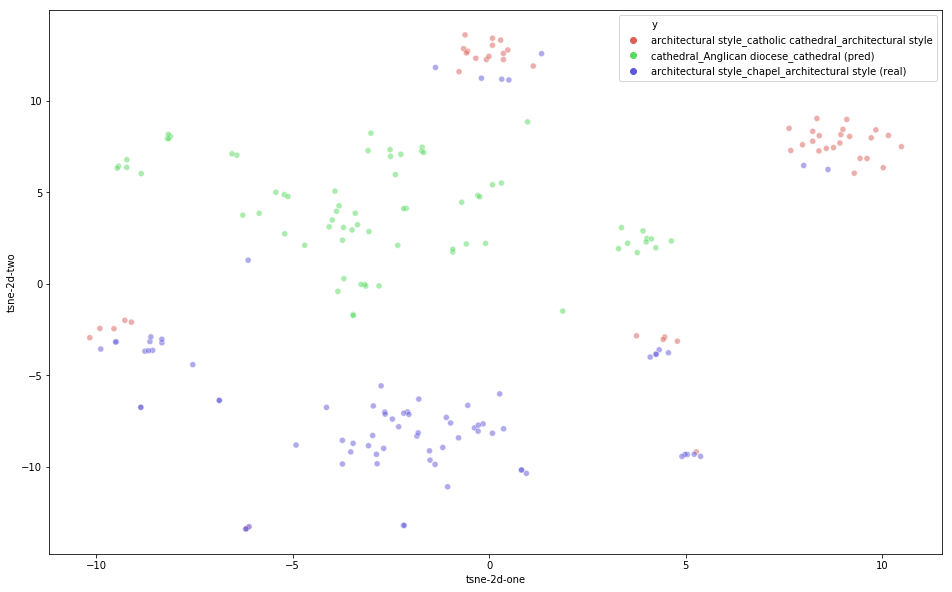

In [660]:
# 'P1376_Q5119_Q3624078' 'P2541_Q829080_Q3624078' 'P1376_Q484170_Q6465'
case_study('data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ_popu/test.nway', 
           'data/analogy_dataset/split_middle_by_entail_nway_subgraph10_sample5_parent_occ_popu/label2occs.nway', 
           '../pytorch_big_graph/emb/transe.txt', 
           'data/property_occurrence_prop580k_split/subprops_hard',
           'data/split_merge_triples/property_occurrence_prop580k_split_entityid2name.pkl',
           'P149_Q56242215_Q32880', 
           'P1885_Q18917976_Q2977', 
           'P149_Q108325_Q32880')

In [654]:
def test():
    emb_id2ind, emb = read_embeddings_from_text_file(
        '../pytorch_big_graph/emb/transe.txt', debug=False, emb_size=200, use_padding=True)
    # Q5119 Q3624078
    # Q21518270 Q35657
    for p, pred, real in [('Q21518270', 'Q829080', 'Q484170'), ('Q35657', 'Q3624078', 'Q6465')]:
        p = emb[emb_id2ind[p]].reshape(1, -1)
        pred = emb[emb_id2ind[pred]].reshape(1, -1)
        real = emb[emb_id2ind[real]].reshape(1, -1)
        print('pred {}, real {}'.format(cosine_similarity(p, pred), 
                                        cosine_similarity(p, real)))

    
test()

load emb from cache ...
pred [[0.19174834]], real [[0.2981122]]
pred [[0.4766778]], real [[0.29524204]]
